In [144]:
from pymongo import MongoClient
import pandas as pd
from bson.objectid import ObjectId
import datetime
import time
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import talib
import seaborn as sns

connectionLocal = MongoClient('18.213.229.80', 27017)
db = connectionLocal.ETF_db
TradesData = db.TradesData
arbitragecollection = db.ArbitrageCollection

# Convert UTC to EST accounting for day light saving 
import pytz
est = pytz.timezone('US/Eastern')
utc = pytz.utc
fmt = '%Y-%m-%d %H:%M:%S %Z%z'

# Jupyter Notebook to display all the columns in a df
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

# Load ETF Prices

In [145]:
def LoadETFPrices(etfname,dateOfAnalyis,year):
    starthour=dateOfAnalysis.strftime('%Y-%m-%d')+' 08:59:00'
    endhour=dateOfAnalysis.strftime('%Y-%m-%d')+' 16:01:00'
    def getHumanTime(ts=None, divideby=1000000000):
        s, ms = divmod(ts, divideby)
        return datetime.datetime(*time.gmtime(s)[:6])

    etfpricesData={}
    prices = TradesData.find_one({"symbol":etfname, 'dateForData':dateOfAnalyis})
    pricedf = pd.DataFrame(prices['data'])
    pricedf['t'] = pricedf['t'].apply(lambda x: getHumanTime(ts=x, divideby=1000))
    pricedf = pricedf.rename(columns={'t':'Time','o':'Open','h':'High','c':'Close','l':'Low','v':'Volume'})
    pricedf = pricedf[['Time','Volume','Open','Close','High','Low']]

    if dateOfAnalyis > datetime.datetime(year-1,9,1) and dateOfAnalyis < datetime.datetime(year,3,8):
        pricedf['Time']=pricedf['Time'] - datetime.timedelta(hours=5)
    else:
        pricedf['Time']=pricedf['Time'] - datetime.timedelta(hours=4)
    return pricedf[(pricedf['Time']>starthour) & (pricedf['Time']<endhour)]

def loadETFArbitrageData(etfdata,dateOfAnalyis,year):
    starthour=dateOfAnalysis.strftime('%Y-%m-%d')+' 08:59:00'
    endhour=dateOfAnalysis.strftime('%Y-%m-%d')+' 16:01:00'

    etfdata = pd.DataFrame(etfdata)
    # Convert UTC time to E"ST time, Check if winter time - 5, Summer time - 4 
    if dateOfAnalyis > datetime.datetime(year-1,9,1) and dateOfAnalyis < datetime.datetime(year,3,8):
        etfdata['Time']=etfdata['Time'] - datetime.timedelta(hours=5)
    else:
        etfdata['Time']=etfdata['Time'] - datetime.timedelta(hours=4)
    return etfdata[(etfdata['Time']>starthour) & (etfdata['Time']<endhour)]

def analysePerformance(df=None, BuySellIndex=None):
    singalDf={}
    for dateindex in BuySellIndex.index:
        idx = df.index.get_loc(dateindex)
        res=df.iloc[(idx+1) : (idx + 6)]['ETF Change Price %']
        temp = list(res.values)
        if len(res.values)<5:
            [temp.append(np.nan) for i in range(5-len(res.values))]    
        singalDf[dateindex] = temp

    singalDf=pd.DataFrame(singalDf).T
    singalDf.columns=['T+1','T+2','T+3','T+4','T+5']
    singalDf.loc['Total Return',:]=singalDf.sum(axis=0)
    return singalDf

In [146]:
## Arbitrage Direction to T+1 Minute ETF Price Change Direction Comparison

def Arb_Tp1(arbdf, dateOfAnalysis, ArbitrageModVal):
#     etfdata = extract_arbitrage_data(etfname, dateOfAnalysis)
    etfdata = arbdf
    etfarbdf = etfdata[['Time','ETF Change Price %','Arbitrage in $','ETFMover%1','ETFMover%2','ETFMover%3','Change%1','Change%2','Change%3']]
    etfarbdf.set_index('Time', inplace=True)
    
    def tplusone(df):
        df = df.copy()
        arbtpo = None
        for timst in df.index:
            req = timst+datetime.timedelta(minutes=1)
            try:
                arbtpo = df.loc[pd.Timestamp(req),'ETF Change Price %']
                df.loc[pd.Timestamp(timst),'T+1 Return'] = arbtpo
            except:
                pass
        return df
    etfarbdf = tplusone(etfarbdf)

    etfarbdfr = etfarbdf[abs(etfarbdf['Arbitrage in $'])>ArbitrageModVal]

    moverset = set()
    moverslist = []
    moverslist.extend(list(etfarbdfr['ETFMover%1']))
    moverslist.extend(list(etfarbdfr['ETFMover%2']))
    moverslist.extend(list(etfarbdfr['ETFMover%3']))
    for mover in moverslist:
        moverset.add(mover[0])

    arb_t1_df = pd.DataFrame(columns = ['dateOfAnalysis','Movers','Arb +ve/ T+1 +ve','Arb +ve/ T+1 -ve','Arb -ve/ T+1 +ve','Arb -ve/ T+1 -ve'])
    for mover in list(moverset):
        stats = {"Movers":mover,"Arb +ve/ T+1 +ve":0,"Arb +ve/ T+1 -ve":0,"Arb -ve/ T+1 +ve":0,"Arb -ve/ T+1 -ve":0}
        for t in etfarbdfr.index:
            if mover in (etfarbdfr.loc[t, 'ETFMover%1'][0],etfarbdfr.loc[t, 'ETFMover%2'][0],etfarbdfr.loc[t, 'ETFMover%3'][0]):
                if etfarbdfr.loc[t,'Arbitrage in $'] > 0 : 
                    if etfarbdfr.loc[t,'T+1 Return'] > 0 :
                        stats['Arb +ve/ T+1 +ve'] +=1
                    else:
                        stats['Arb +ve/ T+1 -ve'] +=1
                else:
                    if etfarbdfr.loc[t,'T+1 Return'] > 0 :
                        stats['Arb -ve/ T+1 +ve'] +=1
                    else:
                        stats['Arb -ve/ T+1 -ve'] +=1
        arb_t1_df = arb_t1_df.append(stats, ignore_index=True)

    arb_t1_df['TotalNoOfCases'] = sum([arb_t1_df['Arb +ve/ T+1 +ve'],arb_t1_df['Arb +ve/ T+1 -ve'],arb_t1_df['Arb -ve/ T+1 +ve'],arb_t1_df['Arb -ve/ T+1 -ve']])
    arb_t1_df = arb_t1_df.sort_values(by=['TotalNoOfCases'], ascending=False)

    arb_t1_df['total_arbp'] = arb_t1_df['Arb +ve/ T+1 +ve']+ arb_t1_df['Arb +ve/ T+1 -ve']
    arb_t1_df['total_arbn'] = arb_t1_df['Arb -ve/ T+1 +ve']+ arb_t1_df['Arb -ve/ T+1 -ve']

    def prob_percent(val, total):
        if total == 0:
            return None
        return (val/total)*100

    for col in arb_t1_df.columns:
        if col not in ['Movers','TotalNoOfCases','total_arbp','total_arbn']:
            if col not in ['Arb -ve/ T+1 +ve','Arb -ve/ T+1 -ve']:
                arb_t1_df[col] = arb_t1_df.apply(lambda x: prob_percent(x[col],x['total_arbp']),axis=1)
            if col not in ['Arb +ve/ T+1 +ve','Arb +ve/ T+1 -ve']:
                arb_t1_df[col] = arb_t1_df.apply(lambda x: prob_percent(x[col],x['total_arbn']),axis=1)
    arb_t1_df['dateOfAnalysis'] = dateOfAnalysis
    arb_t1_df.set_index(['dateOfAnalysis','Movers'])
    return arb_t1_df

# Build Signals

## Strategy Notes - 4 Types of signals

#### Buy = Green = Upward Arrow = etfOverSold = -111
#### Sell = Blue = Downward Arrow = etfoverBought = 111


#### 4 Types of Signals

Type 1) When Buy Signal is at the tip of trend reversal and it's bullish for (T+1 min, T+2 min) - Good Signal<br>
Type 2) When Sell Signal is at the tip of trend reversal and it's bearish for (T+1, T+2 min). - Good Signal.<br>
Type 3) When Algorithm gives Buy Signal because the ETF is underpriced. But due to momentum, the market continues to go down. - Bad Signal<br>
Type 4) When Algorithm Gives Sell Signal because the ETF is overpriced. But due to momentum, the market continues to go up. - Bad Signal<br>

Combine trend with Buy and sell. 


# Pattern Recognition

100 = Buy stock, = -111<br>
-100 = Sell stock, = 111<br>

In [147]:
def MomentumSignals(df,tp=14):
    
    ############################
    # MOMENTUM SIGNALS
    ############################    
    
    # SMA
    df['Momentum Signal']=talib.SMA(df['Close'],timeperiod=tp)
    description='SMA'
    df['Momentum Indicator'] = 0
    df.loc[(abs(df['ETF Price']) > df['Momentum Signal']), 'Momentum Indicator'] = 111
    df.loc[(abs(df['ETF Price']) < df['Momentum Signal']), 'Momentum Indicator'] = -111

    # CMO - Chande Momentum Oscillator
    df['CMO Signal']=talib.CMO(df['Close'],timeperiod=tp)
    description='CMO'
    df['CMO Indicator'] = 0
    df.loc[df['CMO Signal']>=50, 'CMO Indicator'] = 111
    df.loc[df['CMO Signal']<=-50, 'CMO Indicator'] = -111
    
    # ADX
    df['ADX Signal']=talib.ADX(df['High'],df['Low'],df['Close'],timeperiod=tp)
    description='ADX'
    df['ADX Trend'] = 0
    df.loc[df['ADX Signal']<25, 'ADX Trend'] = 'No Trend'
    df.loc[df['ADX Signal']>=25, 'ADX Trend'] = 'Weak Trend'
    df.loc[df['ADX Signal']>=50, 'ADX Trend'] = 'Strong Trend'
    df.loc[df['ADX Signal']>=75, 'ADX Trend'] = 'Extreme Strong Trend'

    # AROONOSC
    df['AROONOSC Signal']=talib.AROONOSC(df['High'],df['Low'],timeperiod=tp)
    df['AROONOSC Indicator'] = 0
    df.loc[df['AROONOSC Signal'] > 50, 'AROONOSC Trend'] = 'Uptrend'
    df.loc[df['AROONOSC Signal'] > 75, 'AROONOSC Trend'] = 'Strong Uptrend'
    df.loc[df['AROONOSC Signal'] < -50, 'AROONOSC Trend'] = 'Downtrend'
    df.loc[df['AROONOSC Signal'] < -75, 'AROONOSC Trend'] = 'Strong Downtrend'

    # RSI
    df['RSI Signal']=talib.RSI(df['Close'],timeperiod=tp)
    df['RSI Indicator'] = 0
    df.loc[df['RSI Signal']>=75, 'RSI Indicator'] = 111
    df.loc[df['RSI Signal']<=25, 'RSI Indicator'] = -111
    
    # ULTOSC - Ultimate Oscillator
    df['ULTOC Signal']=talib.ULTOSC(df['High'],df['Low'],df['Close'],timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['ULTOC Indicator'] = 0
    df.loc[df['ULTOC Signal']>=75, 'ULTOC Indicator'] = 111
    df.loc[df['ULTOC Signal']<=25, 'ULTOC Indicator'] = -111
    
    # WILLR  
    df['WILLR Signal']=talib.WILLR(df['High'],df['Low'],df['Close'],timeperiod=tp)
    df['WILLR Indicator'] = 0
    df.loc[df['WILLR Signal']>=-20, 'WILLR Indicator'] = 111
    df.loc[df['WILLR Signal']<=-80, 'WILLR Indicator'] = -111
    
    # MFI - Monet Flow Index
    df['MFI Signal']=talib.MFI(df['High'],df['Low'],df['Close'],df['Volume'],timeperiod=tp)
    df['MFI Indicator'] = 0
    df.loc[df['MFI Signal']>=75, 'MFI Indicator'] = 111
    df.loc[df['MFI Signal']<=25, 'MFI Indicator'] = -111
    
    # STOCHRSI
    fastk, fastd=talib.STOCHRSI(df['ETF Price'], timeperiod=tp, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['FastStochastic']=fastk
    df['Stochastic Indicator']=np.where(fastk>80, 111, 0)+np.where(fastk<20, -111, 0)
    
    return df


############################
# CANDLE PATTERNS RECOGNITION
############################    
def PatternSignals(df):

    def addCandle(functionname):
        return functionname(df['Open'],df['High'],df['Low'],df['Close']).replace({100:-111,-100:111})
    
    # Bullish Candles
    df['Hammer Pat'] = addCandle(talib.CDLHAMMER)
    df['InvertedHammer Pat']=addCandle(talib.CDLINVERTEDHAMMER)
    df['DragonFlyDoji Pat']=addCandle(talib.CDLDRAGONFLYDOJI)
    df['PiercingLine Pat']=addCandle(talib.CDLPIERCING)
    df['MorningStar Pat']=addCandle(talib.CDLMORNINGSTAR)
    df['MorningStarDoji Pat']=addCandle(talib.CDLMORNINGDOJISTAR)
    df['3WhiteSoldiers Pat']=addCandle(talib.CDL3WHITESOLDIERS)

    
    # Bearish Candles
    df['HanginMan Pat']=addCandle(talib.CDLHANGINGMAN)
    df['Shooting Pat']=addCandle(talib.CDLSHOOTINGSTAR)
    df['GraveStone Pat']=addCandle(talib.CDLGRAVESTONEDOJI)
    df['DarkCloud Pat']=addCandle(talib.CDLDARKCLOUDCOVER)
    df['EveningStar Pat']=addCandle(talib.CDLEVENINGSTAR)
    df['EveningDoji Pat']=addCandle(talib.CDLEVENINGDOJISTAR)
    df['3BlackCrows Pat']=addCandle(talib.CDL3BLACKCROWS)
    df['AbandonedBaby Pat']=addCandle(talib.CDLABANDONEDBABY)
    
    # Common Patterns
    df['Engulfing Pat']=addCandle(talib.CDLENGULFING)
    df['Harami Pat']=addCandle(talib.CDLHARAMI)
    
    # Indecission Patterns
    df['IndecisionSpinningTop Pat']=addCandle(talib.CDLSPINNINGTOP)
    df['IndecisionDoji Pat']=addCandle(talib.CDLDOJI)
    df['3LineStrike Pat']=addCandle(talib.CDL3LINESTRIKE)
    
    return df



MomentumsignalsColumns = ['ADX Trend','AROONOSC Trend','Momentum Indicator','CMO Indicator','RSI Indicator','ULTOC Indicator','Stochastic Indicator','WILLR Indicator','MFI Indicator']
CandlesignalsColumns = ['Hammer Pat','InvertedHammer Pat','DragonFlyDoji Pat','PiercingLine Pat','MorningStar Pat','MorningStarDoji Pat','3WhiteSoldiers Pat','HanginMan Pat','Shooting Pat','GraveStone Pat','DarkCloud Pat','EveningStar Pat','EveningDoji Pat','3BlackCrows Pat','AbandonedBaby Pat','AbandonedBaby Pat','Engulfing Pat','Harami Pat','IndecisionSpinningTop Pat','IndecisionDoji Pat','3LineStrike Pat']

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-03-18     MSFT   42.016807         57.983193          
7   2020-03-18     INTC   38.805970         61.194030          
6   2020-03-18     V      41.304348         58.695652          
5   2020-03-18     CSCO   50.000000         50.000000          
0   2020-03-18     MA     41.666667         58.333333          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  41.911765         58.088235         255            119        136        
7   42.253521         57.746479         138            67         71         
6   42.105263         57.894737         103            46         57         
5   30.555556         69.444444         72             36         36         
0   40.625000         59.375000         68             36         32

ETF Name =FTEC
Date =2020-03-18 00:00:00
Sell Positions Probability
T+1    0.818182
T+2    0.636364
T+3    0.363636
T+4    0.545455
T+5    0.636364
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-03-18 10:31:00  0.066442                 0.117694        No Trend       
2020-03-18 10:52:00  0.060807                 0.138408        No Trend       
2020-03-18 11:09:00  0.053296                 0.098946        Weak Trend     
2020-03-18 11:11:00  0.056737                 0.076766        Strong Trend   
2020-03-18 12:26:00  0.063825                 0.098966        No Trend       
2020-03-18 12:36:00  0.068423                 0.097247        No Trend       
2020-03-18 13:46:00  0.088375                 0.146646        No Trend       
2020-03-18 14:18:00  0.055784                 0.180287        No Trend       
2020-03-18 15:24:00  0.059301                 0.119838        No Trend       
2020-03-18 15:51:00  0.075464                 0.101724        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-18 10:31:00  Uptrend           111.0               0.0             
2020-03-18 10:52:00  Strong Downtrend -111.0               0.0             
2020-03-18 11:09:00  Downtrend        -111.0               0.0             
2020-03-18 11:11:00  Strong Downtrend -111.0              -111.0           
2020-03-18 12:26:00  Uptrend           111.0               0.0             
2020-03-18 12:36:00  NaN              -111.0               0.0             
2020-03-18 13:46:00  Uptrend          -111.0               0.0             
2020-03-18 14:18:00  NaN               111.0               0.0             
2020-03-18 15:24:00  Strong Downtrend -111.0               0.0             
2020-03-18 15:51:00  Strong Uptrend    111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-18 10:31:00  0.0            0.0              111.0                  
2020-03-18 10:52:00  0.0            0.0             -111.0                  
2020-03-18 11:09:00  0.0           -111.0            0.0                    
2020-03-18 11:11:00 -111.0         -111.0           -111.0                  
2020-03-18 12:26:00  0.0            0.0              111.0                  
2020-03-18 12:36:00  0.0            0.0              0.0                    
2020-03-18 13:46:00  0.0            0.0             -111.0                  
2020-03-18 14:18:00  0.0            0.0              111.0                  
2020-03-18 15:24:00  0.0            0.0              0.0                    
2020-03-18 15:51:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  Shooting Pat  \
2020-03-18 10:31:00  111.0            0.0            0.0            
2020-03-18 10:52:00 -111.0            0.0            0.0            
2020-03-18 11:09:00 -111.0           -111.0          0.0            
2020-03-18 11:11:00 -111.0           -111.0          0.0            
2020-03-18 12:26:00  111.0            0.0            0.0            
2020-03-18 12:36:00 -111.0            0.0            0.0            
2020-03-18 13:46:00  0.0              0.0            0.0            
2020-03-18 14:18:00  0.0              0.0            0.0            
2020-03-18 15:24:00 -111.0            0.0            111.0          
2020-03-18 15:51:00  0.0              0.0            0.0            
Total Return        NaN              NaN            NaN             

                     Engulfing Pat  IndecisionDoji Pat       T+1       T+2  \
2020-03-18 10:31:00  0.0            0.0                -0.169609 -0.344620   
2020-03-18 10:52:00  0.0            0.0                -0.355718 -0.191554   
2020-03-18 11:09:00  0.0            0.0                -0.254542  0.006600   
2020-03-18 11:11:00  111.0          0.0                -0.020678 -0.016722   
2020-03-18 12:26:00  0.0   

******************
Buy Positions Probability
T+1    0.636364
T+2    0.272727
T+3    0.090909
T+4    0.545455
T+5    0.181818
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-18 10:30:00  0.081376                -0.101460        No Trend     
2020-03-18 10:53:00  0.057126                -0.178664        Weak Trend   
2020-03-18 11:05:00  0.060362                -0.108139        Weak Trend   
2020-03-18 11:10:00  0.060086                -0.120877        Weak Trend   
2020-03-18 12:43:00  0.066884                -0.088131        Weak Trend   
2020-03-18 12:53:00  0.062895                -0.113939        Weak Trend   
2020-03-18 14:02:00  0.064630                -0.086421        No Trend     
2020-03-18 14:41:00  0.075337                -0.118509        Weak Trend   
2020-03-18 15:25:00  0.070289                -0.106034        No Trend     
2020-03-18 15:57:00  0.118220                -0.166983        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-18 10:30:00  Uptrend           111.0               0.0             
2020-03-18 10:53:00  Strong Downtrend -111.0               0.0             
2020-03-18 11:05:00  NaN              -111.0              -111.0           
2020-03-18 11:10:00  Strong Downtrend -111.0              -111.0           
2020-03-18 12:43:00  Strong Downtrend -111.0               0.0             
2020-03-18 12:53:00  Strong Downtrend -111.0               0.0             
2020-03-18 14:02:00  Downtrend        -111.0               0.0             
2020-03-18 14:41:00  Strong Uptrend    111.0               0.0             
2020-03-18 15:25:00  Strong Downtrend -111.0               0.0             
2020-03-18 15:57:00  Strong Uptrend    111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-18 10:30:00  0.0            0.0              111.0                  
2020-03-18 10:53:00  0.0            0.0             -111.0                  
2020-03-18 11:05:00 -111.0          0.0             -111.0                  
2020-03-18 11:10:00 -111.0         -111.0           -111.0                  
2020-03-18 12:43:00  0.0            0.0             -111.0                  
2020-03-18 12:53:00  0.0            0.0             -111.0                  
2020-03-18 14:02:00  0.0            0.0             -111.0                  
2020-03-18 14:41:00  0.0            0.0             -111.0                  
2020-03-18 15:25:00  0.0            0.0             -111.0                  
2020-03-18 15:57:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  Hammer Pat  \
2020-03-18 10:30:00  111.0            0.0            0.0          
2020-03-18 10:53:00 -111.0           -111.0          0.0          
2020-03-18 11:05:00 -111.0           -111.0          0.0          
2020-03-18 11:10:00 -111.0           -111.0          0.0          
2020-03-18 12:43:00  0.0              0.0            0.0          
2020-03-18 12:53:00 -111.0           -111.0          0.0          
2020-03-18 14:02:00 -111.0           -111.0          0.0          
2020-03-18 14:41:00  0.0              111.0          0.0          
2020-03-18 15:25:00 -111.0            0.0           -111.0        
2020-03-18 15:57:00  0.0              111.0          0.0          
Total Return        NaN              NaN            NaN           

                     EveningStar Pat  IndecisionDoji Pat       T+1       T+2  \
2020-03-18 10:30:00  0.0              0.0                 0.316825 -0.169609   
2020-03-18 10:53:00  0.0              0.0                -0.191554  0.000000   
2020-03-18 11:05:00  0.0              0.0                -0.149116 -0.096348   
2020-03-18 11:10:00  0.0             -111.0               0.006600 -0.020678   
2020-03-18 12:43:00  0.0              0.0                 0.32544

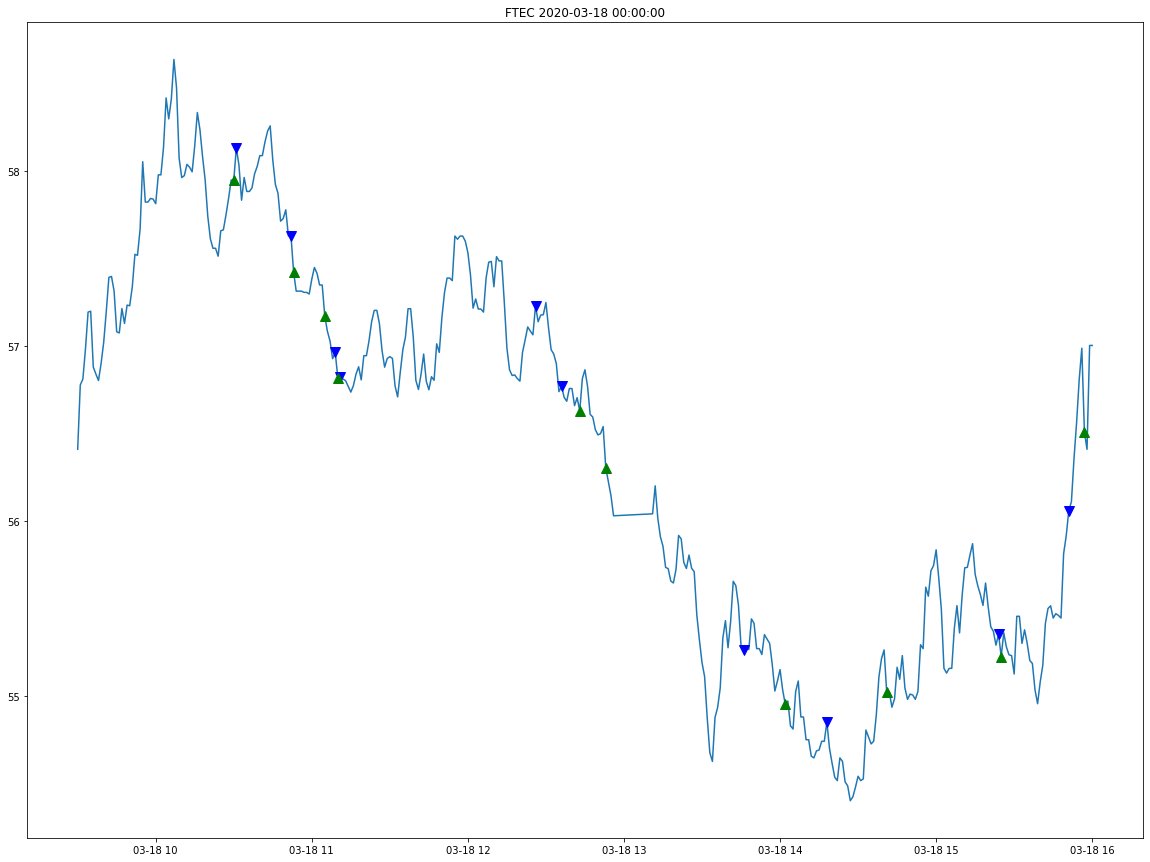

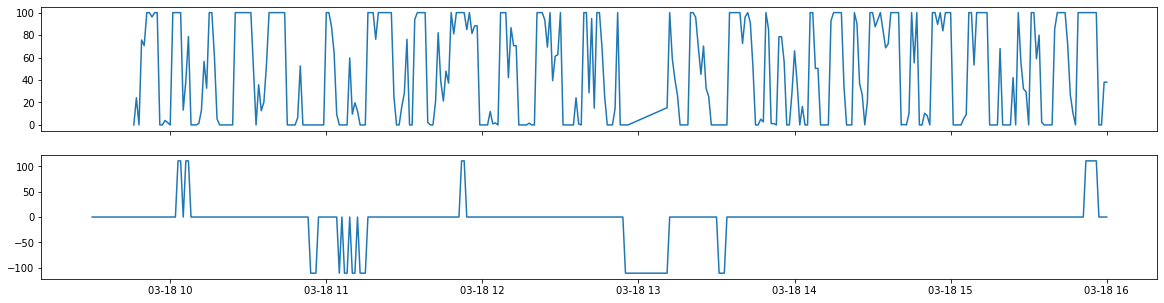

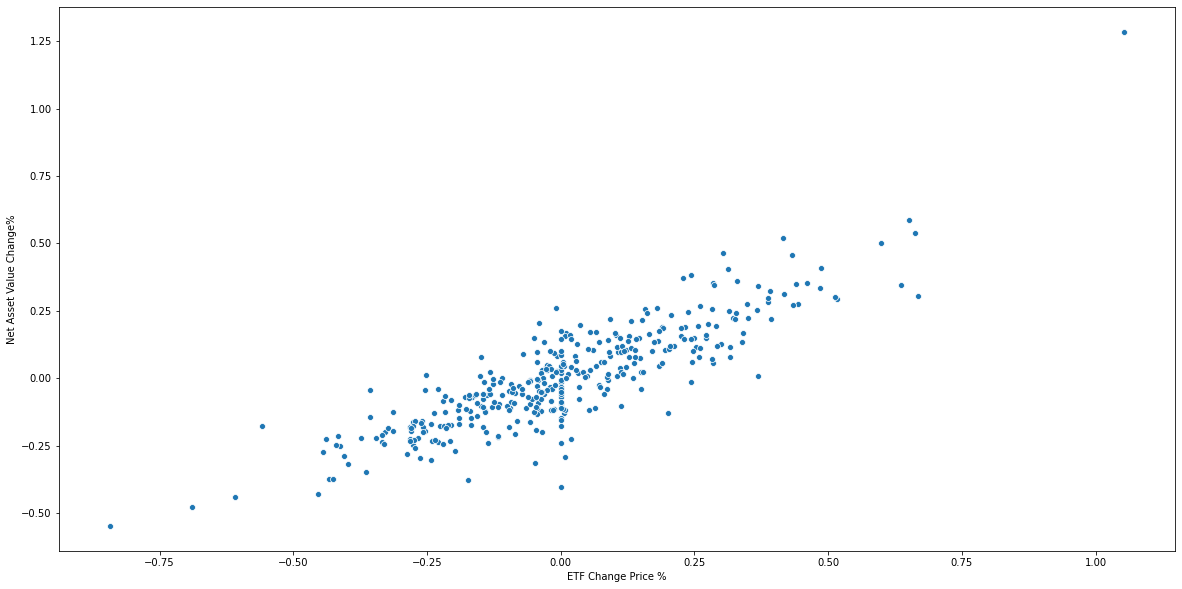

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-03-19     MSFT   47.058824         52.941176          
6   2020-03-19     V      50.793651         49.206349          
7   2020-03-19     INTC   46.428571         53.571429          
2   2020-03-19     MA     48.837209         51.162791          
5   2020-03-19     CSCO   50.000000         50.000000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  54.901961         45.098039         221            119        102        
6   61.111111         38.888889         117            63         54         
7   53.488372         46.511628         99             56         43         
2   58.064516         41.935484         74             43         31         
5   50.000000         50.000000         68             34         34

ETF Name =FTEC
Date =2020-03-19 00:00:00
Sell Positions Probability
T+1    0.833333
T+2    0.583333
T+3    0.416667
T+4    0.583333
T+5    0.333333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-19 09:31:00  0.424528                 0.528164        0            
2020-03-19 09:55:00  0.112350                 0.165537        Weak Trend   
2020-03-19 11:03:00  0.076090                 0.096350        Weak Trend   
2020-03-19 11:13:00  0.071002                 0.131218        No Trend     
2020-03-19 11:28:00  0.072813                 0.112886        Weak Trend   
2020-03-19 11:31:00  0.085724                 0.111685        Weak Trend   
2020-03-19 12:51:00  0.054661                 0.082926        Weak Trend   
2020-03-19 13:02:00  0.061477                 0.086381        No Trend     
2020-03-19 14:37:00  0.053342                 0.076875        No Trend     
2020-03-19 15:06:00  0.055400                 0.106266        Weak Trend   
2020-03-19 15:55:00  0.057209                 0.114130        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-19 09:31:00  NaN               0.0                 0.0             
2020-03-19 09:55:00  Strong Uptrend    111.0               0.0             
2020-03-19 11:03:00  Strong Uptrend    111.0               0.0             
2020-03-19 11:13:00  NaN               111.0               0.0             
2020-03-19 11:28:00  Strong Uptrend    111.0               111.0           
2020-03-19 11:31:00  Strong Uptrend    111.0               0.0             
2020-03-19 12:51:00  Strong Uptrend    111.0               0.0             
2020-03-19 13:02:00  NaN              -111.0               0.0             
2020-03-19 14:37:00  Strong Uptrend    111.0               0.0             
2020-03-19 15:06:00  Downtrend         111.0               0.0             
2020-03-19 15:55:00  Strong Downtrend -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-19 09:31:00  0.0            0.0              0.0                    
2020-03-19 09:55:00  0.0            0.0              111.0                  
2020-03-19 11:03:00  0.0            0.0              111.0                  
2020-03-19 11:13:00  0.0            0.0              111.0                  
2020-03-19 11:28:00  111.0          111.0            111.0                  
2020-03-19 11:31:00  0.0            0.0             -111.0                  
2020-03-19 12:51:00  0.0            111.0            0.0                    
2020-03-19 13:02:00  0.0            0.0              111.0                  
2020-03-19 14:37:00  0.0            0.0              0.0                    
2020-03-19 15:06:00  0.0            0.0              111.0                  
2020-03-19 15:55:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  IndecisionDoji Pat  \
2020-03-19 09:31:00  0.0              0.0            0.0                  
2020-03-19 09:55:00  111.0            111.0          0.0                  
2020-03-19 11:03:00  111.0            111.0         -111.0                
2020-03-19 11:13:00  111.0            0.0            0.0                  
2020-03-19 11:28:00  111.0            111.0         -111.0                
2020-03-19 11:31:00  0.0              0.0           -111.0                
2020-03-19 12:51:00  111.0            0.0            0.0                  
2020-03-19 13:02:00  0.0              111.0          0.0                  
2020-03-19 14:37:00  0.0              111.0          0.0                  
2020-03-19 15:06:00  0.0              0.0            0.0                  
2020-03-19 15:55:00  0.0              0.0            0.0                  
Total Return        NaN              NaN            NaN                   

                          T+1       T+2       T+3       T+4      

******************
Buy Positions Probability
T+1    0.40
T+2    0.45
T+3    0.35
T+4    0.65
T+5    0.60
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-19 10:39:00  0.157489                -0.336910        Weak Trend   
2020-03-19 11:04:00  0.077360                -0.136604        Weak Trend   
2020-03-19 11:07:00  0.074108                -0.098760        No Trend     
2020-03-19 11:41:00  0.066095                -0.107997        No Trend     
2020-03-19 12:10:00  0.153670                -0.221583        No Trend     
2020-03-19 12:25:00  0.068163                -0.106878        No Trend     
2020-03-19 12:34:00  0.058010                -0.088669        No Trend     
2020-03-19 12:37:00  0.065358                -0.094807        No Trend     
2020-03-19 12:56:00  0.062058                -0.082579        Weak Trend   
2020-03-19 13:08:00  0.075510                -0.119317        No Trend     
2020-03-19 13:14:00  0.063211                -0.154193        No Trend     
2020-03-19 13:24:00  0.087633                -0.154345        No Trend     
2020-03-19 14:01:00  0.080678                -0.103705        Weak Trend   
2020-03-19 14:36:00  0.051418                -0.079471        No Trend     
2020-03-19 14:59:00  0.051455                -0.080559        Weak Trend   
2020-03-19 15:02:00  0.054279                -0.090151        Weak Trend   
2020-03-19 15:07:00  0.053792                -0.135750        Weak Trend   
2020-03-19 15:10:00  0.052375                -0.076052        Weak Trend   
2020-03-19 15:51:00  0.061591                -0.152196        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-19 10:39:00  NaN              -111.0               0.0             
2020-03-19 11:04:00  Strong Uptrend    111.0               0.0             
2020-03-19 11:07:00  NaN              -111.0               0.0             
2020-03-19 11:41:00  Uptrend           111.0               0.0             
2020-03-19 12:10:00  NaN              -111.0               0.0             
2020-03-19 12:25:00  NaN              -111.0               0.0             
2020-03-19 12:34:00  NaN              -111.0               0.0             
2020-03-19 12:37:00  NaN              -111.0               0.0             
2020-03-19 12:56:00  NaN               111.0               0.0             
2020-03-19 13:08:00  Downtrend         111.0               0.0             
2020-03-19 13:14:00  Strong Uptrend   -111.0               0.0             
2020-03-19 13:24:00  NaN               111.0               0.0             
2020-03-19 14:01:00  NaN              -111.0               0.0             
2020-03-19 14:36:00  Uptrend           111.0               0.0             
2020-03-19 14:59:00  NaN              -111.0               0.0             
2020-03-19 15:02:00  Strong Downtrend -111.0              -111.0           
2020-03-19 15:07:00  Downtrend        -111.0               0.0             
2020-03-19 15:10:00  Strong Downtrend -111.0              -111.0           
2020-03-19 15:51:00  Downtrend        -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-19 10:39:00  0.0            0.0             -111.0                  
2020-03-19 11:04:00  0.0            0.0             -111.0                  
2020-03-19 11:07:00  0.0            0.0             -111.0                  
2020-03-19 11:41:00  0.0            0.0             -111.0                  
2020-03-19 12:10:00  0.0            0.0             -111.0                  
2020-03-19 12:25:00  0.0            0.0             -111.0                  
2020-03-19 12:34:00  0.0            0.0             -111.0                  
2020-03-19 12:37:00  0.0            0.0              111.0                  
2020-03-19 12:56:00  0.0            0.0             -111.0                  
2020-03-19 13:08:00  0.0            0.0              0.0 

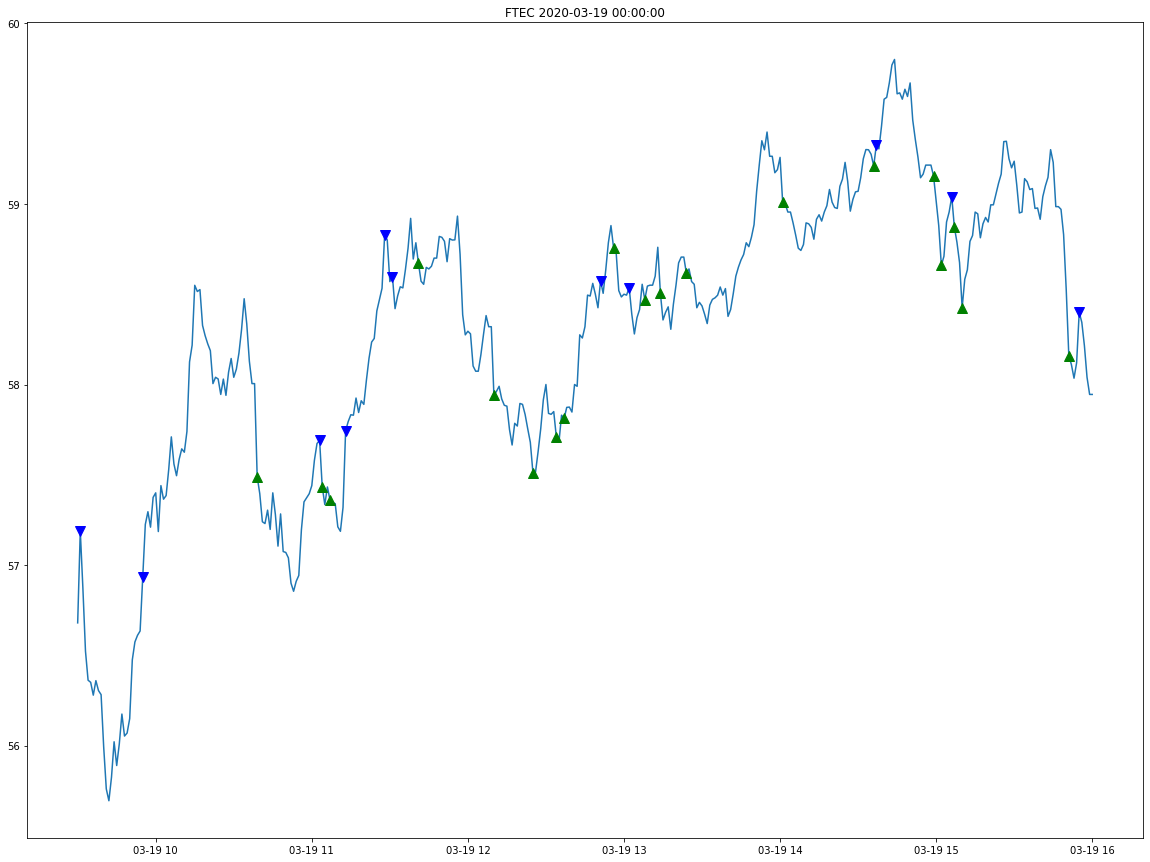

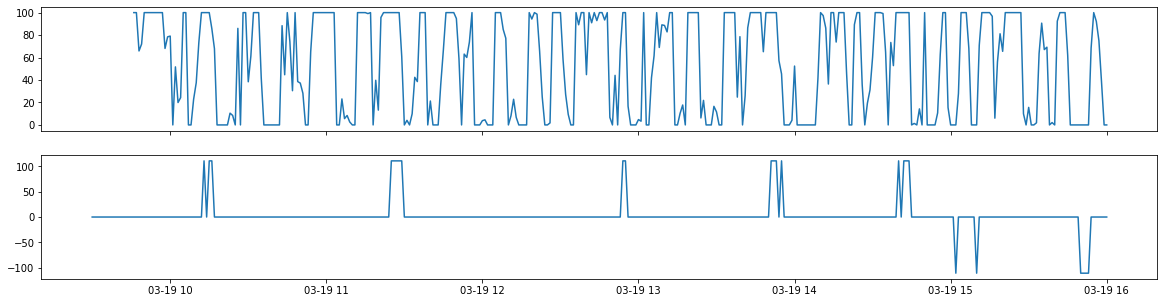

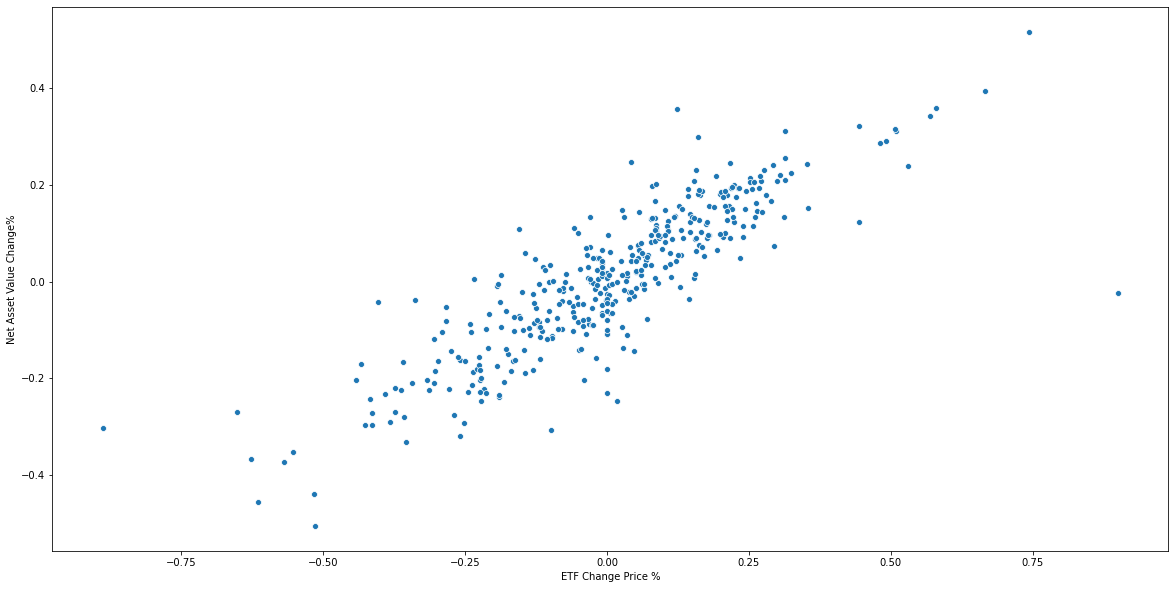

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-03-20     MSFT   36.974790         63.025210          
8   2020-03-20     V      41.666667         58.333333          
9   2020-03-20     INTC   32.786885         67.213115          
2   2020-03-20     MA     33.333333         66.666667          
6   2020-03-20     CSCO   36.842105         63.157895          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  45.454545         54.545455         251            119        132        
8   48.101266         51.898734         139            60         79         
9   45.070423         54.929577         132            61         71         
2   31.250000         68.750000         81             33         48         
6   42.857143         57.142857         47             19         28

ETF Name =FTEC
Date =2020-03-20 00:00:00
Sell Positions Probability
T+1    0.818182
T+2    0.818182
T+3    0.454545
T+4    0.545455
T+5    0.636364
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-20 10:50:00  0.092855                 0.139146        No Trend     
2020-03-20 11:50:00  0.103686                 0.135510        No Trend     
2020-03-20 12:53:00  0.093098                 0.119898        Weak Trend   
2020-03-20 13:12:00  0.081840                 0.105804        Weak Trend   
2020-03-20 13:30:00  0.086054                 0.140216        Weak Trend   
2020-03-20 14:21:00  0.076981                 0.120098        Weak Trend   
2020-03-20 14:30:00  0.073768                 0.118632        Weak Trend   
2020-03-20 14:34:00  0.064410                 0.085932        No Trend     
2020-03-20 14:37:00  0.063667                 0.088828        No Trend     
2020-03-20 15:11:00  0.077403                 0.108839        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-20 10:50:00  Downtrend         111.0               0.0             
2020-03-20 11:50:00  Downtrend         111.0               0.0             
2020-03-20 12:53:00  Strong Uptrend    111.0               111.0           
2020-03-20 13:12:00  NaN               111.0               0.0             
2020-03-20 13:30:00  NaN               111.0               0.0             
2020-03-20 14:21:00  Downtrend         111.0               0.0             
2020-03-20 14:30:00  Strong Downtrend  111.0               0.0             
2020-03-20 14:34:00  NaN               111.0               0.0             
2020-03-20 14:37:00  Downtrend        -111.0               0.0             
2020-03-20 15:11:00  NaN               111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-20 10:50:00  0.0            0.0              111.0                  
2020-03-20 11:50:00  0.0            0.0              111.0                  
2020-03-20 12:53:00  111.0          111.0            111.0                  
2020-03-20 13:12:00  0.0            0.0              0.0                    
2020-03-20 13:30:00  0.0            0.0              111.0                  
2020-03-20 14:21:00  0.0            0.0              111.0                  
2020-03-20 14:30:00  0.0            0.0              111.0                  
2020-03-20 14:34:00  0.0            0.0              0.0                    
2020-03-20 14:37:00  0.0            0.0              0.0                    
2020-03-20 15:11:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  Shooting Pat  \
2020-03-20 10:50:00  111.0            0.0            111.0          
2020-03-20 11:50:00  0.0              0.0            0.0            
2020-03-20 12:53:00  111.0            111.0          0.0            
2020-03-20 13:12:00  0.0              0.0            0.0            
2020-03-20 13:30:00  0.0              0.0            0.0            
2020-03-20 14:21:00  0.0              0.0            0.0            
2020-03-20 14:30:00  0.0             -111.0          0.0            
2020-03-20 14:34:00  0.0             -111.0          0.0            
2020-03-20 14:37:00 -111.0           -111.0          0.0            
2020-03-20 15:11:00  111.0            0.0            0.0            
Total Return        NaN              NaN            NaN             

                     IndecisionSpinningTop Pat  IndecisionDoji Pat       T+1  \
2020-03-20 10:50:00  0.0                        0.0                 0.228676   
2020-03-20 11:50:00  0.0                        0.0                -0.088315   
2020-03-20 12:53:00  0.0                       -111.0               0.000000   
2020-03-20 13:12:00  0.0                        0.0                -0.051608   
2020-03-20 13:30:00  0.0                 

******************
Buy Positions Probability
T+1    0.500
T+2    0.250
T+3    0.375
T+4    0.625
T+5    0.375
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-20 10:05:00  0.096556                -0.152717        No Trend     
2020-03-20 10:49:00  0.097880                -0.143720        No Trend     
2020-03-20 13:33:00  0.074670                -0.120511        No Trend     
2020-03-20 13:48:00  0.073790                -0.188886        No Trend     
2020-03-20 14:24:00  0.057924                -0.102998        Weak Trend   
2020-03-20 15:31:00  0.100433                -0.126598        Weak Trend   
2020-03-20 15:50:00  0.082461                -0.104448        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-20 10:05:00  NaN               111.0               0.0             
2020-03-20 10:49:00  Downtrend        -111.0               0.0             
2020-03-20 13:33:00  NaN               111.0               0.0             
2020-03-20 13:48:00  Strong Downtrend -111.0               0.0             
2020-03-20 14:24:00  Strong Downtrend -111.0               0.0             
2020-03-20 15:31:00  Strong Uptrend    111.0               0.0             
2020-03-20 15:50:00  Strong Downtrend -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-20 10:05:00  0.0            0.0             -111.0                  
2020-03-20 10:49:00  0.0            0.0              0.0                    
2020-03-20 13:33:00  0.0            0.0              0.0                    
2020-03-20 13:48:00  0.0            0.0             -111.0                  
2020-03-20 14:24:00  0.0            0.0             -111.0                  
2020-03-20 15:31:00  0.0            0.0             -111.0                  
2020-03-20 15:50:00 -111.0         -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  IndecisionDoji Pat  \
2020-03-20 10:05:00  0.0              0.0            0.0                  
2020-03-20 10:49:00  0.0              0.0           -111.0                
2020-03-20 13:33:00  0.0              0.0           -111.0                
2020-03-20 13:48:00 -111.0            0.0           -111.0                
2020-03-20 14:24:00 -111.0           -111.0          0.0                  
2020-03-20 15:31:00  0.0              111.0          0.0                  
2020-03-20 15:50:00 -111.0           -111.0          0.0                  
Total Return        NaN              NaN            NaN                   

                          T+1       T+2       T+3       T+4       T+5  
2020-03-20 10:05:00 -0.220333 -0.027485 -0.269870  0.215638 -0.167958  
2020-03-20 10:49:00  0.398489  0.228676  0.126518  0.151377  0.000000  
2020-03-20 13:33:00  0.000000  0.034590 -0.285010  0.038491  0.065254  
2020-03-20 13:48:00  0.000000 -0.017340 -0.017343  0.000000  0.101474  
2020-03-20 14:24:00 -0.043722 -0.297437  0.061420 -0.087513 -0.008952  
2020-03-20 15:31:00  0.038808 -0.237163  0.181167 -0.088215 -0.272912  
2020-03-20 15:50:00  0.153430 -0.044787 -0.117472  0.094774  0.010280  
Total Return         0.326672 -0.360945 -0.320590  0.324553 -0.272813

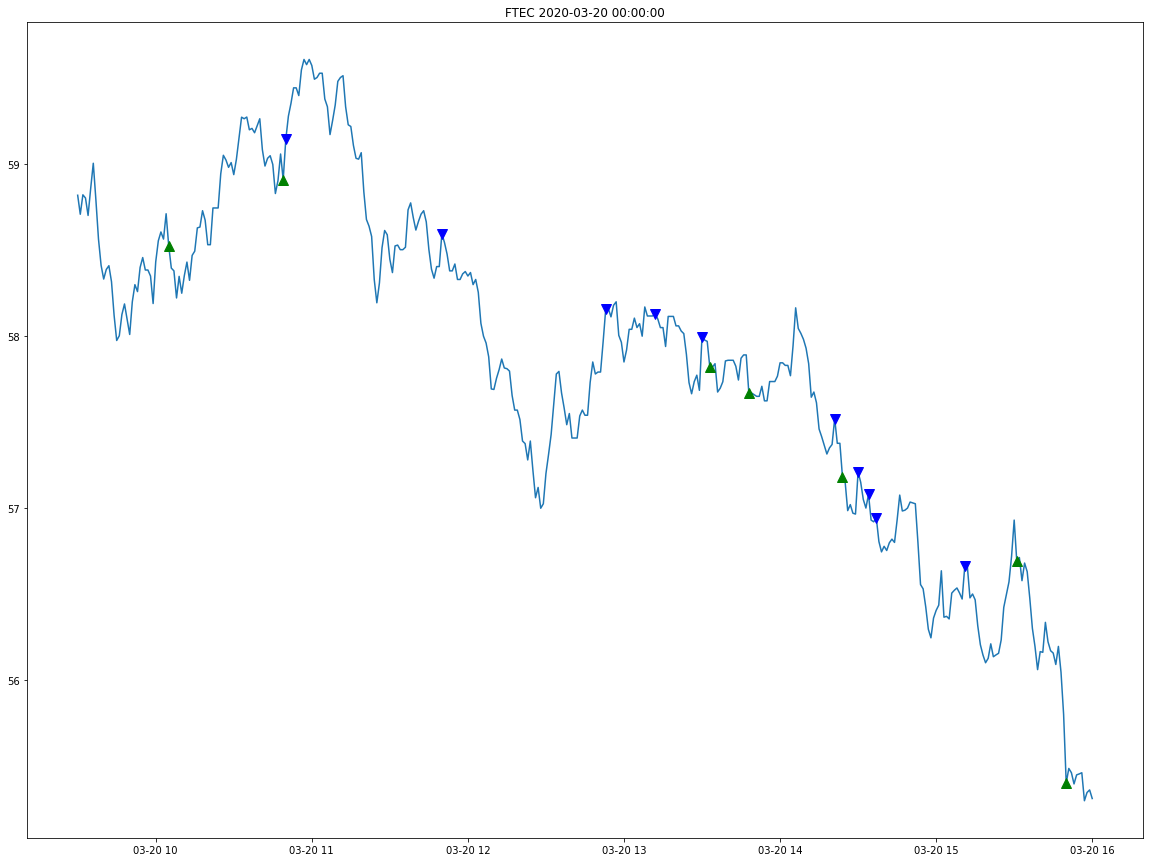

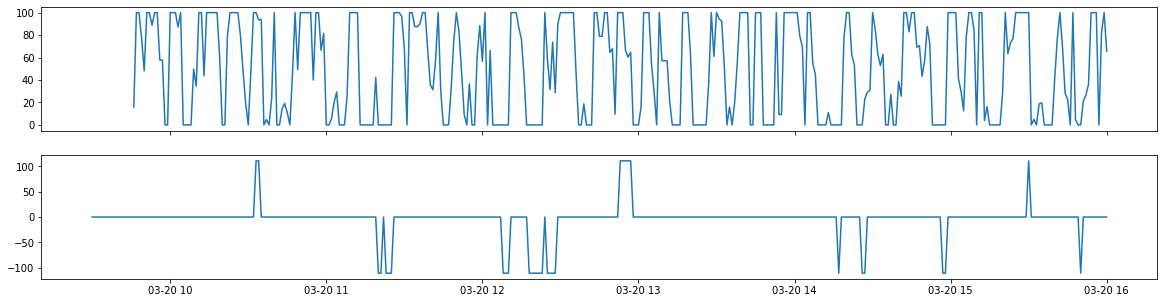

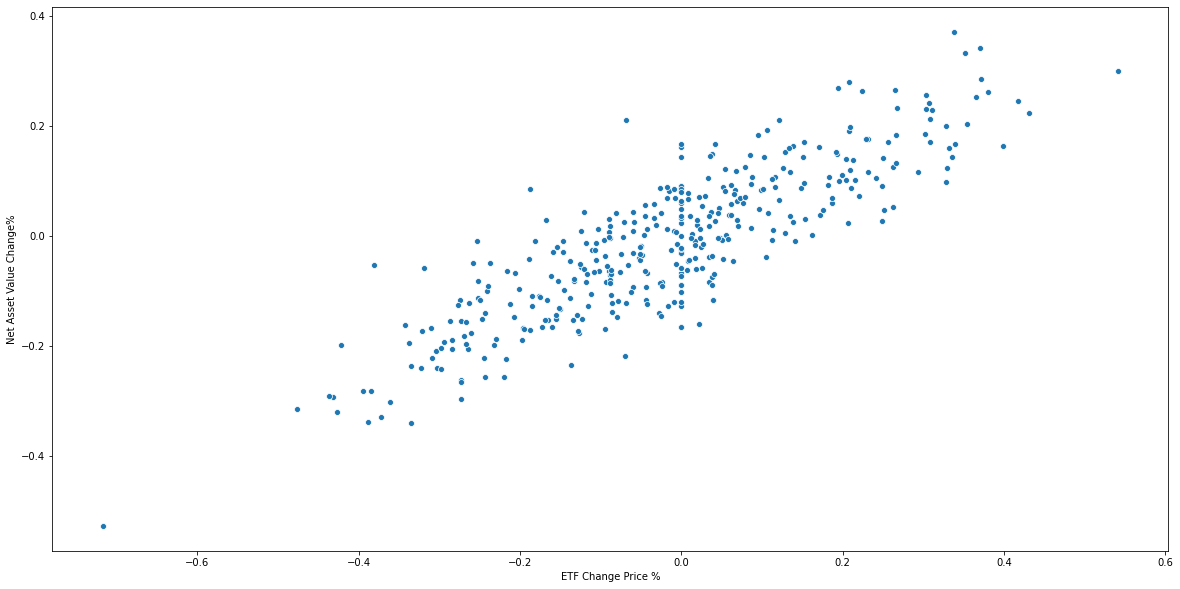

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-03-23     MSFT   38.686131         61.313869          
5   2020-03-23     INTC   41.250000         58.750000          
16  2020-03-23     V      32.467532         67.532468          
3   2020-03-23     MA     43.750000         56.250000          
13  2020-03-23     CSCO   44.444444         55.555556          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  50.000000         50.000000         273            137        136        
5   56.756757         43.243243         154            80         74         
16  50.000000         50.000000         147            77         70         
3   50.000000         50.000000         92             48         44         
13  56.666667         43.333333         57             27         30

ETF Name =FTEC
Date =2020-03-23 00:00:00
Sell Positions Probability
T+1    0.55
T+2    0.50
T+3    0.60
T+4    0.60
T+5    0.45
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-23 09:32:00  0.289173                 0.315625        0            
2020-03-23 10:07:00  0.090358                 0.113918        Weak Trend   
2020-03-23 10:18:00  0.078861                 0.145396        Weak Trend   
2020-03-23 10:24:00  0.066430                 0.301936        Weak Trend   
2020-03-23 10:51:00  0.067045                 0.092816        No Trend     
2020-03-23 11:32:00  0.066146                 0.100289        Weak Trend   
2020-03-23 11:43:00  0.072663                 0.126553        Weak Trend   
2020-03-23 11:52:00  0.062063                 0.098881        Weak Trend   
2020-03-23 12:15:00  0.078844                 0.104286        No Trend     
2020-03-23 12:35:00  0.102905                 0.200953        No Trend     
2020-03-23 13:49:00  0.102021                 0.186696        No Trend     
2020-03-23 13:56:00  0.120962                 0.256358        No Trend     
2020-03-23 14:04:00  0.109927                 0.152428        Weak Trend   
2020-03-23 14:07:00  0.107143                 0.130439        No Trend     
2020-03-23 14:22:00  0.082883                 0.106408        No Trend     
2020-03-23 14:49:00  0.078377                 0.173109        No Trend     
2020-03-23 15:02:00  0.071073                 0.098255        No Trend     
2020-03-23 15:36:00  0.061074                 0.121962        No Trend     
2020-03-23 15:53:00  0.079859                 0.125385        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  ULTOC Indicator  \
2020-03-23 09:32:00  NaN               0.0                 0.0               
2020-03-23 10:07:00  NaN               111.0               0.0               
2020-03-23 10:18:00  NaN              -111.0               0.0               
2020-03-23 10:24:00  Strong Downtrend -111.0               0.0               
2020-03-23 10:51:00  Downtrend        -111.0               0.0               
2020-03-23 11:32:00  NaN               111.0               0.0               
2020-03-23 11:43:00  Strong Downtrend -111.0               0.0               
2020-03-23 11:52:00  Uptrend           111.0               111.0             
2020-03-23 12:15:00  NaN               111.0               0.0               
2020-03-23 12:35:00  NaN               111.0               0.0               
2020-03-23 13:49:00  NaN               111.0               0.0               
2020-03-23 13:56:00  NaN              -111.0               0.0               
2020-03-23 14:04:00  Strong Downtrend -111.0               0.0               
2020-03-23 14:07:00  NaN               111.0               0.0               
2020-03-23 14:22:00  NaN              -111.0               0.0               
2020-03-23 14:49:00  Strong Uptrend    111.0               111.0             
2020-03-23 15:02:00  NaN              -111.0               0.0               
2020-03-23 15:36:00  Downtrend         111.0               0.0               
2020-03-23 15:53:00  NaN               111.0               0.0               
Total Return         NaN              NaN                 NaN                

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-03-23 09:32:00  0.0                   0.0              0.0             
2020-03-23 10:07:00  111.0                 111.0           -111.0           
2020-03-23 10:18:00 -111.0                 0.0              0.0             
2020-03-23 10:24:00  111.0                 0.0             -111.0           
2020-03-23 10:51:00  111.0                 0.0              0.0             
2020-03-23 11:32:00  111.0                 111.0            0.0             
2020-03-23 11:43:00  0.0                   0.0              0.0             
2020-03-23 11:52:00  111.0                 111.0            0.0             
2020-03-23 12:15:00  111.0                 111.0            0.0             
2020-03-23 12:3

******************
Buy Positions Probability
T+1    0.500000
T+2    0.545455
T+3    0.590909
T+4    0.363636
T+5    0.500000
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-23 09:31:00  0.273333                -0.329669        0            
2020-03-23 09:52:00  0.095395                -0.118111        No Trend     
2020-03-23 10:08:00  0.087586                -0.112923        No Trend     
2020-03-23 10:19:00  0.078184                -0.173665        Weak Trend   
2020-03-23 10:22:00  0.065886                -0.139169        Weak Trend   
2020-03-23 10:23:00  0.063482                -0.131891        Weak Trend   
2020-03-23 10:54:00  0.065903                -0.097649        No Trend     
2020-03-23 11:08:00  0.060804                -0.088998        No Trend     
2020-03-23 11:44:00  0.065041                -0.175677        Weak Trend   
2020-03-23 13:23:00  0.101380                -0.144781        Weak Trend   
2020-03-23 13:26:00  0.075285                -0.100417        No Trend     
2020-03-23 13:30:00  0.086760                -0.213370        No Trend     
2020-03-23 13:38:00  0.088149                -0.119467        No Trend     
2020-03-23 13:54:00  0.099391                -0.155047        No Trend     
2020-03-23 13:57:00  0.110996                -0.388932        No Trend     
2020-03-23 14:21:00  0.099656                -0.204533        No Trend     
2020-03-23 14:50:00  0.099929                -0.140262        No Trend     
2020-03-23 15:01:00  0.064037                -0.126396        No Trend     
2020-03-23 15:18:00  0.079005                -0.151502        No Trend     
2020-03-23 15:23:00  0.071199                -0.103126        No Trend     
2020-03-23 15:48:00  0.070107                -0.106818        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-23 09:31:00  NaN               0.0                 0.0             
2020-03-23 09:52:00  Strong Uptrend    111.0               0.0             
2020-03-23 10:08:00  NaN               111.0               0.0             
2020-03-23 10:19:00  Downtrend        -111.0               0.0             
2020-03-23 10:22:00  Strong Downtrend -111.0               0.0             
2020-03-23 10:23:00  Strong Downtrend -111.0               0.0             
2020-03-23 10:54:00  Strong Downtrend -111.0               0.0             
2020-03-23 11:08:00  NaN              -111.0               0.0             
2020-03-23 11:44:00  Strong Downtrend -111.0              -111.0           
2020-03-23 13:23:00  Strong Downtrend -111.0               0.0             
2020-03-23 13:26:00  NaN              -111.0               0.0             
2020-03-23 13:30:00  Strong Downtrend -111.0               0.0             
2020-03-23 13:38:00  NaN              -111.0               0.0             
2020-03-23 13:54:00  NaN              -111.0               0.0             
2020-03-23 13:57:00  Strong Downtrend -111.0               0.0             
2020-03-23 14:21:00  NaN              -111.0               0.0             
2020-03-23 14:50:00  Strong Uptrend    111.0               0.0             
2020-03-23 15:01:00  Strong Downtrend -111.0               0.0             
2020-03-23 15:18:00  NaN              -111.0               0.0             
2020-03-23 15:23:00  Downtrend        -111.0               0.0             
2020-03-23 15:48:00  Uptrend          -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  Stochastic Indicator  WILLR Indicator  \
2020-03-23 09:31:00  0.0            0.0                   0.0               
2020-03-23 09:52:00  0.0            111.0                 111.0             
2020-03-23 10:08:00  0.0            0.0                   0.0               
2020-03-23 10:19:00  0.0           -111.0                -111.0             
2020-03-23 10:22:00  0.0           -111.0                -111.0             
2020-03-23 10:23:00  0.0           -111.0                -111

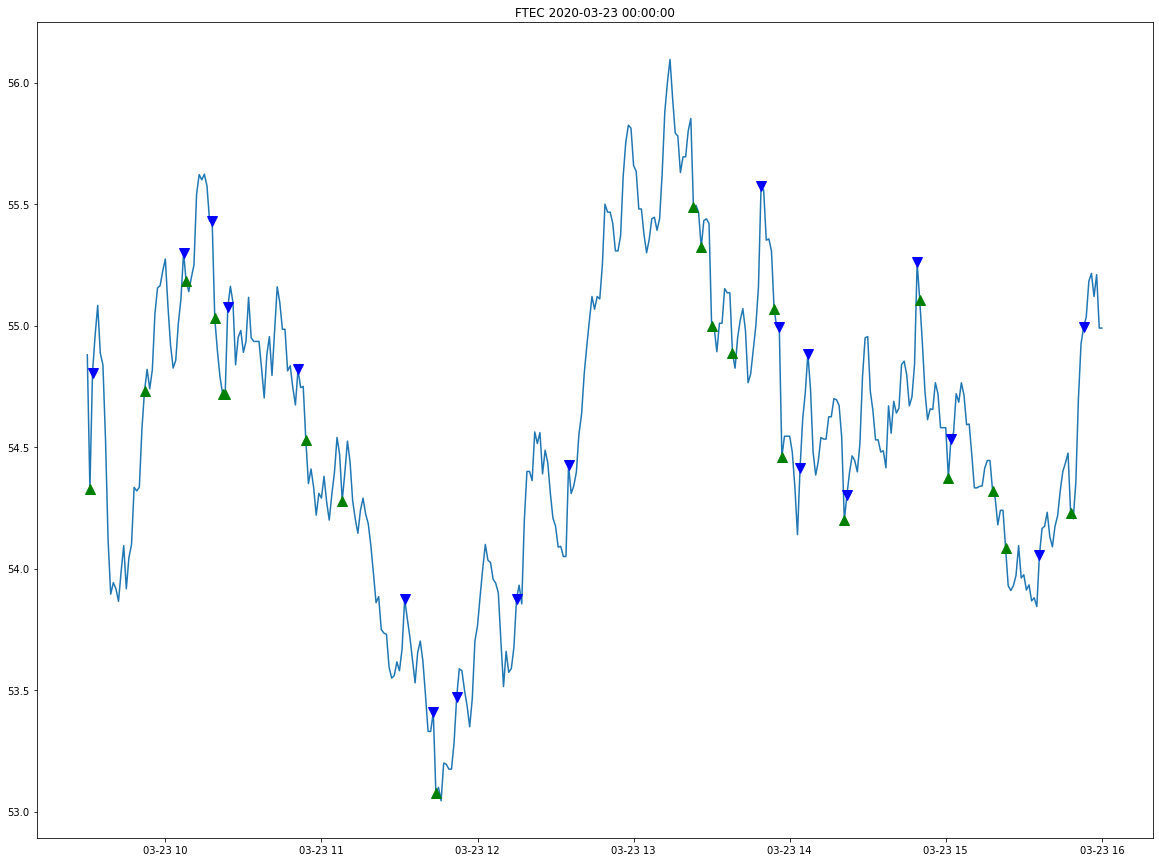

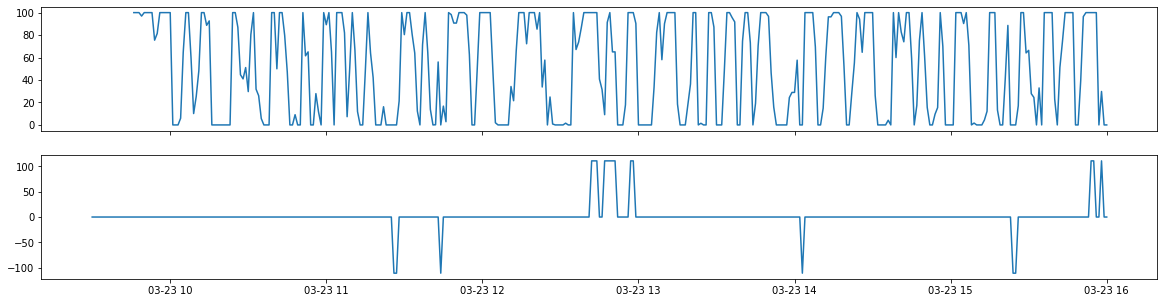

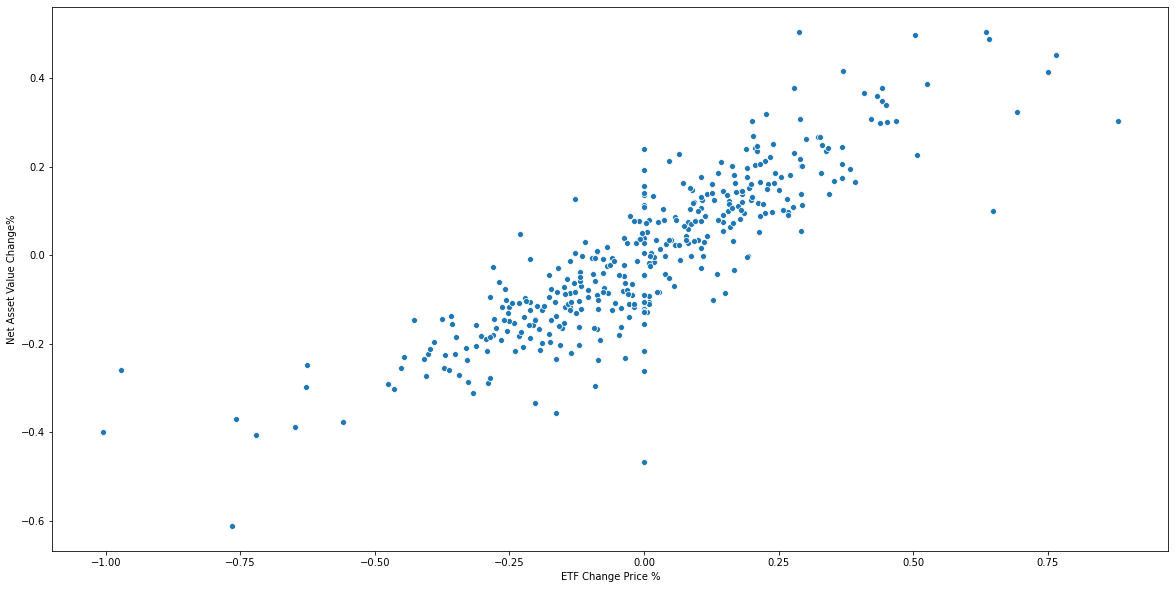

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-03-24     MSFT   50.574713         49.425287          
6   2020-03-24     INTC   53.846154         46.153846          
16  2020-03-24     V      40.384615         59.615385          
3   2020-03-24     MA     55.813953         44.186047          
4   2020-03-24     NVDA   42.857143         57.142857          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  56.521739         43.478261         179            87         92         
6   48.076923         51.923077         104            52         52         
16  58.695652         41.304348         98             52         46         
3   53.488372         46.511628         86             43         43         
4   44.444444         55.555556         39             21         18

ETF Name =FTEC
Date =2020-03-24 00:00:00
Sell Positions Probability
T+1    0.500
T+2    0.500
T+3    0.750
T+4    0.625
T+5    0.625
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-24 10:41:00  0.062964                 0.083187        No Trend     
2020-03-24 11:01:00  0.047320                 0.087029        No Trend     
2020-03-24 11:16:00  0.057855                 0.100523        No Trend     
2020-03-24 11:41:00  0.050217                 0.072441        Weak Trend   
2020-03-24 13:03:00  0.044234                 0.072890        Weak Trend   
2020-03-24 13:30:00  0.061378                 0.084386        Weak Trend   
2020-03-24 14:41:00  0.058266                 0.165374        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-24 10:41:00  NaN             111.0               0.0             
2020-03-24 11:01:00  Strong Uptrend  111.0               0.0             
2020-03-24 11:16:00  Strong Uptrend  111.0               0.0             
2020-03-24 11:41:00  Strong Uptrend  111.0               111.0           
2020-03-24 13:03:00  NaN            -111.0               0.0             
2020-03-24 13:30:00  Strong Uptrend  111.0               0.0             
2020-03-24 14:41:00  Strong Uptrend  111.0               111.0           
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-24 10:41:00  0.0            0.0              111.0                  
2020-03-24 11:01:00  0.0            0.0              111.0                  
2020-03-24 11:16:00  0.0            0.0              111.0                  
2020-03-24 11:41:00  111.0          111.0            111.0                  
2020-03-24 13:03:00  0.0            0.0              111.0                  
2020-03-24 13:30:00  0.0            0.0              111.0                  
2020-03-24 14:41:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  \
2020-03-24 10:41:00  111.0            111.0           
2020-03-24 11:01:00  111.0            111.0           
2020-03-24 11:16:00  111.0            111.0           
2020-03-24 11:41:00  111.0            111.0           
2020-03-24 13:03:00  0.0              0.0             
2020-03-24 13:30:00  111.0            111.0           
2020-03-24 14:41:00  111.0            111.0           
Total Return        NaN              NaN              

                     IndecisionSpinningTop Pat  IndecisionDoji Pat       T+1  \
2020-03-24 10:41:00 -111.0                     -111.0              -0.033687   
2020-03-24 11:01:00  0.0                        0.0                 0.075898   
2020-03-24 11:16:00  0.0                        0.0                 0.076071   
2020-03-24 11:41:00  0.0                        0.0                -0.158956   
2020-03-24 13:03:00  0.0                        0.0                -0.276544   
2020-03-24 13:30:00  0.0                        0.0                 0.042045   
2020-03-24 14:41:00  0.0                        0.0                 0.064258   
Total Return        NaN                        NaN                 -0.210914   

                          T+2       T+3       T+4       T+5  
2020-03-24 10:41:00  0.084246 -0.033670 -0.050606 -0.109436  
2020-03-24 11:01:00  0.025112 -0.161584 -0.394910 -0.135547  
2020-03-24 11:16:00 -0.059122 -0.067608  0.042199  0.093069  
2020-03-24 11:41:00  0.040473  0.014993 -0.097315  0.100595  
2020-03-24 13:03:00 -0.176471 -0.017257 -0.302687  0.160459  
2020-03-24 13:30:00  0.025132 -0.025126  0.030596 -0.035628  
2020-03-24 14:41:00 -0.159827  0.045184  0.060667 -0.220628  
Total Return        -0.220456 -0.245068 -0.712056 -0.147116

******************
Buy Positions Probability
T+1    0.7
T+2    0.4
T+3    0.7
T+4    1.0
T+5    0.4
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-24 10:29:00  0.075191                -0.103713        Weak Trend   
2020-03-24 10:37:00  0.060673                -0.082477        No Trend     
2020-03-24 10:55:00  0.059179                -0.079849        Weak Trend   
2020-03-24 11:05:00  0.055225                -0.103812        No Trend     
2020-03-24 11:52:00  0.054725                -0.083016        Weak Trend   
2020-03-24 13:07:00  0.045239                -0.079438        Weak Trend   
2020-03-24 13:20:00  0.045142                -0.079717        Weak Trend   
2020-03-24 14:14:00  0.063587                -0.087701        Weak Trend   
2020-03-24 15:36:00  0.047521                -0.072349        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-24 10:29:00  Strong Uptrend    111.0               0.0             
2020-03-24 10:37:00  NaN              -111.0               0.0             
2020-03-24 10:55:00  NaN              -111.0               0.0             
2020-03-24 11:05:00  NaN              -111.0               0.0             
2020-03-24 11:52:00  NaN              -111.0               0.0             
2020-03-24 13:07:00  Strong Downtrend -111.0              -111.0           
2020-03-24 13:20:00  Downtrend        -111.0               0.0             
2020-03-24 14:14:00  Downtrend        -111.0               0.0             
2020-03-24 15:36:00  NaN              -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  Stochastic Indicator  WILLR Indicator  \
2020-03-24 10:29:00  0.0           -111.0                 0.0               
2020-03-24 10:37:00  0.0           -111.0                -111.0             
2020-03-24 10:55:00  0.0            0.0                  -111.0             
2020-03-24 11:05:00  0.0           -111.0                -111.0             
2020-03-24 11:52:00  0.0            0.0                   0.0               
2020-03-24 13:07:00 -111.0         -111.0                -111.0             
2020-03-24 13:20:00  0.0           -111.0                -111.0             
2020-03-24 14:14:00  0.0            0.0                   0.0               
2020-03-24 15:36:00  0.0           -111.0                -111.0             
Total Return        NaN            NaN                   NaN                

                     MFI Indicator  IndecisionSpinningTop Pat  \
2020-03-24 10:29:00  111.0         -111.0                       
2020-03-24 10:37:00  111.0          0.0                         
2020-03-24 10:55:00  0.0            0.0                         
2020-03-24 11:05:00  111.0          0.0                         
2020-03-24 11:52:00 -111.0          0.0                         
2020-03-24 13:07:00 -111.0          0.0                         
2020-03-24 13:20:00  0.0            0.0                         
2020-03-24 14:14:00  0.0            0.0                         
2020-03-24 15:36:00  0.0            0.0                         
Total Return        NaN            NaN                          

                     IndecisionDoji Pat       T+1       T+2       T+3  \
2020-03-24 10:29:00 -111.0              -0.198003 -0.079612  0.045879   
2020-03-24 10:37:00  0.0                 0.228098  0.059002 -0.167972   
2020-03-24 10:55:00  0.0                 0.169535 -0.114242 -0.046596   
2020-03-24 11:05:00  0.0                -0.135547 -0.254496  0.187107   
2020-03-24 11:52:00  0.0                 0.178594  0.044045  0.110524   
2020-03-24 13:07:00  0.0                 0.160459 -0.143339 -0.143629   
2020-03-24 13:20:00  0.0                -0.031774 -0.052974  0.076323   
2020-03-24 14:14:00 -111.0               0.188421  0.269277  0.140671   
2020-03-24 15:36:00  0.0                 0.133662  0.091629  0.083299   
Total Return        NaN                  0.693444 -0.

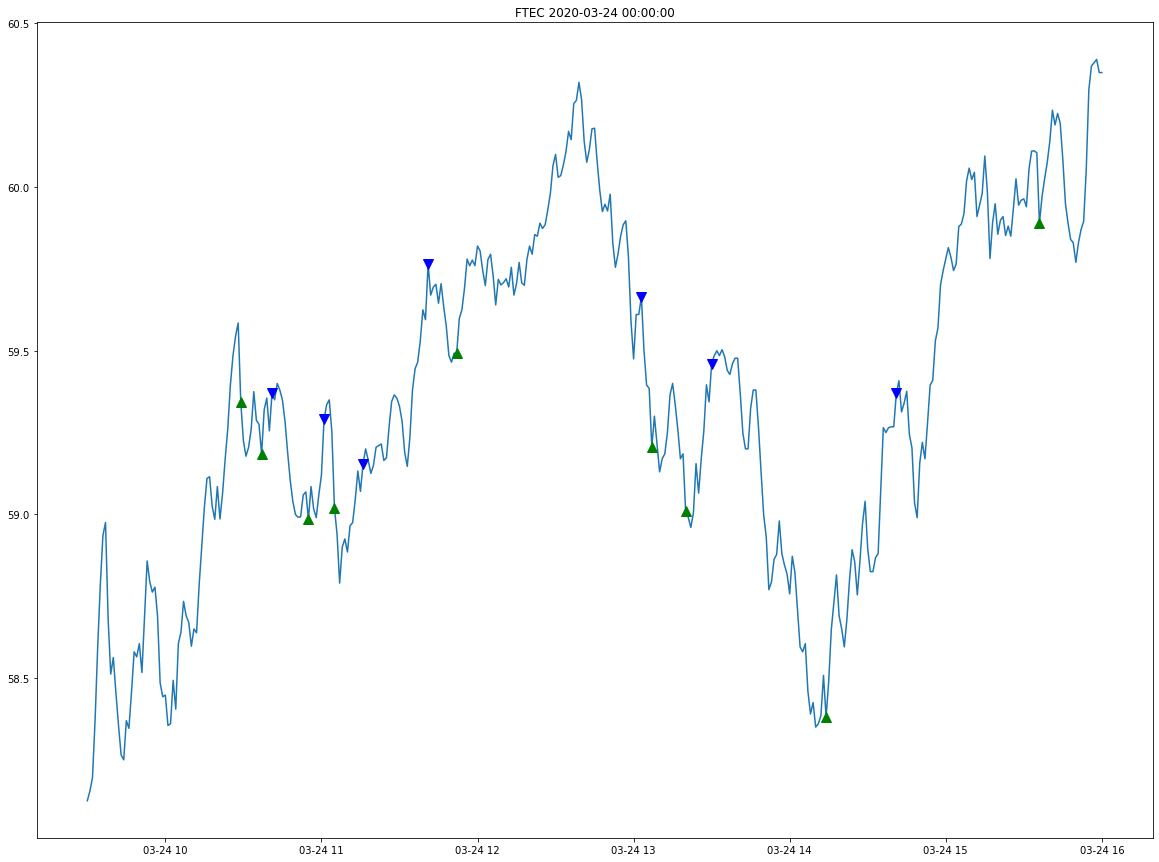

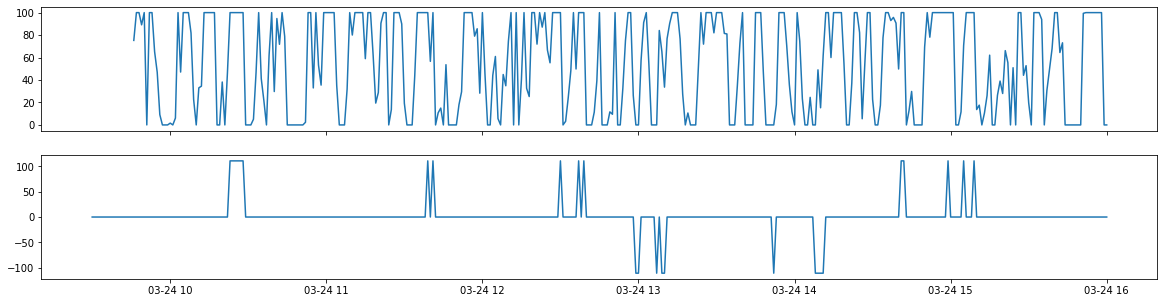

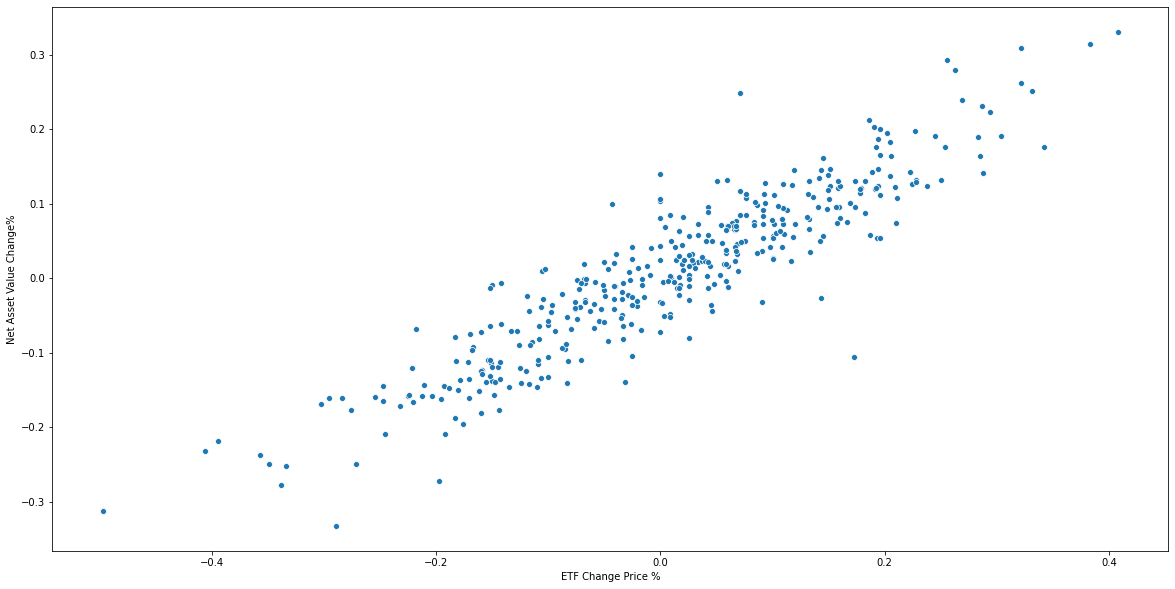

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-03-25     MSFT   48.113208         51.886792          
16  2020-03-25     V      43.076923         56.923077          
2   2020-03-25     MA     50.000000         50.000000          
3   2020-03-25     INTC   42.222222         57.777778          
1   2020-03-25     NVDA   53.846154         46.153846          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  44.715447         55.284553         229            106        123        
16  42.857143         57.142857         135            65         70         
2   49.230769         50.769231         125            60         65         
3   36.666667         63.333333         105            45         60         
1   56.000000         44.000000         38             13         25

ETF Name =FTEC
Date =2020-03-25 00:00:00
Sell Positions Probability
T+1    0.533333
T+2    0.533333
T+3    0.600000
T+4    0.400000
T+5    0.533333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-25 10:22:00  0.092106                 0.123930        Weak Trend   
2020-03-25 10:30:00  0.119921                 0.309530        Weak Trend   
2020-03-25 10:46:00  0.093257                 0.139592        Weak Trend   
2020-03-25 10:52:00  0.090256                 0.241901        No Trend     
2020-03-25 11:07:00  0.072474                 0.107347        Weak Trend   
2020-03-25 11:15:00  0.071321                 0.122591        No Trend     
2020-03-25 11:18:00  0.079399                 0.225395        No Trend     
2020-03-25 11:38:00  0.086040                 0.113327        No Trend     
2020-03-25 12:22:00  0.061103                 0.083191        Weak Trend   
2020-03-25 12:35:00  0.065817                 0.086811        Weak Trend   
2020-03-25 13:51:00  0.057011                 0.079268        Weak Trend   
2020-03-25 14:46:00  0.041039                 0.088329        No Trend     
2020-03-25 14:55:00  0.051640                 0.082006        No Trend     
2020-03-25 15:34:00  0.057284                 0.082055        No Trend     
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  ULTOC Indicator  \
2020-03-25 10:22:00  Strong Uptrend  111.0               111.0             
2020-03-25 10:30:00  Strong Uptrend  111.0               0.0               
2020-03-25 10:46:00  Uptrend         111.0               0.0               
2020-03-25 10:52:00  Downtrend       111.0               0.0               
2020-03-25 11:07:00  Strong Uptrend  111.0               0.0               
2020-03-25 11:15:00  NaN            -111.0               0.0               
2020-03-25 11:18:00  NaN             111.0               0.0               
2020-03-25 11:38:00  Strong Uptrend  111.0               0.0               
2020-03-25 12:22:00  Strong Uptrend  111.0               0.0               
2020-03-25 12:35:00  NaN            -111.0               0.0               
2020-03-25 13:51:00  Uptrend         111.0               0.0               
2020-03-25 14:46:00  Strong Uptrend  111.0               0.0               
2020-03-25 14:55:00  NaN             111.0               0.0               
2020-03-25 15:34:00  Uptrend         111.0               0.0               
Total Return         NaN            NaN                 NaN                

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-03-25 10:22:00  111.0                 111.0            0.0             
2020-03-25 10:30:00  111.0                 111.0            0.0             
2020-03-25 10:46:00  0.0                   0.0              111.0           
2020-03-25 10:52:00  111.0                 111.0            0.0             
2020-03-25 11:07:00  111.0                 111.0            0.0             
2020-03-25 11:15:00 -111.0                -111.0            0.0             
2020-03-25 11:18:00  111.0                 111.0           -111.0           
2020-03-25 11:38:00  111.0                 111.0            0.0             
2020-03-25 12:22:00  111.0                 111.0            111.0           
2020-03-25 12:35:00  111.0                 0.0              0.0             
2020-03-25 13:51:00  0.0                   0.0              0.0             
2020-03-25 14:46:00  111.0                 111.0            0.0             
2020-03-25 14:55:00  111.0                 111.0            0.0             
2020-03-25 15:34:00  111.0                 111.0            0.0             
Total Return        NaN                   NaN              NaN              

                     DragonFlyDoji Pat  HanginMan Pat  Shooting Pat  \
2020-03-25 10:22:00  0.0                0.0            0.0            
2020-03-25 10:30:00  0.0                0.0            0.0            
2020-03-25 10:46:00  0.0                0.0            0.0            
2020-03-25 10:52:00  0.0                0.0            0.0            

******************
Buy Positions Probability
T+1    0.4375
T+2    0.5625
T+3    0.5625
T+4    0.3125
T+5    0.5625
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-03-25 10:29:00  0.100901                -0.123477        Weak Trend     
2020-03-25 10:47:00  0.102538                -0.132929        Weak Trend     
2020-03-25 10:51:00  0.099632                -0.129015        No Trend       
2020-03-25 11:17:00  0.071753                -0.099999        No Trend       
2020-03-25 11:21:00  0.077925                -0.139446        No Trend       
2020-03-25 11:39:00  0.080154                -0.139816        No Trend       
2020-03-25 12:10:00  0.069444                -0.115557        Weak Trend     
2020-03-25 12:34:00  0.064427                -0.093224        Weak Trend     
2020-03-25 12:54:00  0.049041                -0.086405        Weak Trend     
2020-03-25 13:49:00  0.063655                -0.101088        Weak Trend     
2020-03-25 14:52:00  0.042173                -0.110929        No Trend       
2020-03-25 15:35:00  0.059270                -0.110163        No Trend       
2020-03-25 15:43:00  0.059039                -0.090344        No Trend       
2020-03-25 15:45:00  0.066377                -0.087049        Weak Trend     
2020-03-25 15:52:00  0.076003                -0.097185        Strong Trend   
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-25 10:29:00  NaN              -111.0               0.0             
2020-03-25 10:47:00  NaN              -111.0               0.0             
2020-03-25 10:51:00  Downtrend        -111.0               0.0             
2020-03-25 11:17:00  Strong Downtrend -111.0               0.0             
2020-03-25 11:21:00  NaN              -111.0               0.0             
2020-03-25 11:39:00  NaN              -111.0               0.0             
2020-03-25 12:10:00  NaN              -111.0               0.0             
2020-03-25 12:34:00  NaN              -111.0               0.0             
2020-03-25 12:54:00  NaN              -111.0               0.0             
2020-03-25 13:49:00  Strong Uptrend   -111.0               0.0             
2020-03-25 14:52:00  NaN              -111.0               0.0             
2020-03-25 15:35:00  Uptrend           111.0               0.0             
2020-03-25 15:43:00  Strong Downtrend -111.0               0.0             
2020-03-25 15:45:00  Downtrend        -111.0              -111.0           
2020-03-25 15:52:00  Strong Downtrend -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  Stochastic Indicator  WILLR Indicator  \
2020-03-25 10:29:00  0.0           -111.0                -111.0             
2020-03-25 10:47:00  0.0           -111.0                -111.0             
2020-03-25 10:51:00  0.0            111.0                 0.0               
2020-03-25 11:17:00  0.0           -111.0                 0.0               
2020-03-25 11:21:00  0.0            0.0                   0.0               
2020-03-25 11:39:00  0.0           -111.0                -111.0             
2020-03-25 12:10:00  0.0           -111.0                 0.0               
2020-03-25 12:34:00  0.0            0.0                   0.0               
2020-03-25 12:54:00  0.0           -111.0                -111.0             
2020-03-25 13:49:00  0.0           -111.0                -111.0             
2020-03-25 14:52:00  0.0           -111.0                -111.0             
2020-03-25 15:35:00  0.0           -111.0                 0.0               
2020-03-25 15:43:00  0.0           -111.0                -111.0             
2020-03-25 15:45:00 -111.0         -111.0                -111.0             
2020-03-25 15:52:00 -111.0         -111.0                -111.0             
Total Return        NaN            NaN                   NaN                

                     MFI Indicator  Hammer Pat  IndecisionSpinningTop Pat  \
2020-03-25 10:

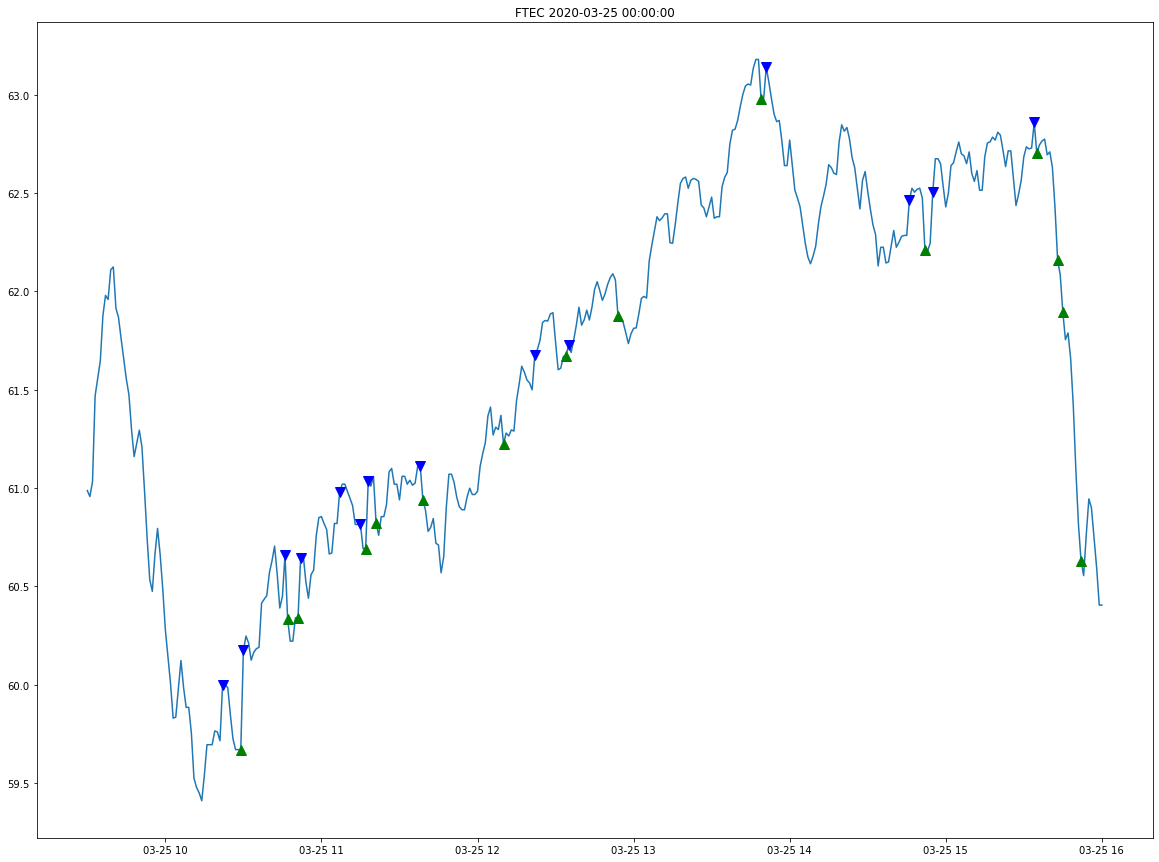

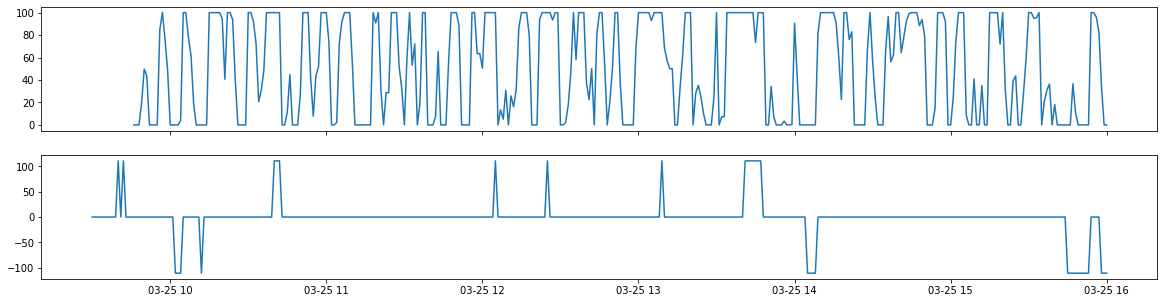

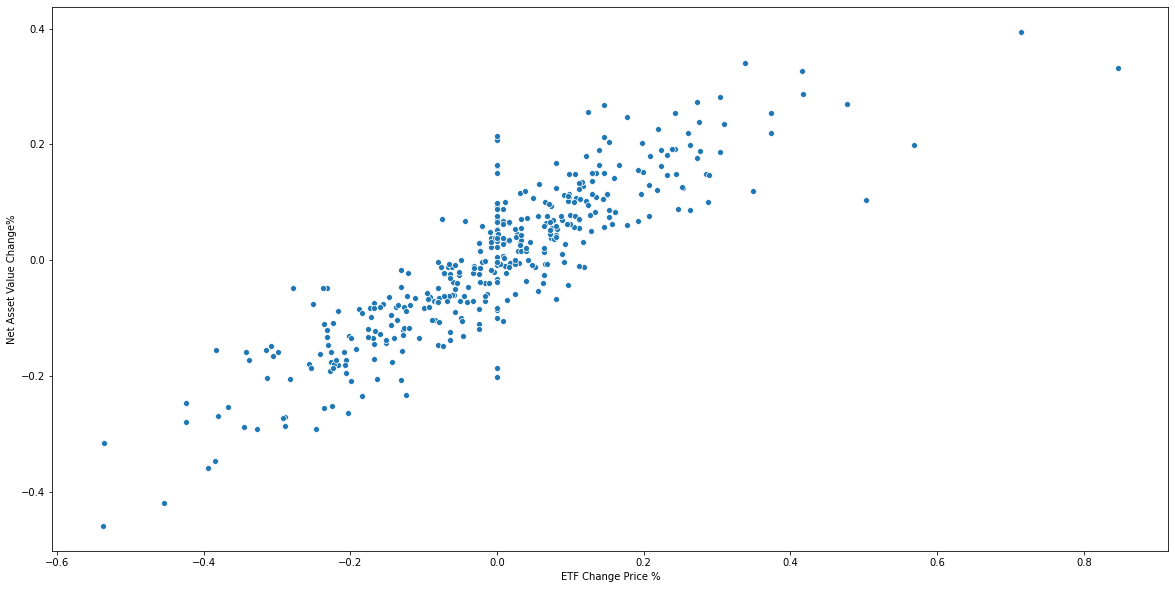

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-03-26     MSFT   54.285714         45.714286          
6   2020-03-26     V      54.237288         45.762712          
7   2020-03-26     INTC   52.173913         47.826087          
0   2020-03-26     MA     50.000000         50.000000          
5   2020-03-26     CSCO   61.904762         38.095238          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  51.190476         48.809524         189            105        84         
6   56.250000         43.750000         107            59         48         
7   50.000000         50.000000         90             46         44         
0   51.219512         48.780488         89             48         41         
5   56.250000         43.750000         37             21         16

ETF Name =FTEC
Date =2020-03-26 00:00:00
Sell Positions Probability
T+1    0.500
T+2    0.500
T+3    0.375
T+4    0.250
T+5    0.250
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-26 09:55:00  0.121777                 0.285886        No Trend     
2020-03-26 10:20:00  0.099157                 0.122596        Weak Trend   
2020-03-26 10:51:00  0.092616                 0.117850        No Trend     
2020-03-26 13:43:00  0.045620                 0.109496        Weak Trend   
2020-03-26 13:48:00  0.052509                 0.088676        No Trend     
2020-03-26 14:13:00  0.062604                 0.107031        No Trend     
2020-03-26 15:19:00  0.040280                 0.065630        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  \
2020-03-26 09:55:00  NaN               111.0                
2020-03-26 10:20:00  Strong Uptrend    111.0                
2020-03-26 10:51:00  NaN              -111.0                
2020-03-26 13:43:00  Strong Uptrend    111.0                
2020-03-26 13:48:00  NaN               111.0                
2020-03-26 14:13:00  Downtrend        -111.0                
2020-03-26 15:19:00  Strong Downtrend  111.0                
Total Return         NaN              NaN                   

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-03-26 09:55:00  111.0                 111.0            0.0             
2020-03-26 10:20:00  111.0                 0.0              111.0           
2020-03-26 10:51:00  111.0                 0.0              0.0             
2020-03-26 13:43:00  111.0                 111.0            0.0             
2020-03-26 13:48:00  0.0                   0.0              0.0             
2020-03-26 14:13:00  0.0                   0.0              0.0             
2020-03-26 15:19:00  111.0                 111.0            0.0             
Total Return        NaN                   NaN              NaN              

                     MorningStar Pat  MorningStarDoji Pat  AbandonedBaby Pat  \
2020-03-26 09:55:00  0.0              0.0                  0.0                 
2020-03-26 10:20:00  0.0              0.0                  0.0                 
2020-03-26 10:51:00  0.0              0.0                  0.0                 
2020-03-26 13:43:00 -111.0           -111.0               -111.0               
2020-03-26 13:48:00  0.0              0.0                  0.0                 
2020-03-26 14:13:00  0.0              0.0                  0.0                 
2020-03-26 15:19:00  0.0              0.0                  0.0                 
Total Return        NaN              NaN                  NaN                  

                     AbandonedBaby Pat  IndecisionDoji Pat       T+1  \
2020-03-26 09:55:00  0.0                0.0                 0.075825   
2020-03-26 10:20:00  0.0                0.0                -0.206562   
2020-03-26 10:51:00  0.0               -111.0              -0.154151   
2020-03-26 13:43:00 -111.0              0.0                 0.056552   
2020-03-26 13:48:00  0.0                0.0                 0.091644   
2020-03-26 14:13:00  0.0               -111.0               0.063899   
2020-03-26 15:19:00  0.0                0.0                -0.006023   
Total Return        NaN                NaN                 -0.078815   

                          T+2       T+3       T+4       T+5  
2020-03-26 09:55:00  0.088570  0.012148  0.168838  0.048181  
2020-03-26 10:20:00 -0.055728  0.015931  0.007964 -0.143426  
2020-03-26 10:51:00 -0.152305  0.000000  0.048491  0.095971  
2020-03-26 13:43:00 -0.107467 -0.107583 -0.128520  0.236523  
2020-03-26 13:48:00  0.095541 -0.039771  0.214848  0.064952  
2020-03-26 14:13:00  0.000000  0.000000 -0.039812  0.153338  
2020-03-26 15:19:00  0.006024  0.079252  0.000000 -0.125673  
Total Return        -0.125364 -0.040023  0.271810  0.329865

******************
Buy Positions Probability
T+1    0.583333
T+2    0.666667
T+3    0.750000
T+4    0.500000
T+5    0.333333
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-26 09:54:00  0.134045                -0.168880        No Trend     
2020-03-26 11:06:00  0.087354                -0.117027        No Trend     
2020-03-26 12:14:00  0.059907                -0.089403        No Trend     
2020-03-26 13:08:00  0.053578                -0.084021        Weak Trend   
2020-03-26 13:27:00  0.043698                -0.065731        Weak Trend   
2020-03-26 13:34:00  0.054021                -0.080543        Weak Trend   
2020-03-26 13:39:00  0.051716                -0.105084        Weak Trend   
2020-03-26 13:47:00  0.048345                -0.072911        No Trend     
2020-03-26 14:06:00  0.058079                -0.090354        Weak Trend   
2020-03-26 14:11:00  0.052008                -0.117865        No Trend     
2020-03-26 15:37:00  0.049608                -0.093105        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-26 09:54:00  NaN              -111.0               0.0             
2020-03-26 11:06:00  Strong Uptrend   -111.0               0.0             
2020-03-26 12:14:00  Strong Downtrend -111.0               0.0             
2020-03-26 13:08:00  NaN              -111.0               0.0             
2020-03-26 13:27:00  Strong Downtrend -111.0               0.0             
2020-03-26 13:34:00  Downtrend        -111.0              -111.0           
2020-03-26 13:39:00  NaN              -111.0               0.0             
2020-03-26 13:47:00  NaN              -111.0               0.0             
2020-03-26 14:06:00  Strong Uptrend   -111.0               0.0             
2020-03-26 14:11:00  NaN              -111.0               0.0             
2020-03-26 15:37:00  NaN              -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  Stochastic Indicator  WILLR Indicator  \
2020-03-26 09:54:00  0.0            111.0                 0.0               
2020-03-26 11:06:00  0.0           -111.0                 0.0               
2020-03-26 12:14:00  0.0           -111.0                -111.0             
2020-03-26 13:08:00  0.0           -111.0                -111.0             
2020-03-26 13:27:00  0.0            0.0                  -111.0             
2020-03-26 13:34:00 -111.0          0.0                  -111.0             
2020-03-26 13:39:00  0.0           -111.0                 0.0               
2020-03-26 13:47:00  0.0           -111.0                 0.0               
2020-03-26 14:06:00  0.0           -111.0                 0.0               
2020-03-26 14:11:00  0.0            0.0                  -111.0             
2020-03-26 15:37:00  0.0           -111.0                -111.0             
Total Return        NaN            NaN                   NaN                

                     MFI Indicator  IndecisionDoji Pat       T+1       T+2  \
2020-03-26 09:54:00  0.0            0.0                 0.682216  0.075825   
2020-03-26 11:06:00  0.0            0.0                -0.176028  0.200385   
2020-03-26 12:14:00  0.0            0.0                -0.094633 -0.008582   
2020-03-26 13:08:00  0.0            0.0                 0.030836 -0.118868   
2020-03-26 13:27:00  0.0            0.0                 0.012753  0.011158   
2020-03-26 13:34:00  0.0            0.0                 0.165378  0.022878   
2020-03-26 13:39:00 -111.0         -111.0               0.288092  0.007980   
2020-03-26 13:47:00 -111.0          0.0                 0.236523  0.091644   
2020-03-26 14:06:00  0.0            0.0                -0.090053 -0.165711   
2020-03-26 14:11:00  0.0           -111.0              -0.234947  0.195426   
2020-03-26 15:37:00  0.0            0.0                -0.251945 -0.156473   
Total Return        NaN            NaN                  0.568191  0.155661   

                          

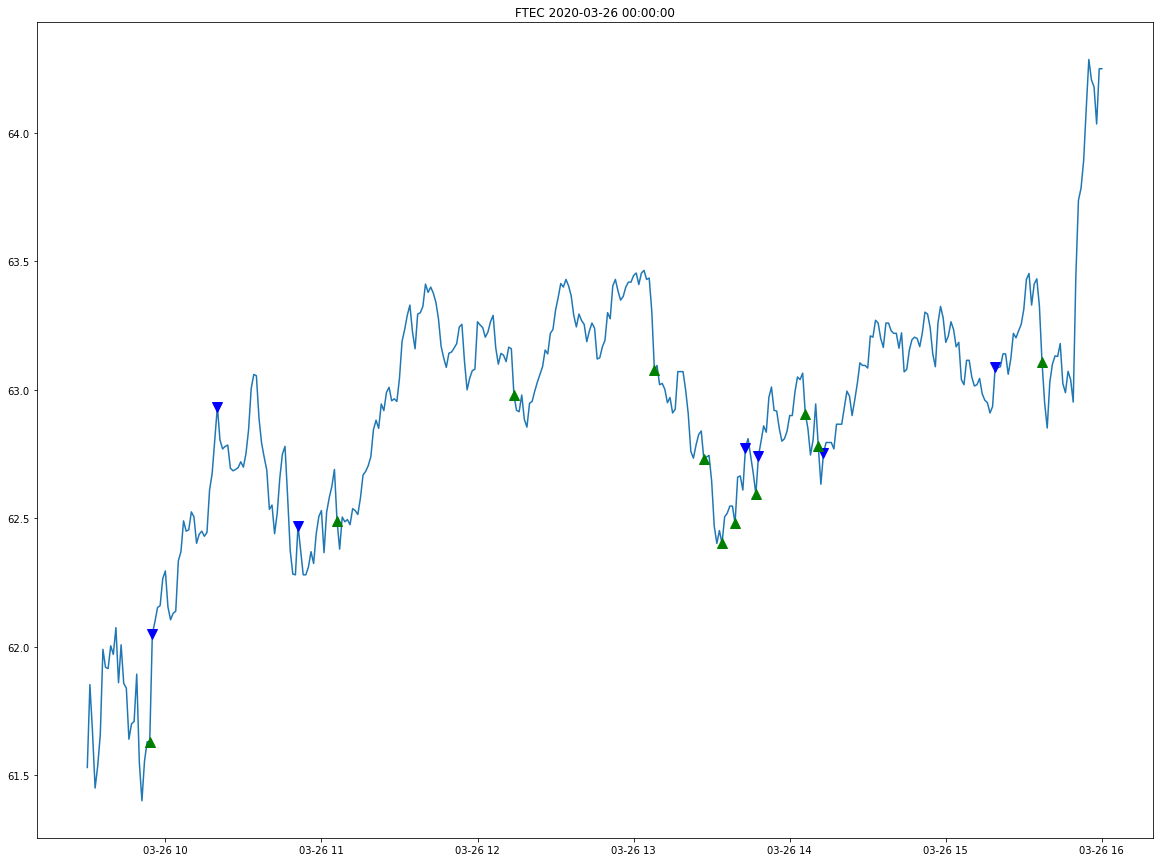

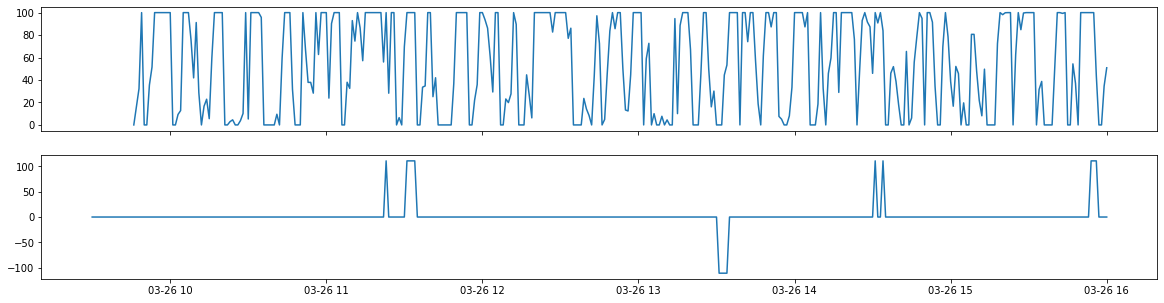

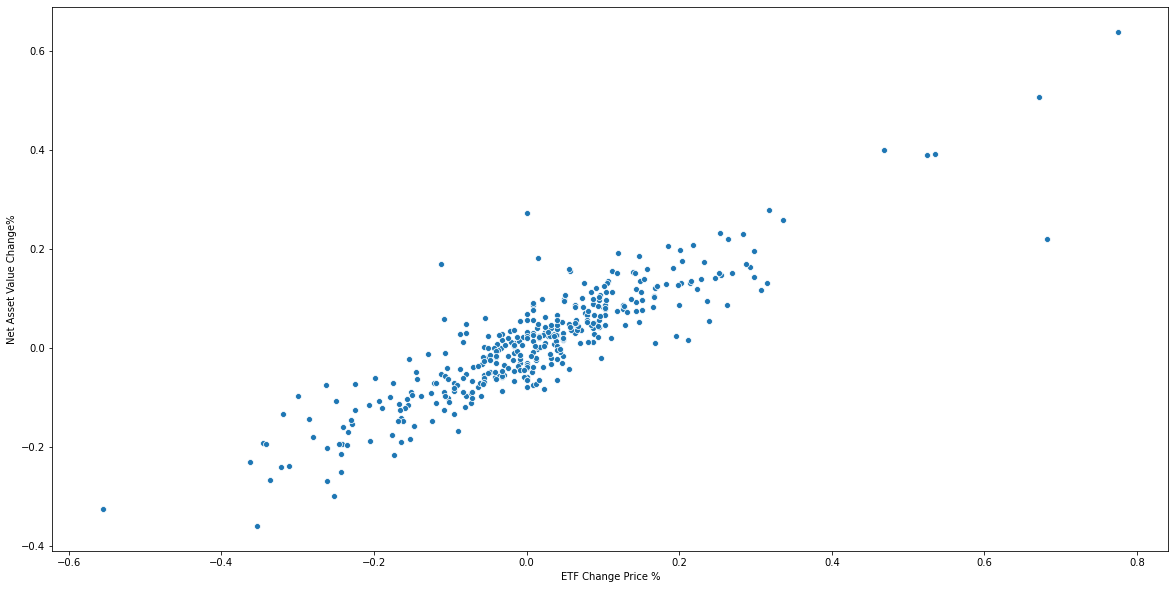

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-03-27     MSFT   37.931034         62.068966          
5   2020-03-27     V      40.350877         59.649123          
1   2020-03-27     MA     34.090909         65.909091          
6   2020-03-27     INTC   42.424242         57.575758          
4   2020-03-27     CSCO   43.750000         56.250000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  50.526316         49.473684         182            87         95         
5   50.000000         50.000000         119            57         62         
1   48.936170         51.063830         91             44         47         
6   47.222222         52.777778         69             33         36         
4   41.666667         58.333333         40             16         24

ETF Name =FTEC
Date =2020-03-27 00:00:00
Sell Positions Probability
T+1    0.833333
T+2    0.666667
T+3    0.166667
T+4    0.333333
T+5    0.833333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-27 10:03:00  0.097391                 0.169162        No Trend     
2020-03-27 11:09:00  0.057514                 0.190610        Weak Trend   
2020-03-27 11:16:00  0.060669                 0.091291        Weak Trend   
2020-03-27 13:27:00  0.056721                 0.089631        No Trend     
2020-03-27 14:16:00  0.046004                 0.141298        No Trend     
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-27 10:03:00  NaN             111.0               0.0             
2020-03-27 11:09:00  Strong Uptrend  111.0               111.0           
2020-03-27 11:16:00  Strong Uptrend  111.0               111.0           
2020-03-27 13:27:00  NaN             111.0               0.0             
2020-03-27 14:16:00  Strong Uptrend  111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-27 10:03:00  0.0            0.0              0.0                    
2020-03-27 11:09:00  111.0          111.0            111.0                  
2020-03-27 11:16:00  111.0          0.0              111.0                  
2020-03-27 13:27:00  0.0            0.0              0.0                    
2020-03-27 14:16:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  IndecisionDoji Pat  \
2020-03-27 10:03:00  111.0            0.0           -111.0                
2020-03-27 11:09:00  111.0            0.0            0.0                  
2020-03-27 11:16:00  111.0            0.0            0.0                  
2020-03-27 13:27:00  111.0            111.0          0.0                  
2020-03-27 14:16:00  111.0            0.0            0.0                  
Total Return        NaN              NaN            NaN                   

                          T+1       T+2       T+3       T+4       T+5  
2020-03-27 10:03:00 -0.193642  0.048504  0.209922  0.048541 -0.096712  
2020-03-27 11:09:00 -0.104959 -0.103624  0.015922 -0.031999 -0.000080  
2020-03-27 11:16:00  0.152085 -0.095908 -0.002800  0.042801 -0.299880  
2020-03-27 13:27:00 -0.157263 -0.167012  0.004033  0.153251  0.088588  
2020-03-27 14:16:00 -0.091575  0.128195  0.103145 -0.079137 -0.015840  
Total Return        -0.395354 -0.189845  0.330222  0.133456 -0.323924

******************
Buy Positions Probability
T+1    0.538462
T+2    0.307692
T+3    0.307692
T+4    0.384615
T+5    0.692308
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-27 09:40:00  0.105851                -0.145413        0            
2020-03-27 11:58:00  0.046944                -0.099527        No Trend     
2020-03-27 12:31:00  0.059404                -0.099975        No Trend     
2020-03-27 13:26:00  0.046801                -0.067770        No Trend     
2020-03-27 13:57:00  0.054188                -0.085723        No Trend     
2020-03-27 14:06:00  0.045832                -0.090494        Weak Trend   
2020-03-27 14:13:00  0.039205                -0.059437        No Trend     
2020-03-27 14:15:00  0.051799                -0.090494        No Trend     
2020-03-27 14:45:00  0.052949                -0.100865        No Trend     
2020-03-27 15:22:00  0.045461                -0.068301        Weak Trend   
2020-03-27 15:33:00  0.048701                -0.080840        Weak Trend   
2020-03-27 15:48:00  0.046787                -0.072570        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  \
2020-03-27 09:40:00  NaN              -111.0                
2020-03-27 11:58:00  NaN              -111.0                
2020-03-27 12:31:00  NaN               111.0                
2020-03-27 13:26:00  Strong Uptrend   -111.0                
2020-03-27 13:57:00  NaN              -111.0                
2020-03-27 14:06:00  Strong Downtrend -111.0                
2020-03-27 14:13:00  NaN              -111.0                
2020-03-27 14:15:00  NaN              -111.0                
2020-03-27 14:45:00  Strong Downtrend -111.0                
2020-03-27 15:22:00  NaN              -111.0                
2020-03-27 15:33:00  Downtrend        -111.0                
2020-03-27 15:48:00  Strong Downtrend -111.0                
Total Return         NaN              NaN                   

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-03-27 09:40:00  0.0                  -111.0            0.0             
2020-03-27 11:58:00 -111.0                -111.0           -111.0           
2020-03-27 12:31:00  111.0                 0.0              0.0             
2020-03-27 13:26:00 -111.0                 0.0              111.0           
2020-03-27 13:57:00 -111.0                -111.0           -111.0           
2020-03-27 14:06:00 -111.0                -111.0           -111.0           
2020-03-27 14:13:00  0.0                   0.0              0.0             
2020-03-27 14:15:00 -111.0                 0.0              0.0             
2020-03-27 14:45:00 -111.0                 0.0             -111.0           
2020-03-27 15:22:00 -111.0                 0.0              0.0             
2020-03-27 15:33:00 -111.0                -111.0           -111.0           
2020-03-27 15:48:00 -111.0                -111.0           -111.0           
Total Return        NaN                   NaN              NaN              

                     Hammer Pat  InvertedHammer Pat  DragonFlyDoji Pat  \
2020-03-27 09:40:00  0.0         0.0                 0.0                 
2020-03-27 11:58:00  0.0         0.0                 0.0                 
2020-03-27 12:31:00  0.0         0.0                 0.0                 
2020-03-27 13:26:00  0.0         0.0                 0.0                 
2020-03-27 13:57:00  0.0        -111.0               0.0                 
2020-03-27 14:06:00  0.0         0.0                 0.0                 
2020-03-27 14:13:00 -111.0       0.0                 0.0                 
2020-03-27 14:15:00  0.0         0.0                -111.0               
2020-03-27 14:45:00  0.0         0.0                 0.0                 
2020-03-27 15:22:00  0.0         0.0                 0.0                 
2020-03-27 15:33:00  0.0         0.0                 0.0                 
2020-03-27 15:48:00  0.0         0.0                 0.0                 
Total Return        NaN         NaN                 NaN     

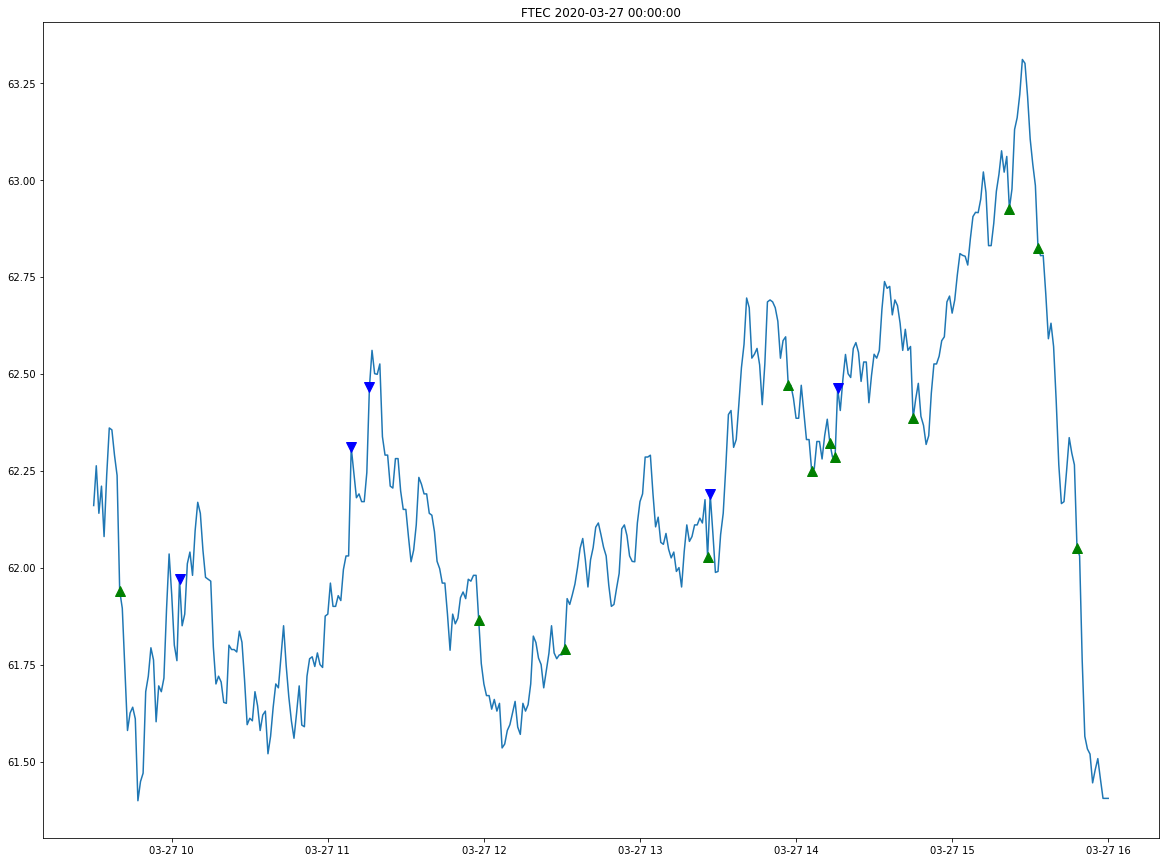

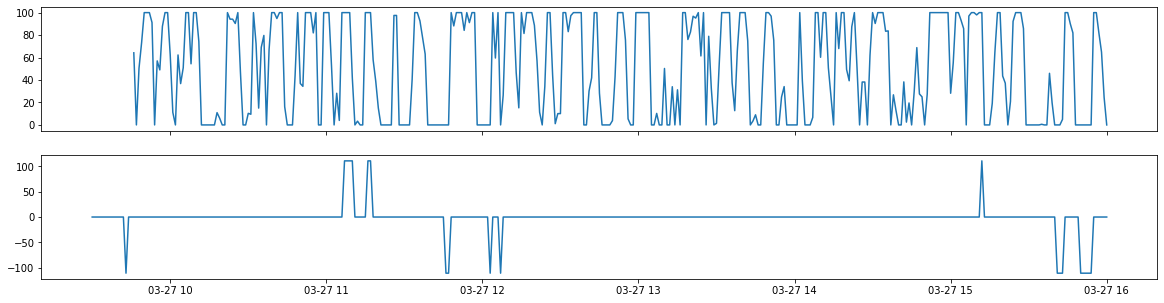

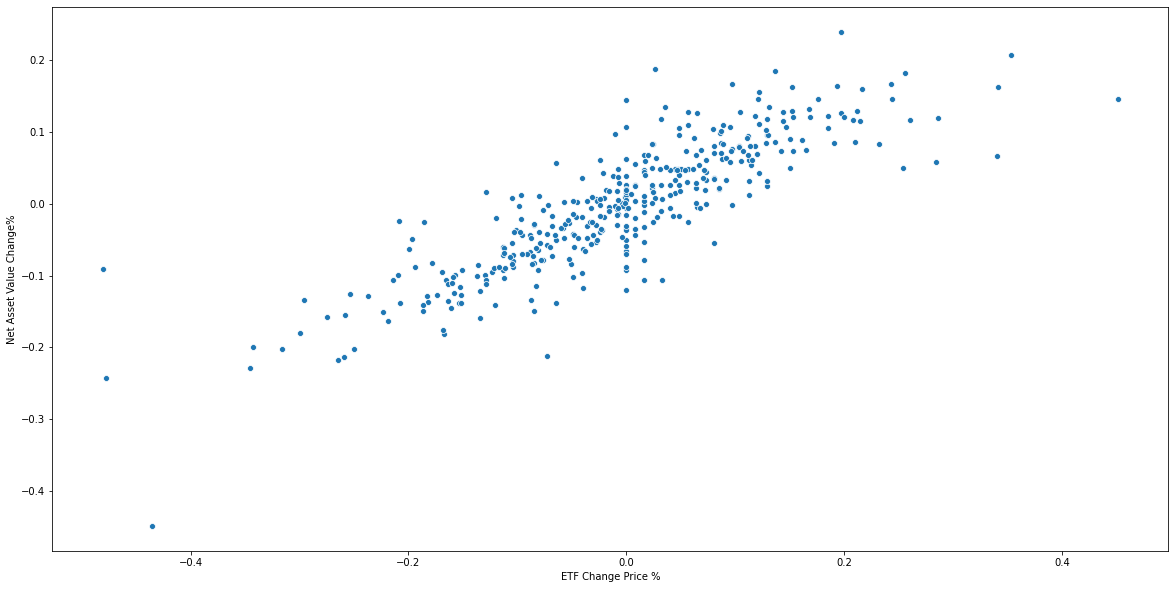

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
10  2020-03-30     AAPL   37.349398         62.650602          
19  2020-03-30     V      35.849057         64.150943          
6   2020-03-30     INTC   26.086957         73.913043          
1   2020-03-30     MA     36.585366         63.414634          
14  2020-03-30     ADBE   39.130435         60.869565          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
10  51.250000         48.750000         163            83         80         
19  53.846154         46.153846         105            53         52         
6   51.162791         48.837209         89             46         43         
1   43.750000         56.250000         73             41         32         
14  46.666667         53.333333         38             23         15

ETF Name =FTEC
Date =2020-03-30 00:00:00
Sell Positions Probability
T+1    0.6250
T+2    0.6875
T+3    0.3125
T+4    0.4375
T+5    0.3125
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-30 11:04:00  0.049542                 0.078850        Weak Trend   
2020-03-30 12:16:00  0.040104                 0.071139        No Trend     
2020-03-30 12:26:00  0.041562                 0.080304        No Trend     
2020-03-30 12:51:00  0.037108                 0.134052        Weak Trend   
2020-03-30 13:43:00  0.038441                 0.065690        Weak Trend   
2020-03-30 13:50:00  0.037321                 0.059204        Weak Trend   
2020-03-30 13:58:00  0.042153                 0.071834        Weak Trend   
2020-03-30 14:03:00  0.035714                 0.075608        No Trend     
2020-03-30 14:15:00  0.038281                 0.065615        Weak Trend   
2020-03-30 14:19:00  0.040167                 0.091419        No Trend     
2020-03-30 14:23:00  0.046168                 0.076069        No Trend     
2020-03-30 15:03:00  0.033003                 0.057513        Weak Trend   
2020-03-30 15:15:00  0.034695                 0.056129        Weak Trend   
2020-03-30 15:21:00  0.031403                 0.101187        No Trend     
2020-03-30 15:40:00  0.031794                 0.057723        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  \
2020-03-30 11:04:00  Uptrend           111.0                
2020-03-30 12:16:00  Strong Uptrend    111.0                
2020-03-30 12:26:00  NaN               111.0                
2020-03-30 12:51:00  NaN               111.0                
2020-03-30 13:43:00  NaN              -111.0                
2020-03-30 13:50:00  Strong Uptrend    111.0                
2020-03-30 13:58:00  NaN              -111.0                
2020-03-30 14:03:00  Strong Downtrend -111.0                
2020-03-30 14:15:00  NaN              -111.0                
2020-03-30 14:19:00  Strong Downtrend  111.0                
2020-03-30 14:23:00  NaN               111.0                
2020-03-30 15:03:00  NaN               111.0                
2020-03-30 15:15:00  NaN               111.0                
2020-03-30 15:21:00  NaN               111.0                
2020-03-30 15:40:00  NaN               111.0                
Total Return         NaN              NaN                   

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-03-30 11:04:00  111.0                 111.0            0.0             
2020-03-30 12:16:00  111.0                 111.0            0.0             
2020-03-30 12:26:00  111.0                 0.0              0.0             
2020-03-30 12:51:00  111.0                 111.0            0.0             
2020-03-30 13:43:00  0.0                   0.0              0.0             
2020-03-30 13:50:00  111.0                 111.0            111.0           
2020-03-30 13:58:00  0.0                   0.0              111.0           
2020-03-30 14:03:00  111.0                 0.0              111.0           
2020-03-30 14:15:00  111.0                -111.0            0.0             
2020-03-30 14:19:00  111.0                 0.0              0.0             
2020-03-30 14:23:00  111.0                 111.0            0.0             
2020-03-30 15:03:00  111.0                 0.0              0.0             
2020-03-30 15:15:00  0.0                   0.0              0.0             
2020-03-30 15:21:00  111.0                 111.0            0.0             
2020-03-30 15:40:00  111.0                 111.0            0.0             
Total Return        NaN                   NaN              NaN              

                     HanginMan Pat  IndecisionDoji Pat       T+1       T+2  \
2020-03-30 11:04:00  0.0           -111.0              -0.055485  0.142631   
2020-03-30 12:16:00  0.0           -111.0              -0.000079  0.000000   
2020-03-30 12:26:00  0.0           -111.0               0.036483  0.000000   
2020-03-30 12:51:00  0.0            0.0                 0.053439 -0.

******************
Buy Positions Probability
T+1    0.571429
T+2    0.571429
T+3    0.428571
T+4    0.571429
T+5    0.357143
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-30 11:38:00  0.040627                -0.118196        Weak Trend   
2020-03-30 12:00:00  0.043324                -0.067858        No Trend     
2020-03-30 12:07:00  0.043158                -0.064541        Weak Trend   
2020-03-30 12:50:00  0.037387                -0.066977        Weak Trend   
2020-03-30 13:03:00  0.038407                -0.059568        No Trend     
2020-03-30 13:08:00  0.037554                -0.120584        No Trend     
2020-03-30 13:15:00  0.043285                -0.069685        No Trend     
2020-03-30 13:56:00  0.044156                -0.109973        Weak Trend   
2020-03-30 15:07:00  0.032951                -0.063296        No Trend     
2020-03-30 15:16:00  0.034402                -0.084658        Weak Trend   
2020-03-30 15:20:00  0.032997                -0.065574        No Trend     
2020-03-30 15:25:00  0.033393                -0.071445        No Trend     
2020-03-30 15:41:00  0.034659                -0.057623        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  \
2020-03-30 11:38:00  NaN              -111.0                
2020-03-30 12:00:00  Strong Downtrend -111.0                
2020-03-30 12:07:00  Strong Downtrend -111.0                
2020-03-30 12:50:00  Strong Downtrend -111.0                
2020-03-30 13:03:00  Strong Downtrend -111.0                
2020-03-30 13:08:00  Strong Downtrend -111.0                
2020-03-30 13:15:00  NaN               111.0                
2020-03-30 13:56:00  Uptrend          -111.0                
2020-03-30 15:07:00  NaN              -111.0                
2020-03-30 15:16:00  NaN               111.0                
2020-03-30 15:20:00  NaN              -111.0                
2020-03-30 15:25:00  NaN              -111.0                
2020-03-30 15:41:00  NaN               111.0                
Total Return         NaN              NaN                   

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-03-30 11:38:00 -111.0                -111.0           -111.0           
2020-03-30 12:00:00 -111.0                -111.0            0.0             
2020-03-30 12:07:00  0.0                  -111.0            0.0             
2020-03-30 12:50:00 -111.0                 0.0              0.0             
2020-03-30 13:03:00 -111.0                -111.0           -111.0           
2020-03-30 13:08:00 -111.0                -111.0           -111.0           
2020-03-30 13:15:00  111.0                 0.0              0.0             
2020-03-30 13:56:00 -111.0                -111.0            111.0           
2020-03-30 15:07:00 -111.0                -111.0            0.0             
2020-03-30 15:16:00 -111.0                 0.0              0.0             
2020-03-30 15:20:00  0.0                   0.0              0.0             
2020-03-30 15:25:00 -111.0                -111.0            0.0             
2020-03-30 15:41:00  0.0                   0.0              0.0             
Total Return        NaN                   NaN              NaN              

                     Hammer Pat  DragonFlyDoji Pat  IndecisionSpinningTop Pat  \
2020-03-30 11:38:00  0.0         0.0                0.0                         
2020-03-30 12:00:00  0.0         0.0                0.0                         
2020-03-30 12:07:00  0.0         0.0                0.0                         
2020-03-30 12:50:00  0.0         0.0                0.0                         
2020-03-30 13:03:00 -111.0      -111.0              0.0                         
2020-03-30 13:08:00  0.0         0.0                0.0                         
2020-03-30 13:15:00  0.0         0.0                0.0                         
2020-03-30 13:56:00  0.0         0.0                0.0                         
2020-03-30 15:07:00  0.0         0.0                0.0                        

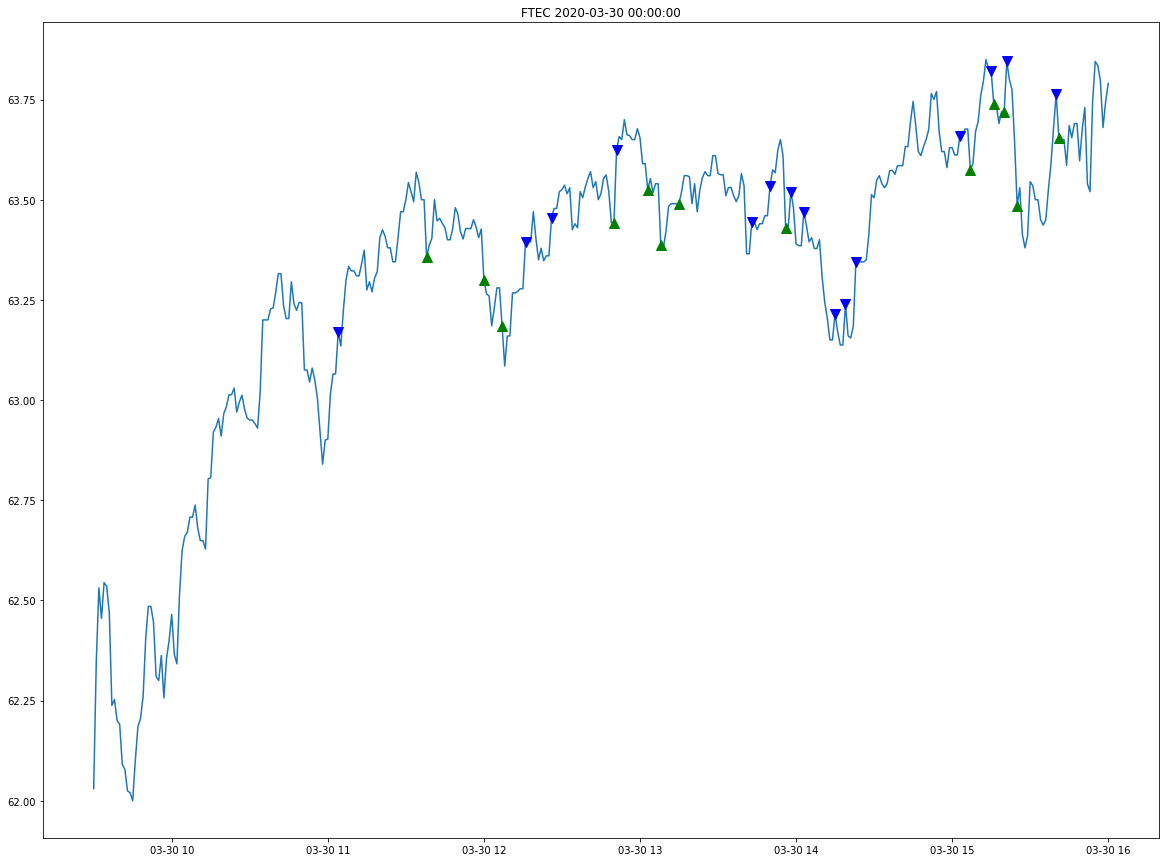

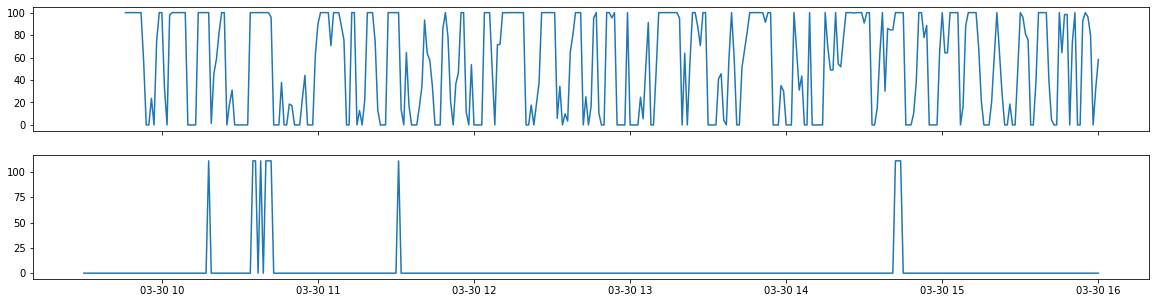

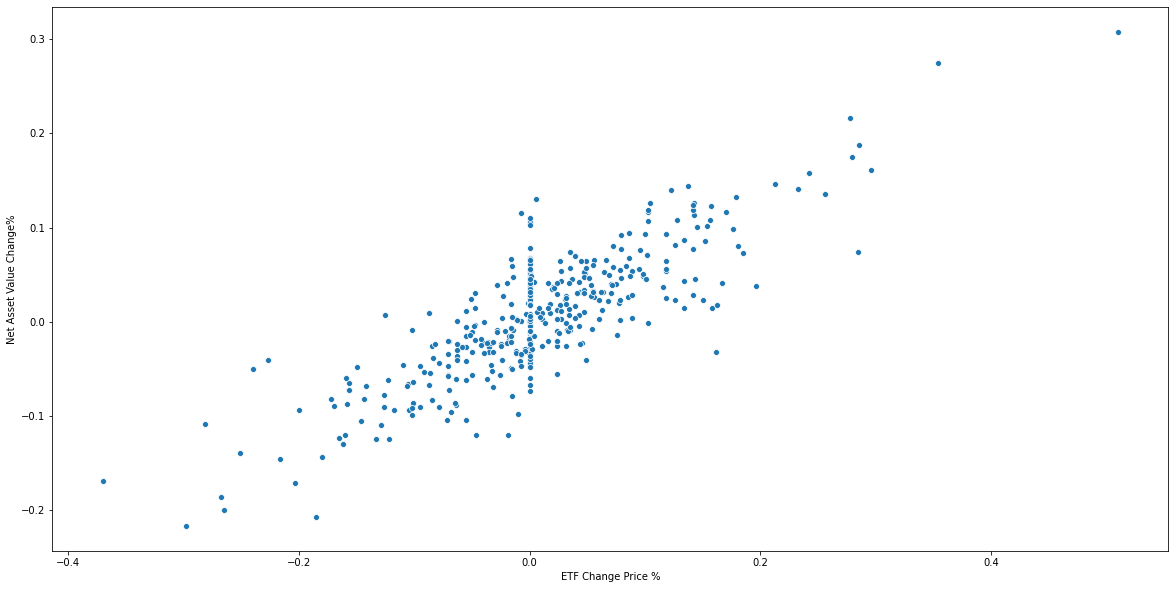

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-03-31     AAPL   35.802469         64.197531          
16  2020-03-31     V      40.000000         60.000000          
2   2020-03-31     MA     50.000000         50.000000          
4   2020-03-31     INTC   36.000000         64.000000          
1   2020-03-31     NVDA   38.709677         61.290323          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  58.095238         41.904762         186            81         105        
16  55.357143         44.642857         101            45         56         
2   65.000000         35.000000         76             36         40         
4   60.000000         40.000000         70             25         45         
1   65.714286         34.285714         66             31         35

ETF Name =FTEC
Date =2020-03-31 00:00:00
Sell Positions Probability
T+1    0.434783
T+2    0.478261
T+3    0.391304
T+4    0.304348
T+5    0.521739
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-03-31 10:03:00  0.051899                 0.117632        No Trend       
2020-03-31 10:07:00  0.039365                 0.061593        Weak Trend     
2020-03-31 10:18:00  0.048731                 0.078713        Strong Trend   
2020-03-31 10:37:00  0.039270                 0.080649        Weak Trend     
2020-03-31 11:16:00  0.039799                 0.066956        Weak Trend     
2020-03-31 11:28:00  0.041142                 0.072957        No Trend       
2020-03-31 12:43:00  0.042958                 0.067616        Strong Trend   
2020-03-31 12:49:00  0.038692                 0.130077        Weak Trend     
2020-03-31 12:57:00  0.040199                 0.078064        Weak Trend     
2020-03-31 13:00:00  0.044224                 0.097684        No Trend       
2020-03-31 13:03:00  0.039149                 0.060898        No Trend       
2020-03-31 13:10:00  0.039764                 0.074153        No Trend       
2020-03-31 13:19:00  0.040360                 0.071965        No Trend       
2020-03-31 13:36:00  0.040161                 0.063601        No Trend       
2020-03-31 13:40:00  0.039811                 0.085441        No Trend       
2020-03-31 13:43:00  0.038000                 0.074723        No Trend       
2020-03-31 13:56:00  0.041238                 0.072868        No Trend       
2020-03-31 14:10:00  0.036691                 0.122862        No Trend       
2020-03-31 15:36:00  0.036271                 0.057751        Weak Trend     
2020-03-31 15:38:00  0.034729                 0.076166        Weak Trend     
2020-03-31 15:40:00  0.031821                 0.073696        Weak Trend     
2020-03-31 15:55:00  0.039366                 0.135111        No Trend       
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-31 10:03:00  Strong Uptrend    111.0               0.0             
2020-03-31 10:07:00  Strong Uptrend    111.0               111.0           
2020-03-31 10:18:00  Strong Uptrend    111.0               111.0           
2020-03-31 10:37:00  Strong Uptrend    111.0               0.0             
2020-03-31 11:16:00  Strong Uptrend    111.0               0.0             
2020-03-31 11:28:00  NaN               111.0               0.0             
2020-03-31 12:43:00  NaN               111.0               0.0             
2020-03-31 12:49:00  Strong Uptrend    111.0               0.0             
2020-03-31 12:57:00  Uptrend           111.0               0.0             
2020-03-31 13:00:00  NaN              -111.0               0.0             
2020-03-31 13:03:00  NaN               111.0               0.0             
2020-03-31 13:10:00  Downtrend         111.0               0.0             
2020-03-31 13:19:00  Downtrend        -111.0               0.0             
2020-03-31 13:36:00  Uptrend           111.0               0.0             
2020-03-31 13:40:00  Strong Uptrend    111.0               0.0             
2020-03-31 13:43:00  Strong Uptrend    111.0               0.0             
2020-03-31 13:56:00  NaN               111.0               0.0             
2020-03-31 14:10:00  Strong Downtrend  111.0               0.0             
2020-03-31 15:36:00  NaN               111.0               0.0             
2020-03-31 15:38:00  Strong Uptrend    111.0               0.0             
2020-03-31 15:40:00  Strong Uptrend    111.0               0.0             
2020-03-31 15:55:00  Downtrend         111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-31 10:03:00  0.0            111.0            111.0                  
2020-03-31 10:07:00  111.0          111.0            111.0                  
2020-03-31 10:18:00  111.0          111.0            0.0                    
2020-03-31 10:3

******************
Buy Positions Probability
T+1    0.565217
T+2    0.434783
T+3    0.608696
T+4    0.434783
T+5    0.217391
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-03-31 09:52:00  0.061875                -0.132203        No Trend       
2020-03-31 10:45:00  0.045941                -0.076777        Weak Trend     
2020-03-31 10:54:00  0.044834                -0.069642        No Trend       
2020-03-31 11:02:00  0.044959                -0.065944        Weak Trend     
2020-03-31 11:18:00  0.039899                -0.082115        Weak Trend     
2020-03-31 11:31:00  0.044582                -0.083716        No Trend       
2020-03-31 11:44:00  0.038196                -0.061024        No Trend       
2020-03-31 12:28:00  0.042436                -0.077948        Strong Trend   
2020-03-31 12:31:00  0.041646                -0.064030        Strong Trend   
2020-03-31 12:48:00  0.039104                -0.067211        Weak Trend     
2020-03-31 12:51:00  0.038989                -0.066594        Weak Trend     
2020-03-31 12:58:00  0.038089                -0.133423        Weak Trend     
2020-03-31 13:04:00  0.039020                -0.097770        No Trend       
2020-03-31 13:16:00  0.040595                -0.118681        No Trend       
2020-03-31 13:29:00  0.037810                -0.061073        No Trend       
2020-03-31 13:48:00  0.037914                -0.059850        No Trend       
2020-03-31 13:53:00  0.040980                -0.067896        No Trend       
2020-03-31 13:57:00  0.036881                -0.068786        No Trend       
2020-03-31 14:06:00  0.037041                -0.075086        No Trend       
2020-03-31 14:09:00  0.033280                -0.061123        No Trend       
2020-03-31 14:16:00  0.038750                -0.064267        No Trend       
2020-03-31 15:37:00  0.036813                -0.074779        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-31 09:52:00  Strong Downtrend -111.0               0.0             
2020-03-31 10:45:00  Uptrend          -111.0               0.0             
2020-03-31 10:54:00  Strong Uptrend   -111.0               0.0             
2020-03-31 11:02:00  Downtrend        -111.0               0.0             
2020-03-31 11:18:00  Strong Uptrend   -111.0               0.0             
2020-03-31 11:31:00  Uptrend           111.0               0.0             
2020-03-31 11:44:00  Strong Downtrend -111.0               0.0             
2020-03-31 12:28:00  Strong Downtrend -111.0              -111.0           
2020-03-31 12:31:00  Downtrend        -111.0              -111.0           
2020-03-31 12:48:00  Strong Uptrend    111.0               0.0             
2020-03-31 12:51:00  Strong Uptrend    111.0               0.0             
2020-03-31 12:58:00  NaN              -111.0               0.0             
2020-03-31 13:04:00  NaN              -111.0               0.0             
2020-03-31 13:16:00  NaN              -111.0               0.0             
2020-03-31 13:29:00  NaN              -111.0               0.0             
2020-03-31 13:48:00  Strong Uptrend    111.0               0.0             
2020-03-31 13:53:00  NaN              -111.0               0.0             
2020-03-31 13:57:00  NaN               111.0               0.0             
2020-03-31 14:06:00  Downtrend        -111.0               0.0             
2020-03-31 14:09:00  Strong Downtrend -111.0               0.0             
2020-03-31 14:16:00  NaN              -111.0               0.0             
2020-03-31 15:37:00  NaN               111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-31 09:52:00  0.0            0.0             -111.0                  
2020-03-31 10:45:00  0.0            0.0             -111.0                  
2020-03-31 10:54:00  0.0            0.0             -111.0                  
2020-03-31 11:0

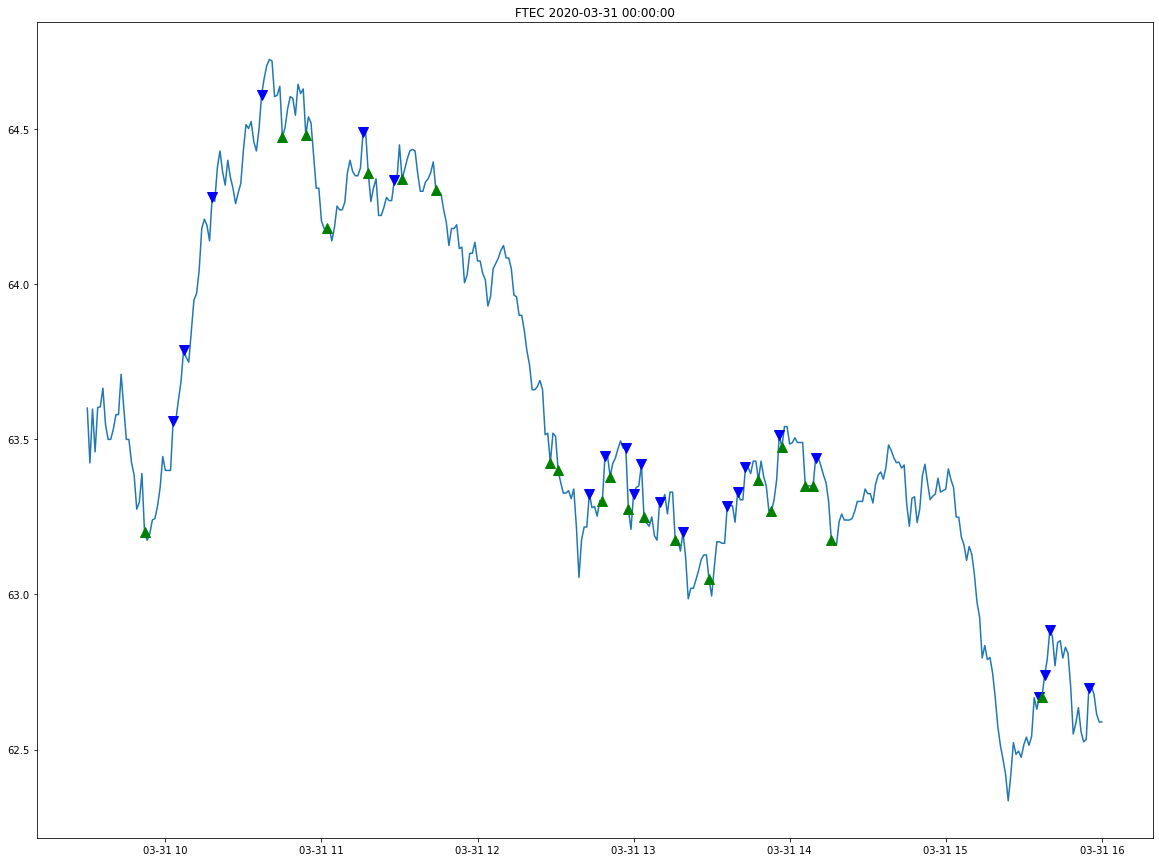

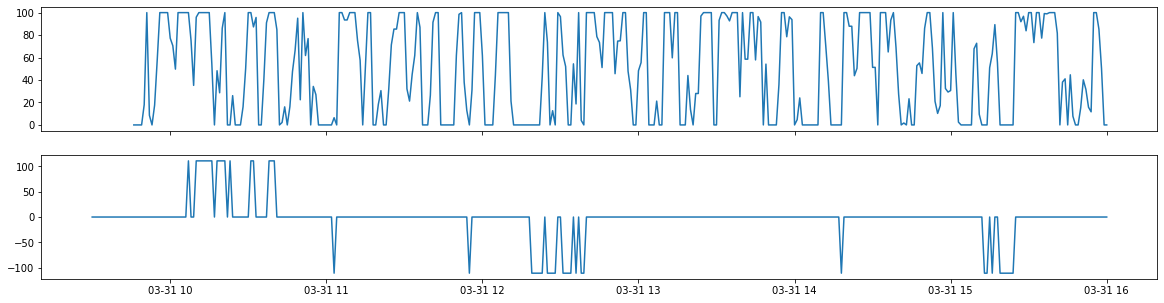

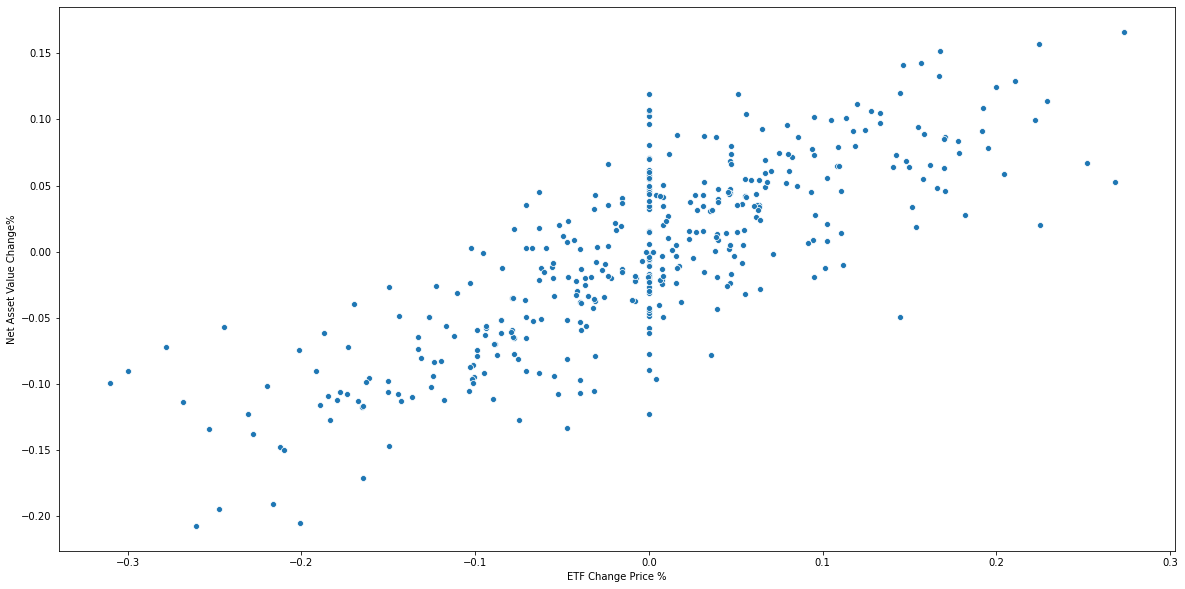

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
9   2020-04-01     AAPL   32.941176         67.058824          
20  2020-04-01     V      25.490196         74.509804          
6   2020-04-01     INTC   33.333333         66.666667          
1   2020-04-01     MA     35.000000         65.000000          
11  2020-04-01     NVDA   36.842105         63.157895          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
9   43.750000         56.250000         181            85         96         
20  41.860465         58.139535         94             51         43         
6   43.902439         56.097561         89             48         41         
1   38.888889         61.111111         76             40         36         
11  45.454545         54.545455         41             19         22

ETF Name =FTEC
Date =2020-04-01 00:00:00
Sell Positions Probability
T+1    0.666667
T+2    0.500000
T+3    0.666667
T+4    0.333333
T+5    0.277778
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-01 09:31:00  0.158571                 0.181290        0              
2020-04-01 10:07:00  0.052110                 0.142472        No Trend       
2020-04-01 10:38:00  0.046292                 0.074462        No Trend       
2020-04-01 10:43:00  0.047572                 0.076186        No Trend       
2020-04-01 10:47:00  0.044358                 0.159664        No Trend       
2020-04-01 11:06:00  0.037356                 0.071714        No Trend       
2020-04-01 11:24:00  0.044562                 0.074628        No Trend       
2020-04-01 11:26:00  0.045122                 0.069577        No Trend       
2020-04-01 11:53:00  0.042083                 0.110668        Weak Trend     
2020-04-01 11:59:00  0.042753                 0.071346        No Trend       
2020-04-01 12:44:00  0.041716                 0.062553        Strong Trend   
2020-04-01 13:18:00  0.036612                 0.069960        No Trend       
2020-04-01 13:25:00  0.037464                 0.059781        No Trend       
2020-04-01 13:30:00  0.039567                 0.069560        No Trend       
2020-04-01 13:49:00  0.042414                 0.069366        No Trend       
2020-04-01 14:03:00  0.038368                 0.118068        No Trend       
2020-04-01 14:53:00  0.036012                 0.066748        No Trend       
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  ULTOC Indicator  \
2020-04-01 09:31:00  NaN               0.0                 0.0               
2020-04-01 10:07:00  NaN               111.0               0.0               
2020-04-01 10:38:00  NaN               111.0               0.0               
2020-04-01 10:43:00  Strong Downtrend  111.0               0.0               
2020-04-01 10:47:00  NaN               111.0               0.0               
2020-04-01 11:06:00  Strong Uptrend    111.0               111.0             
2020-04-01 11:24:00  NaN              -111.0               0.0               
2020-04-01 11:26:00  Strong Downtrend -111.0               0.0               
2020-04-01 11:53:00  Uptrend           111.0               0.0               
2020-04-01 11:59:00  Strong Uptrend    111.0               0.0               
2020-04-01 12:44:00  Strong Downtrend -111.0               0.0               
2020-04-01 13:18:00  NaN               111.0               0.0               
2020-04-01 13:25:00  Strong Uptrend    111.0               0.0               
2020-04-01 13:30:00  NaN              -111.0               0.0               
2020-04-01 13:49:00  Strong Uptrend    111.0               0.0               
2020-04-01 14:03:00  NaN               111.0               0.0               
2020-04-01 14:53:00  NaN              -111.0               0.0               
Total Return         NaN              NaN                 NaN                

                     Stochastic Indicator  WILLR Indicator  MFI Indicator  \
2020-04-01 09:31:00  0.0                   0.0              0.0             
2020-04-01 10:07:00  111.0                 111.0            0.0             
2020-04-01 10:38:00  0.0                   111.0           -111.0           
2020-04-01 10:43:00  111.0                 0.0              0.0             
2020-04-01 10:47:00  111.0                 111.0            0.0             
2020-04-01 11:06:00  111.0                 111.0            111.0           
2020-04-01 11:24:00 -111.0                -111.0            0.0             
2020-04-01 11:26:00 -111.0                -111.0            0.0             
2020-04-01 11:53:00  111.0                 111.0            0.0             
2020-04-01 11:59:00 -111.0                 0.0              0.0             
2020-04-01 12:44:00  111.0                 0.0             -111.0           
2020-04-01 13:18:00  111.0                 111.0           -111.0           
2020-04-01 13:25:00  111.0                 111.0      

******************
Buy Positions Probability
T+1    0.5000
T+2    0.2500
T+3    0.4375
T+4    0.5000
T+5    0.5625
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-01 09:47:00  0.048599                -0.069466        0              
2020-04-01 10:08:00  0.051398                -0.080565        No Trend       
2020-04-01 10:26:00  0.049704                -0.107932        No Trend       
2020-04-01 10:45:00  0.044826                -0.080574        No Trend       
2020-04-01 10:46:00  0.046754                -0.086595        No Trend       
2020-04-01 11:14:00  0.039967                -0.071866        Weak Trend     
2020-04-01 11:25:00  0.044161                -0.125457        No Trend       
2020-04-01 11:27:00  0.043879                -0.075546        No Trend       
2020-04-01 12:00:00  0.042240                -0.071355        No Trend       
2020-04-01 12:27:00  0.032270                -0.116965        Weak Trend     
2020-04-01 13:20:00  0.036793                -0.072700        No Trend       
2020-04-01 13:24:00  0.035935                -0.065164        No Trend       
2020-04-01 14:17:00  0.039226                -0.080686        Weak Trend     
2020-04-01 14:33:00  0.030732                -0.056780        Strong Trend   
2020-04-01 14:55:00  0.035414                -0.080404        No Trend       
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-01 09:47:00  Strong Downtrend -111.0               0.0             
2020-04-01 10:08:00  NaN               111.0               0.0             
2020-04-01 10:26:00  Strong Downtrend -111.0               0.0             
2020-04-01 10:45:00  NaN              -111.0               0.0             
2020-04-01 10:46:00  NaN              -111.0               0.0             
2020-04-01 11:14:00  Uptrend          -111.0               0.0             
2020-04-01 11:25:00  Downtrend        -111.0               0.0             
2020-04-01 11:27:00  Strong Downtrend -111.0              -111.0           
2020-04-01 12:00:00  NaN              -111.0               0.0             
2020-04-01 12:27:00  NaN              -111.0               0.0             
2020-04-01 13:20:00  NaN               111.0               0.0             
2020-04-01 13:24:00  Uptrend           111.0               0.0             
2020-04-01 14:17:00  Strong Downtrend -111.0              -111.0           
2020-04-01 14:33:00  Strong Downtrend -111.0              -111.0           
2020-04-01 14:55:00  Downtrend        -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-01 09:47:00  0.0            0.0             -111.0                  
2020-04-01 10:08:00  0.0            0.0              111.0                  
2020-04-01 10:26:00  0.0            0.0             -111.0                  
2020-04-01 10:45:00  0.0            0.0              0.0                    
2020-04-01 10:46:00  0.0            0.0              0.0                    
2020-04-01 11:14:00  0.0            0.0             -111.0                  
2020-04-01 11:25:00  0.0            0.0             -111.0                  
2020-04-01 11:27:00 -111.0          0.0             -111.0                  
2020-04-01 12:00:00  0.0            0.0             -111.0                  
2020-04-01 12:27:00  0.0            0.0             -111.0                  
2020-04-01 13:20:00  0.0            0.0              0.0                    
2020-04-01 13:24:00  0.0            0.0              0.0                    
2020-04-01 14:17:00 -111.0         -111.0           -111.0                  
2020-04-01 14:33:00 -111.0         -111.0           -111.0                  
2020-04-01 14:55:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  Hammer Pat  \
2020-04-01 09:47:00 -111

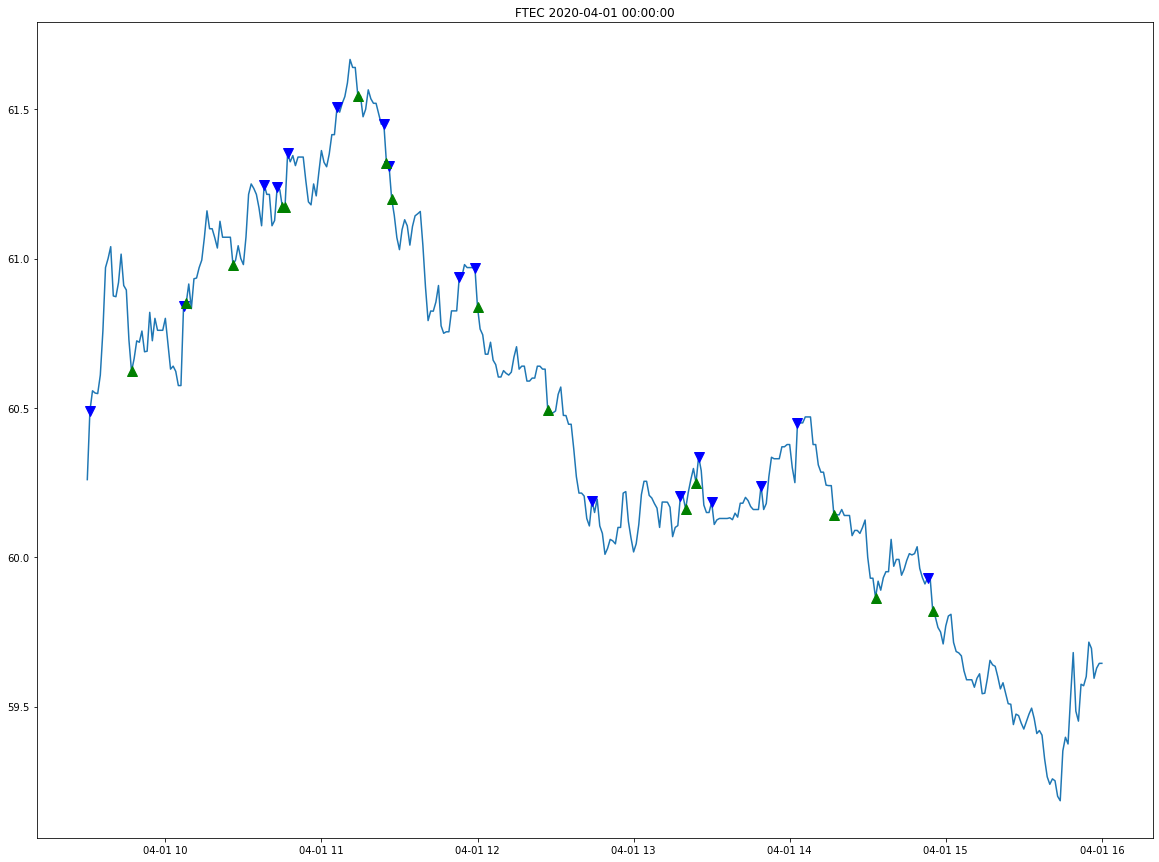

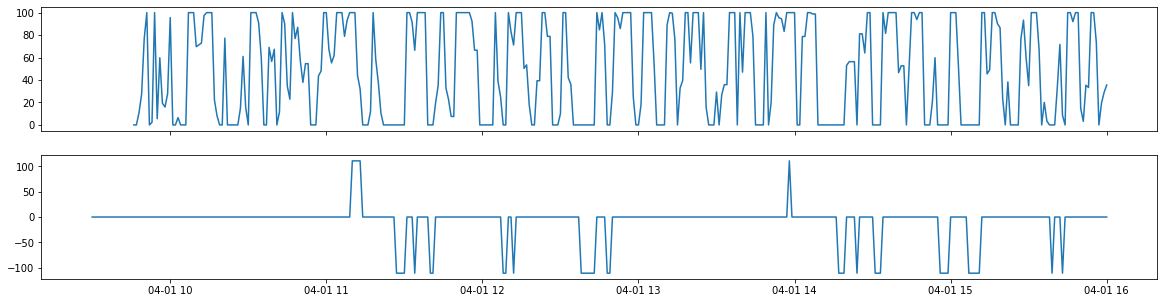

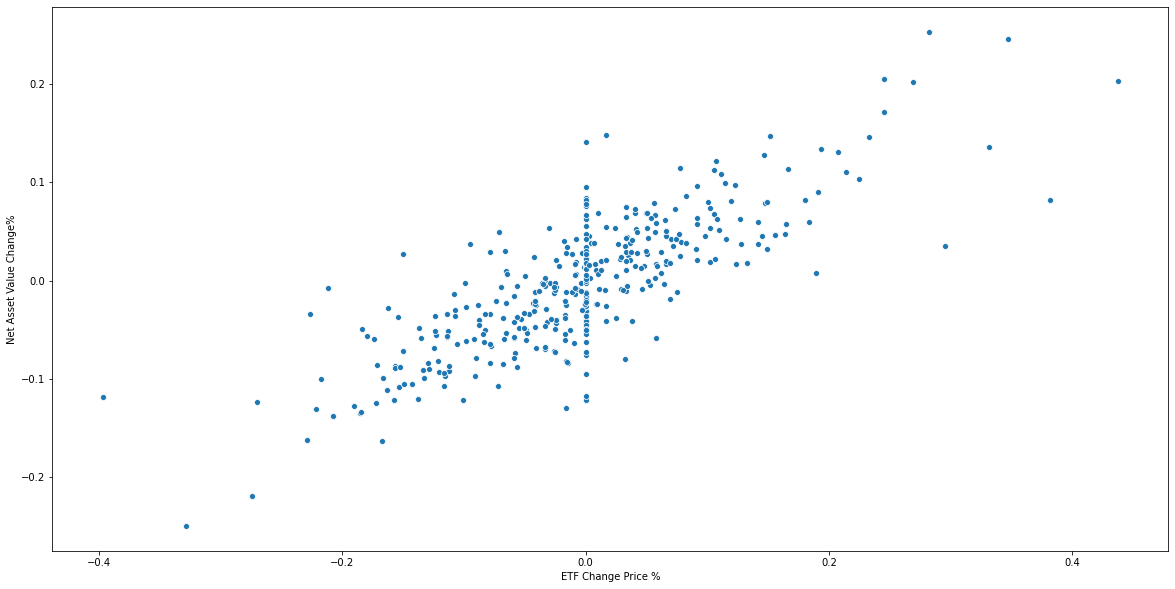

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
9   2020-04-02     AAPL   28.925620         71.074380          
6   2020-04-02     INTC   24.285714         75.714286          
19  2020-04-02     V      35.483871         64.516129          
1   2020-04-02     MA     28.000000         72.000000          
11  2020-04-02     NVDA   35.714286         64.285714          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
9   43.650794         56.349206         247            121        126        
6   44.827586         55.172414         128            70         58         
19  33.333333         66.666667         122            62         60         
1   38.805970         61.194030         117            50         67         
11  42.857143         57.142857         70             28         42

ETF Name =FTEC
Date =2020-04-02 00:00:00
Sell Positions Probability
T+1    0.266667
T+2    0.333333
T+3    0.433333
T+4    0.466667
T+5    0.333333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-02 10:02:00  0.057125                 0.117982        No Trend       
2020-04-02 10:12:00  0.037071                 0.112272        Weak Trend     
2020-04-02 10:18:00  0.042797                 0.074474        Weak Trend     
2020-04-02 10:35:00  0.067227                 0.091360        Weak Trend     
2020-04-02 11:19:00  0.039073                 0.070342        No Trend       
2020-04-02 11:34:00  0.047602                 0.221326        No Trend       
2020-04-02 11:38:00  0.050474                 0.085887        No Trend       
2020-04-02 11:41:00  0.052514                 0.105830        No Trend       
2020-04-02 11:45:00  0.054215                 0.086337        No Trend       
2020-04-02 11:56:00  0.048451                 0.085168        Weak Trend     
2020-04-02 12:05:00  0.053643                 0.106874        Weak Trend     
2020-04-02 12:42:00  0.052266                 0.074357        No Trend       
2020-04-02 13:03:00  0.050098                 0.217326        No Trend       
2020-04-02 13:10:00  0.053090                 0.078325        No Trend       
2020-04-02 13:27:00  0.047640                 0.072756        Weak Trend     
2020-04-02 13:40:00  0.049497                 0.086597        Weak Trend     
2020-04-02 14:14:00  0.049049                 0.144172        Strong Trend   
2020-04-02 14:31:00  0.045270                 0.074612        No Trend       
2020-04-02 14:34:00  0.054039                 0.085688        No Trend       
2020-04-02 14:39:00  0.047709                 0.161432        No Trend       
2020-04-02 14:41:00  0.048297                 0.075798        No Trend       
2020-04-02 14:53:00  0.052186                 0.083347        No Trend       
2020-04-02 15:01:00  0.053466                 0.207268        Weak Trend     
2020-04-02 15:09:00  0.045765                 0.105433        Weak Trend     
2020-04-02 15:16:00  0.048902                 0.076382        No Trend       
2020-04-02 15:30:00  0.045789                 0.090563        No Trend       
2020-04-02 15:31:00  0.047013                 0.128457        No Trend       
2020-04-02 15:40:00  0.043106                 0.124557        No Trend       
2020-04-02 15:51:00  0.053803                 0.089396        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-02 10:02:00  Strong Uptrend    111.0               0.0             
2020-04-02 10:12:00  Uptrend           111.0               111.0           
2020-04-02 10:18:00  NaN              -111.0               0.0             
2020-04-02 10:35:00  Uptrend           111.0               111.0           
2020-04-02 11:19:00  Uptrend           111.0               0.0             
2020-04-02 11:34:00  NaN               111.0               0.0             
2020-04-02 11:38:00  Uptrend           111.0               0.0             
2020-04-02 11:41:00  NaN               111.0               0.0             
2020-04-02 11:45:00  NaN               111.0               0.0             
2020-04-02 11:56:00  Strong Uptrend    111.0               0.0             
2020-04-02 12:05:00  Strong Uptrend    111.0               0.0             
2020-04-02 12:42:00  NaN               111.0               0.0             
2020-04-02 13:03:00  NaN               111.0               0.0             
2020-04-02 13:10:00  NaN              -111.0               0.0             
2020-04-02 13:27:00  Strong Downtrend -111.0              -111.0           
2020-04-02 13:40:00  NaN               111.0               0.0             
2020-04-02 14:14:00  NaN               111.0               0.0             
2020-04-02 14:31:00  NaN               111.0               0.0             
2020-04-02 14:34:00  NaN               111.0               0.0             
2020-04-02 14:39:00  Uptrend           111.0               0.0             
2020-0

******************
Buy Positions Probability
T+1    0.44
T+2    0.44
T+3    0.28
T+4    0.36
T+5    0.28
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-02 10:17:00  0.037844                -0.069603        Weak Trend     
2020-04-02 10:22:00  0.038223                -0.060341        Weak Trend     
2020-04-02 10:28:00  0.055552                -0.109931        No Trend       
2020-04-02 11:09:00  0.047287                -0.108921        No Trend       
2020-04-02 11:25:00  0.050932                -0.092206        No Trend       
2020-04-02 11:39:00  0.049927                -0.148584        No Trend       
2020-04-02 12:07:00  0.055969                -0.080396        Weak Trend     
2020-04-02 12:40:00  0.052413                -0.086015        Weak Trend     
2020-04-02 13:06:00  0.048368                -0.155102        No Trend       
2020-04-02 13:12:00  0.054483                -0.153872        No Trend       
2020-04-02 13:28:00  0.049658                -0.110612        Strong Trend   
2020-04-02 13:59:00  0.048044                -0.122011        Weak Trend     
2020-04-02 14:13:00  0.047591                -0.081439        Strong Trend   
2020-04-02 14:17:00  0.046256                -0.102181        Weak Trend     
2020-04-02 14:21:00  0.051176                -0.113350        Weak Trend     
2020-04-02 14:33:00  0.054418                -0.074879        No Trend       
2020-04-02 14:38:00  0.055033                -0.080292        No Trend       
2020-04-02 14:43:00  0.048123                -0.146614        No Trend       
2020-04-02 14:49:00  0.050319                -0.095923        No Trend       
2020-04-02 15:00:00  0.053375                -0.101903        Weak Trend     
2020-04-02 15:11:00  0.044647                -0.065083        Weak Trend     
2020-04-02 15:20:00  0.038643                -0.072984        No Trend       
2020-04-02 15:32:00  0.039748                -0.144786        No Trend       
2020-04-02 15:46:00  0.042595                -0.085381        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-02 10:17:00  NaN              -111.0               0.0             
2020-04-02 10:22:00  NaN               111.0               0.0             
2020-04-02 10:28:00  Downtrend        -111.0               0.0             
2020-04-02 11:09:00  NaN              -111.0               0.0             
2020-04-02 11:25:00  NaN              -111.0               0.0             
2020-04-02 11:39:00  NaN              -111.0               0.0             
2020-04-02 12:07:00  NaN               111.0               0.0             
2020-04-02 12:40:00  NaN              -111.0               0.0             
2020-04-02 13:06:00  NaN              -111.0               0.0             
2020-04-02 13:12:00  Downtrend        -111.0              -111.0           
2020-04-02 13:28:00  Strong Downtrend -111.0              -111.0           
2020-04-02 13:59:00  NaN              -111.0               0.0             
2020-04-02 14:13:00  Strong Downtrend -111.0              -111.0           
2020-04-02 14:17:00  NaN              -111.0               0.0             
2020-04-02 14:21:00  NaN              -111.0               0.0             
2020-04-02 14:33:00  NaN              -111.0               0.0             
2020-04-02 14:38:00  NaN               111.0               0.0             
2020-04-02 14:43:00  Strong Uptrend   -111.0               0.0             
2020-04-02 14:49:00  NaN              -111.0               0.0             
2020-04-02 15:00:00  NaN               111.0               0.0             
2020-04-02 15:11:00  NaN               111.0               0.0             
2020-04-02 15:20:00  Strong Uptrend    111.0               0.0             
2020-04-02 15:32:00  Downtrend        -111.0               0.0             
2020-04-02 15:46:00  Uptrend           111.0               0.0             
Total Return         NaN              NaN                 NaN              

               

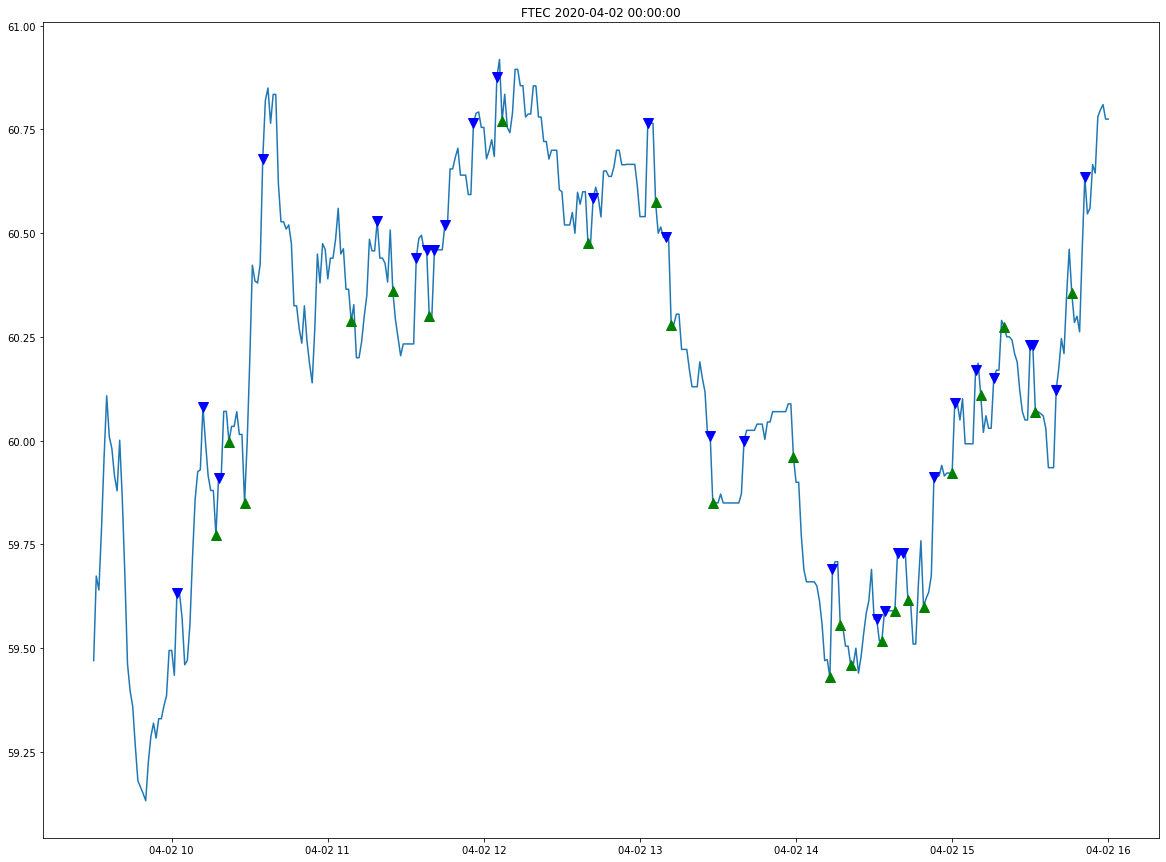

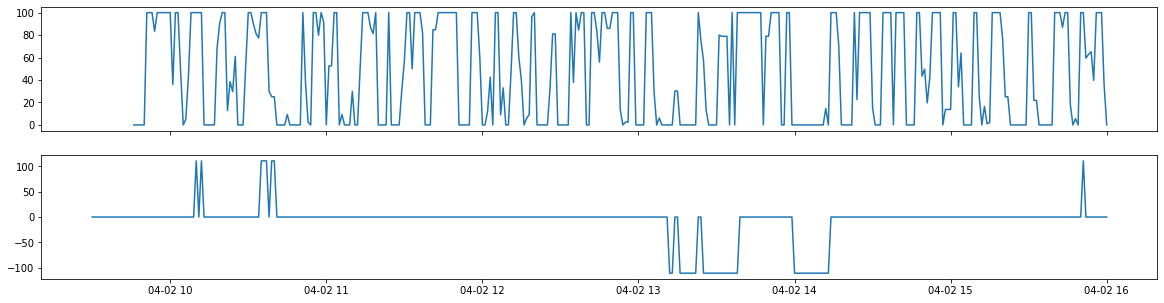

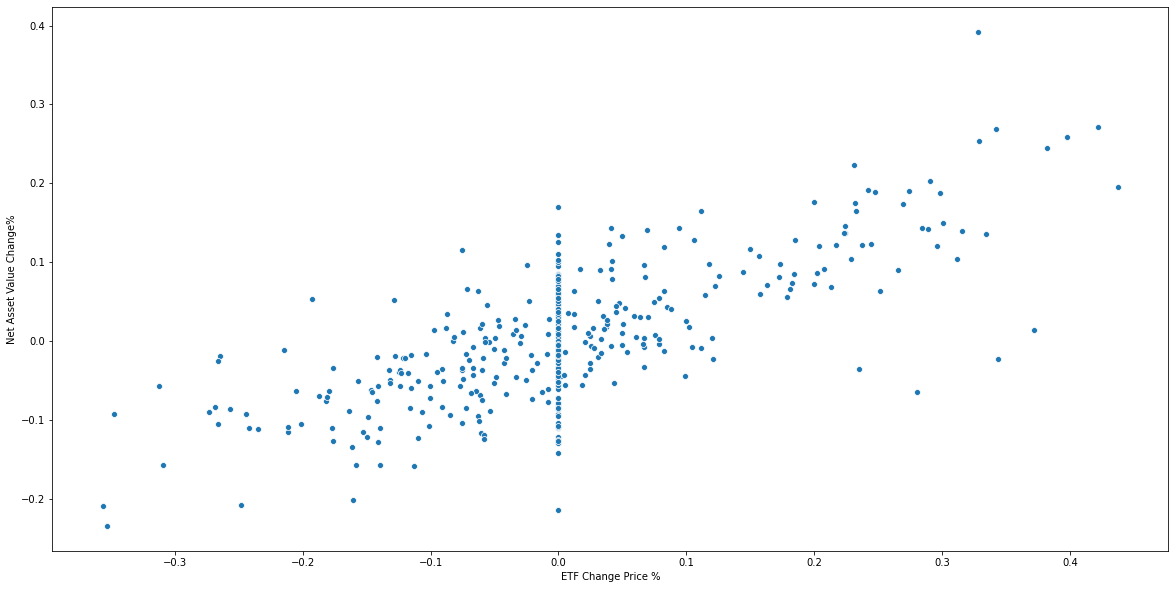

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
17  2020-04-03     AAPL   27.272727         72.727273          
15  2020-04-03     V      26.415094         73.584906          
3   2020-04-03     INTC   34.042553         65.957447          
1   2020-04-03     MA     16.666667         83.333333          
0   2020-04-03     NVDA   36.363636         63.636364          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
17  37.254902         62.745098         201            99         102        
15  35.714286         64.285714         109            53         56         
3   42.857143         57.142857         96             47         49         
1   35.135135         64.864865         73             36         37         
0   30.769231         69.230769         48             22         26

ETF Name =FTEC
Date =2020-04-03 00:00:00
Sell Positions Probability
T+1    0.555556
T+2    0.500000
T+3    0.277778
T+4    0.333333
T+5    0.666667
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-03 10:03:00  0.071023                 0.093193        Weak Trend   
2020-04-03 10:09:00  0.067505                 0.138960        No Trend     
2020-04-03 10:17:00  0.061787                 0.086128        No Trend     
2020-04-03 10:36:00  0.055861                 0.090825        Weak Trend   
2020-04-03 10:54:00  0.056346                 0.095402        No Trend     
2020-04-03 11:01:00  0.052576                 0.217359        Weak Trend   
2020-04-03 11:40:00  0.047746                 0.141881        Weak Trend   
2020-04-03 12:12:00  0.042566                 0.066850        Weak Trend   
2020-04-03 12:41:00  0.042591                 0.069094        No Trend     
2020-04-03 13:46:00  0.041633                 0.119122        Weak Trend   
2020-04-03 14:00:00  0.038473                 0.069948        Weak Trend   
2020-04-03 14:03:00  0.041821                 0.066501        No Trend     
2020-04-03 14:21:00  0.039622                 0.062637        No Trend     
2020-04-03 14:27:00  0.039980                 0.069640        Weak Trend   
2020-04-03 14:52:00  0.042129                 0.151371        Weak Trend   
2020-04-03 15:03:00  0.041364                 0.081077        Weak Trend   
2020-04-03 15:50:00  0.058790                 0.112717        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-03 10:03:00  Strong Uptrend    111.0               0.0             
2020-04-03 10:09:00  NaN               111.0               0.0             
2020-04-03 10:17:00  Strong Downtrend -111.0               0.0             
2020-04-03 10:36:00  Downtrend         111.0               0.0             
2020-04-03 10:54:00  NaN               111.0               0.0             
2020-04-03 11:01:00  NaN               111.0               0.0             
2020-04-03 11:40:00  Strong Uptrend    111.0               0.0             
2020-04-03 12:12:00  NaN              -111.0               0.0             
2020-04-03 12:41:00  Strong Uptrend    111.0               0.0             
2020-04-03 13:46:00  Downtrend         111.0               0.0             
2020-04-03 14:00:00  Strong Downtrend  111.0               0.0             
2020-04-03 14:03:00  NaN              -111.0               0.0             
2020-04-03 14:21:00  NaN               111.0               0.0             
2020-04-03 14:27:00  Strong Uptrend    111.0               0.0             
2020-04-03 14:52:00  NaN               111.0               111.0           
2020-04-03 15:03:00  Strong Uptrend    111.0               111.0           
2020-04-03 15:50:00  Uptrend           111.0               111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-03 10:03:00  0.0            0.0             -111.0                  
2020-04-03 10:09:00  0.0            0.0              111.0                  
2020-04-03 10:17:00  0.0           -111.0           -111.0                  
2020-04-03 10:36:00  0.0            0.0              111.0                  
2020-04-03 10:54:00  0.0            0.0              0.0                    
2020-04-03 11:01:00  0.0            0.0              111.0                  
2020-04-03 11:40:00  0.0            0.0              111.0                  
2020-04-03 12:12:00  0.0            0.0              111.0                  
2020-04-03 12:41:00  0.0            0.0              111.0                  
2020-04-03 13:46:00  0.0            0.0              111.0                  
2020-04-03 14:00:00  0.0            0.0              111.0                  
2020-04-03 14:03:00  0.0            0.0              0.0                    
2020-04-03 14:21:00  0.0            0.0              111.0                  
2020-04-03 14:27:00  0.0            0.0              

******************
Buy Positions Probability
T+1    0.478261
T+2    0.304348
T+3    0.347826
T+4    0.130435
T+5    0.347826
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-03 10:04:00  0.072662                -0.106462        Weak Trend   
2020-04-03 10:10:00  0.065691                -0.126880        No Trend     
2020-04-03 10:19:00  0.060516                -0.107876        No Trend     
2020-04-03 10:29:00  0.058135                -0.155811        Weak Trend   
2020-04-03 10:50:00  0.053042                -0.077193        Weak Trend   
2020-04-03 10:55:00  0.054993                -0.112327        No Trend     
2020-04-03 10:56:00  0.057331                -0.078190        No Trend     
2020-04-03 11:08:00  0.052091                -0.149996        No Trend     
2020-04-03 11:38:00  0.048488                -0.068747        Weak Trend   
2020-04-03 12:07:00  0.042500                -0.145830        Weak Trend   
2020-04-03 12:13:00  0.040878                -0.133097        Weak Trend   
2020-04-03 12:48:00  0.042390                -0.075044        No Trend     
2020-04-03 13:14:00  0.039875                -0.088764        Weak Trend   
2020-04-03 13:27:00  0.035000                -0.112885        No Trend     
2020-04-03 13:30:00  0.037634                -0.072363        Weak Trend   
2020-04-03 13:45:00  0.041397                -0.062574        Weak Trend   
2020-04-03 14:02:00  0.041366                -0.062317        Weak Trend   
2020-04-03 14:16:00  0.038482                -0.075988        No Trend     
2020-04-03 14:25:00  0.039798                -0.063183        Weak Trend   
2020-04-03 14:51:00  0.040512                -0.074331        Weak Trend   
2020-04-03 15:04:00  0.041573                -0.116520        Weak Trend   
2020-04-03 15:43:00  0.031894                -0.064186        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-03 10:04:00  Uptrend          -111.0               0.0             
2020-04-03 10:10:00  NaN              -111.0               0.0             
2020-04-03 10:19:00  Strong Downtrend -111.0               0.0             
2020-04-03 10:29:00  Strong Downtrend -111.0              -111.0           
2020-04-03 10:50:00  NaN              -111.0               0.0             
2020-04-03 10:55:00  Strong Downtrend -111.0               0.0             
2020-04-03 10:56:00  Strong Downtrend -111.0               0.0             
2020-04-03 11:08:00  NaN              -111.0               0.0             
2020-04-03 11:38:00  NaN              -111.0               0.0             
2020-04-03 12:07:00  NaN              -111.0               0.0             
2020-04-03 12:13:00  Strong Downtrend -111.0              -111.0           
2020-04-03 12:48:00  NaN              -111.0               0.0             
2020-04-03 13:14:00  NaN              -111.0               0.0             
2020-04-03 13:27:00  Downtrend        -111.0              -111.0           
2020-04-03 13:30:00  Strong Downtrend -111.0              -111.0           
2020-04-03 13:45:00  Downtrend        -111.0              -111.0           
2020-04-03 14:02:00  NaN              -111.0               0.0             
2020-04-03 14:16:00  Downtrend        -111.0               0.0             
2020-04-03 14:25:00  Strong Uptrend    111.0               0.0             
2020-04-03 14:51:00  NaN               111.0               0.0             
2020-04-03 15:04:00  NaN              -111.0               0.0             
2020-04-03 15:43:00  Strong Downtrend -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-03 10:04:00  0.0            0.0             -111.0                  
2020-04-03 10:10:00  0.0            0.0             -111.0                  
2020-04-03 10:19:00  0.0           -111.0           -111.0                  
2020-04-03 10:29:00 -111.0          0.0             -111.0     

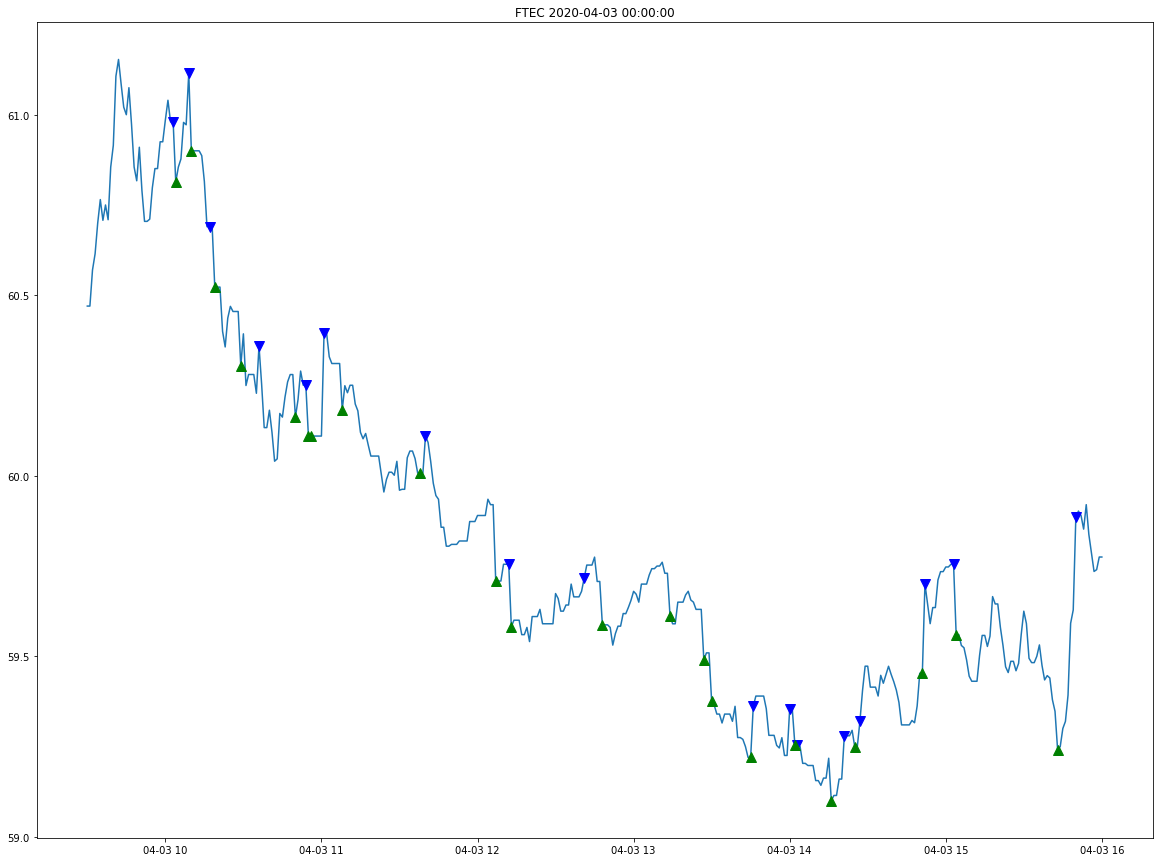

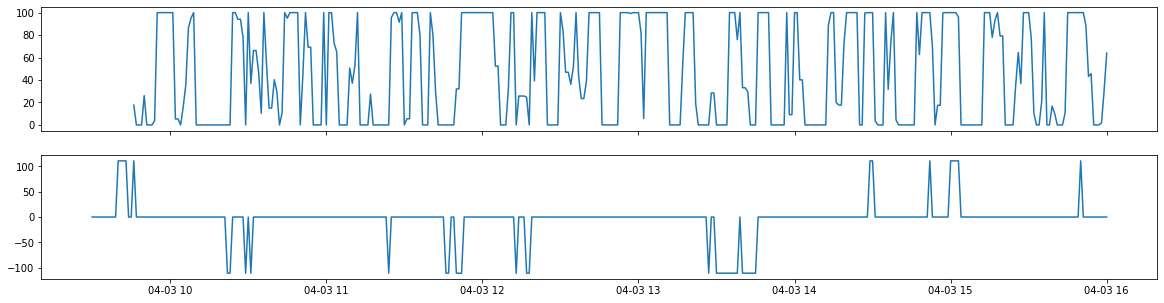

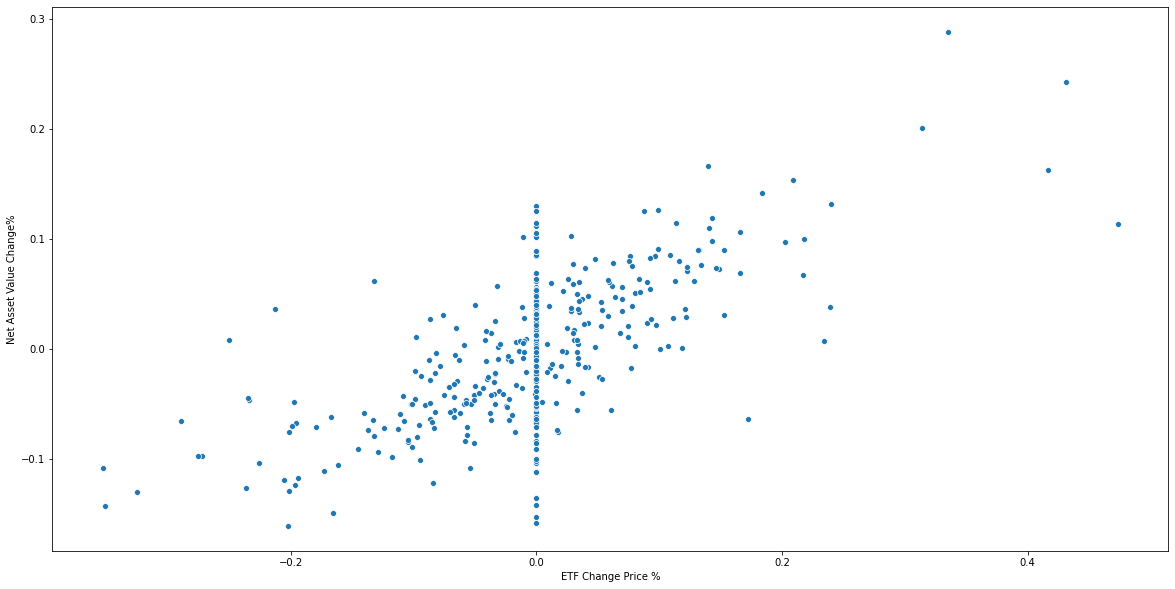

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-04-06     AAPL   45.588235         54.411765          
16  2020-04-06     V      43.333333         56.666667          
4   2020-04-06     INTC   41.379310         58.620690          
1   2020-04-06     MA     31.818182         68.181818          
13  2020-04-06     CSCO   50.000000         50.000000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  49.019608         50.980392         119            68         51         
16  51.515152         48.484848         63             30         33         
4   55.172414         44.827586         58             29         29         
1   52.173913         47.826087         45             22         23         
13  90.000000         10.000000         28             18         10

ETF Name =FTEC
Date =2020-04-06 00:00:00
Sell Positions Probability
T+1    0.454545
T+2    0.272727
T+3    0.272727
T+4    0.272727
T+5    0.545455
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-06 11:26:00  0.023913                 0.049849        No Trend     
2020-04-06 11:40:00  0.027630                 0.055799        No Trend     
2020-04-06 12:51:00  0.026667                 0.058403        No Trend     
2020-04-06 13:20:00  0.025576                 0.045667        No Trend     
2020-04-06 13:49:00  0.021235                 0.051908        Weak Trend   
2020-04-06 15:10:00  0.016918                 0.044976        Weak Trend   
2020-04-06 15:29:00  0.011815                 0.038497        Weak Trend   
2020-04-06 15:49:00  0.015431                 0.042548        Weak Trend   
2020-04-06 15:51:00  0.038286                 0.114352        Weak Trend   
2020-04-06 15:54:00  0.011113                 0.044250        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-06 11:26:00  Downtrend       111.0               0.0             
2020-04-06 11:40:00  NaN            -111.0               0.0             
2020-04-06 12:51:00  NaN             111.0               0.0             
2020-04-06 13:20:00  Downtrend      -111.0               0.0             
2020-04-06 13:49:00  Strong Uptrend  111.0               111.0           
2020-04-06 15:10:00  Strong Uptrend  111.0               111.0           
2020-04-06 15:29:00  Strong Uptrend  111.0               111.0           
2020-04-06 15:49:00  NaN             111.0               0.0             
2020-04-06 15:51:00  NaN             111.0               111.0           
2020-04-06 15:54:00  Uptrend         111.0               111.0           
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-06 11:26:00  0.0            0.0              111.0                  
2020-04-06 11:40:00  0.0            0.0              111.0                  
2020-04-06 12:51:00  0.0            0.0              111.0                  
2020-04-06 13:20:00  0.0            0.0              111.0                  
2020-04-06 13:49:00  111.0          111.0            111.0                  
2020-04-06 15:10:00  111.0          111.0            0.0                    
2020-04-06 15:29:00  111.0          111.0            111.0                  
2020-04-06 15:49:00  0.0            0.0              0.0                    
2020-04-06 15:51:00  111.0          111.0            111.0                  
2020-04-06 15:54:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  HanginMan Pat  \
2020-04-06 11:26:00  0.0             -111.0          0.0             
2020-04-06 11:40:00  0.0              0.0            0.0             
2020-04-06 12:51:00  111.0            0.0            0.0             
2020-04-06 13:20:00  0.0              0.0            0.0             
2020-04-06 13:49:00  111.0            111.0          0.0             
2020-04-06 15:10:00  111.0            0.0            0.0             
2020-04-06 15:29:00  111.0            111.0          0.0             
2020-04-06 15:49:00  111.0            0.0            0.0             
2020-04-06 15:51:00  111.0            111.0          111.0           
2020-04-06 15:54:00  111.0            111.0          0.0             
Total Return        NaN              NaN            NaN              

                     IndecisionDoji Pat       T+1       T+2       T+3  \
2020-04-06 11:26:00  0.0                 0.092108  0.045616  0.033426   
2020-04-06 11:40:00  0.0                 0.102257  0.004029  0.000000   
2020-04-06 12:51:00 -111.0              -0.062844 -0.009275  0.023976   
2020-04-06 13:20:00  0.0                 0.039296 -0.012413  0.028128   
2020-04-06 13:49:00  0.0                -0.066179  0.054638  0.024566   
2020-04-06 15:1

******************
Buy Positions Probability
T+1    0.6
T+2    0.2
T+3    0.0
T+4    0.6
T+5    0.6
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-06 10:08:00  0.036618                -0.057759        Weak Trend   
2020-04-06 12:07:00  0.024465                -0.063562        No Trend     
2020-04-06 15:09:00  0.016485                -0.045414        Weak Trend   
2020-04-06 15:59:00  0.044111                -0.067920        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  Stochastic Indicator  \
2020-04-06 10:08:00  Downtrend     -111.0              -111.0                  
2020-04-06 12:07:00  NaN           -111.0              -111.0                  
2020-04-06 15:09:00  Uptrend        111.0              -111.0                  
2020-04-06 15:59:00  Uptrend       -111.0              -111.0                  
Total Return         NaN           NaN                 NaN                     

                     WILLR Indicator  MFI Indicator  IndecisionDoji Pat  \
2020-04-06 10:08:00 -111.0            0.0            0.0                  
2020-04-06 12:07:00  0.0              0.0           -111.0                
2020-04-06 15:09:00  0.0              0.0           -111.0                
2020-04-06 15:59:00  0.0              111.0          0.0                  
Total Return        NaN              NaN            NaN                   

                          T+1       T+2       T+3       T+4           T+5  
2020-04-06 10:08:00  0.119208  0.000000 -0.039689  0.095291  2.220446e-14  
2020-04-06 12:07:00  0.000000  0.015792 -0.024947  0.062224  0.000000e+00  
2020-04-06 15:09:00  0.140515 -0.054568 -0.140395 -0.039991  8.751449e-03  
2020-04-06 15:59:00  0.000000 NaN       NaN       NaN       NaN            
Total Return         0.259724 -0.038777 -0.205030  0.117525  8.751449e-03

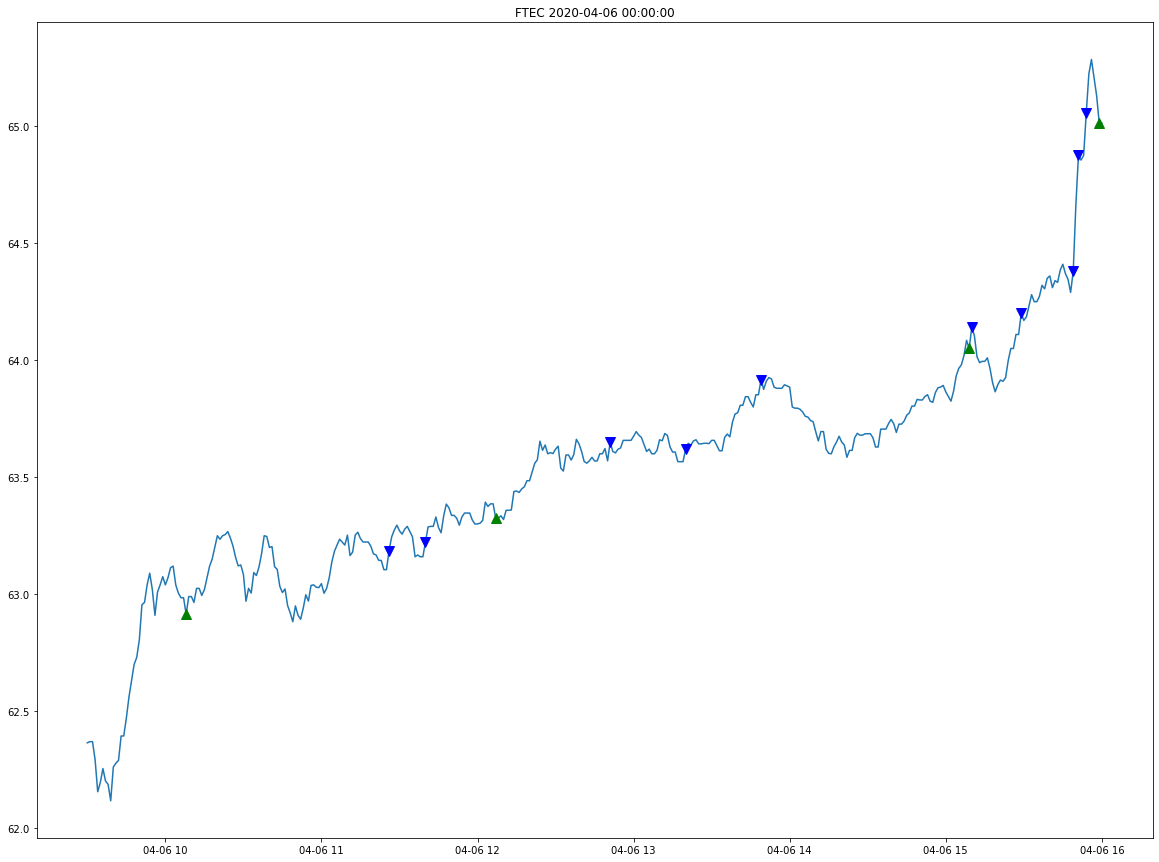

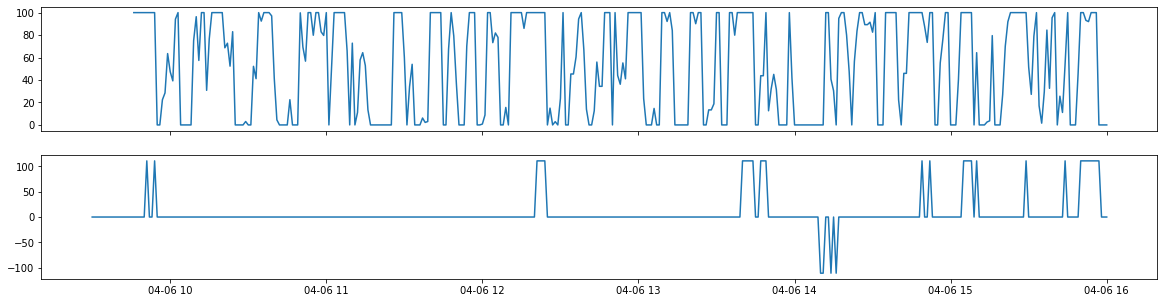

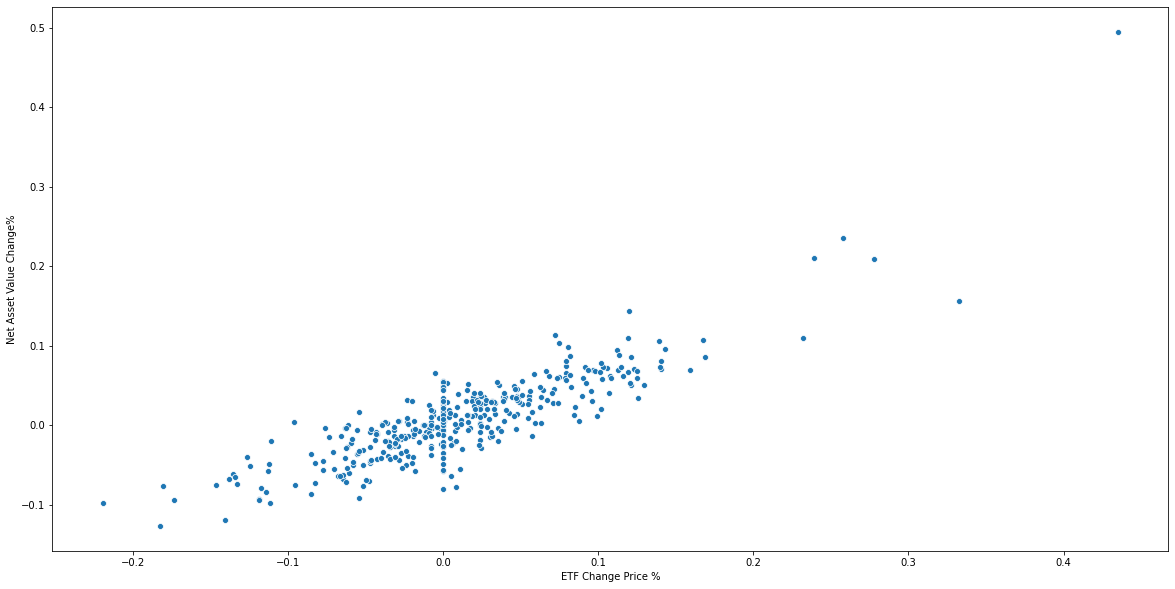

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
18  2020-04-07     AAPL   37.755102         62.244898          
16  2020-04-07     V      36.065574         63.934426          
1   2020-04-07     MA     42.000000         58.000000          
3   2020-04-07     INTC   33.333333         66.666667          
10  2020-04-07     ADBE   44.444444         55.555556          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
18  50.450450         49.549550         209            98         111        
16  45.833333         54.166667         133            61         72         
1   41.935484         58.064516         112            50         62         
3   41.818182         58.181818         103            48         55         
10  69.230769         30.769231         31             18         13

ETF Name =FTEC
Date =2020-04-07 00:00:00
Sell Positions Probability
T+1    0.548387
T+2    0.516129
T+3    0.548387
T+4    0.387097
T+5    0.451613
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-07 09:51:00  0.063651                 0.105249        Weak Trend     
2020-04-07 10:32:00  0.040449                 0.078883        Weak Trend     
2020-04-07 10:38:00  0.046449                 0.075500        Weak Trend     
2020-04-07 10:43:00  0.045621                 0.124668        No Trend       
2020-04-07 10:52:00  0.044481                 0.064745        No Trend       
2020-04-07 11:05:00  0.050154                 0.137714        No Trend       
2020-04-07 11:28:00  0.045949                 0.069810        Weak Trend     
2020-04-07 11:39:00  0.037564                 0.066783        Strong Trend   
2020-04-07 12:38:00  0.036436                 0.076925        Weak Trend     
2020-04-07 12:59:00  0.034101                 0.059325        No Trend       
2020-04-07 13:01:00  0.033353                 0.066053        No Trend       
2020-04-07 13:05:00  0.033889                 0.075064        No Trend       
2020-04-07 13:15:00  0.032759                 0.060099        No Trend       
2020-04-07 13:29:00  0.029254                 0.074933        No Trend       
2020-04-07 13:41:00  0.036250                 0.066918        Weak Trend     
2020-04-07 13:44:00  0.034046                 0.068514        Weak Trend     
2020-04-07 13:48:00  0.035957                 0.057532        No Trend       
2020-04-07 14:10:00  0.031198                 0.056467        Weak Trend     
2020-04-07 14:17:00  0.031757                 0.055111        Weak Trend     
2020-04-07 14:22:00  0.034643                 0.069868        Weak Trend     
2020-04-07 14:42:00  0.034308                 0.058001        No Trend       
2020-04-07 15:03:00  0.032535                 0.066243        Weak Trend     
2020-04-07 15:08:00  0.030243                 0.062057        Weak Trend     
2020-04-07 15:13:00  0.032593                 0.062936        Weak Trend     
2020-04-07 15:17:00  0.033622                 0.078337        Weak Trend     
2020-04-07 15:21:00  0.034733                 0.083779        Weak Trend     
2020-04-07 15:31:00  0.038394                 0.062791        Weak Trend     
2020-04-07 15:34:00  0.039791                 0.070520        No Trend       
2020-04-07 15:35:00  0.040403                 0.060727        No Trend       
2020-04-07 15:47:00  0.031362                 0.052355        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-07 09:51:00  NaN               111.0               0.0             
2020-04-07 10:32:00  Uptrend           111.0               0.0             
2020-04-07 10:38:00  NaN               111.0               0.0             
2020-04-07 10:43:00  Strong Downtrend  111.0               0.0             
2020-04-07 10:52:00  Downtrend        -111.0               0.0             
2020-04-07 11:05:00  NaN               111.0               0.0             
2020-04-07 11:28:00  Uptrend           111.0               0.0             
2020-04-07 11:39:00  Strong Uptrend    111.0               111.0           
2020-04-07 12:38:00  Downtrend         111.0               0.0             
2020-04-07 12:59:00  NaN               111.0               0.0             
2020-04-07 13:01:00  Strong Uptrend    111.0               0.0             
2020-04-07 13:05:00  Uptrend           111.0               0.0             
2020-04-07 13:15:00  NaN               111.0               0.0             
2020-04-07 13:29:00  NaN               111.0               0.0             
2020-04-07 13:41:00  Strong Downtrend  111.0               0.0             
2020-04-07 13:44:00  NaN               111.0               0.0             
2020-04-07 13:48:00  NaN               111.0               0.0             
2020-04-07 14:10:00  Downtrend        -111.0               0.0             
2020-04-07 14:17:00  Downtrend        -111.0               0.0             
2020

******************
Buy Positions Probability
T+1    0.617647
T+2    0.529412
T+3    0.411765
T+4    0.382353
T+5    0.470588
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-07 09:50:00  0.065906                -0.144552        Weak Trend     
2020-04-07 10:04:00  0.040580                -0.071110        No Trend       
2020-04-07 10:30:00  0.040312                -0.075311        Strong Trend   
2020-04-07 10:37:00  0.045958                -0.082835        Weak Trend     
2020-04-07 10:42:00  0.046281                -0.069377        No Trend       
2020-04-07 10:44:00  0.043285                -0.091995        No Trend       
2020-04-07 11:04:00  0.049091                -0.087868        No Trend       
2020-04-07 11:46:00  0.040195                -0.077253        Strong Trend   
2020-04-07 11:55:00  0.035291                -0.061143        Weak Trend     
2020-04-07 12:24:00  0.036124                -0.057345        Weak Trend     
2020-04-07 12:44:00  0.035361                -0.055844        No Trend       
2020-04-07 13:04:00  0.033361                -0.067904        No Trend       
2020-04-07 13:14:00  0.032436                -0.054486        No Trend       
2020-04-07 13:17:00  0.031644                -0.055312        No Trend       
2020-04-07 13:18:00  0.033085                -0.056198        No Trend       
2020-04-07 13:24:00  0.031148                -0.051494        No Trend       
2020-04-07 13:28:00  0.026189                -0.054749        No Trend       
2020-04-07 13:30:00  0.028742                -0.058312        No Trend       
2020-04-07 13:40:00  0.032454                -0.068456        Weak Trend     
2020-04-07 13:45:00  0.033472                -0.135377        Weak Trend     
2020-04-07 14:07:00  0.030224                -0.054825        Weak Trend     
2020-04-07 14:19:00  0.032542                -0.060545        Weak Trend     
2020-04-07 14:41:00  0.032602                -0.082833        No Trend       
2020-04-07 14:51:00  0.028257                -0.118121        Weak Trend     
2020-04-07 14:53:00  0.030058                -0.050331        Weak Trend     
2020-04-07 15:06:00  0.033261                -0.081747        Weak Trend     
2020-04-07 15:16:00  0.034811                -0.066466        Weak Trend     
2020-04-07 15:18:00  0.034375                -0.106005        Weak Trend     
2020-04-07 15:22:00  0.033429                -0.105169        Weak Trend     
2020-04-07 15:25:00  0.038405                -0.086123        Weak Trend     
2020-04-07 15:32:00  0.041753                -0.068161        Weak Trend     
2020-04-07 15:36:00  0.039665                -0.102229        No Trend       
2020-04-07 15:53:00  0.037449                -0.088388        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-07 09:50:00  NaN               111.0               0.0             
2020-04-07 10:04:00  Strong Downtrend -111.0               0.0             
2020-04-07 10:30:00  NaN              -111.0               0.0             
2020-04-07 10:37:00  NaN              -111.0               0.0             
2020-04-07 10:42:00  Strong Downtrend -111.0               0.0             
2020-04-07 10:44:00  Strong Downtrend -111.0               0.0             
2020-04-07 11:04:00  Uptrend          -111.0               0.0             
2020-04-07 11:46:00  Uptrend          -111.0               0.0             
2020-04-07 11:55:00  Strong Downtrend -111.0               0.0             
2020-04-07 12:24:00  NaN              -111.0               0.0             
2020-04-07 12:44:00  Uptrend           111.0               0.0             
2020-04-07 13:04:00  Strong Uptrend   -111.0               0.0             
2020-04-07 13:14:00  NaN               111.0               0.0             
2020-04-07 13:17:00  NaN              -111.0               0.0             
2020-04-07 13:18:00  NaN              -111.0               0.0             
2020-04-07 13:24:00  NaN              -111.0               0.0            

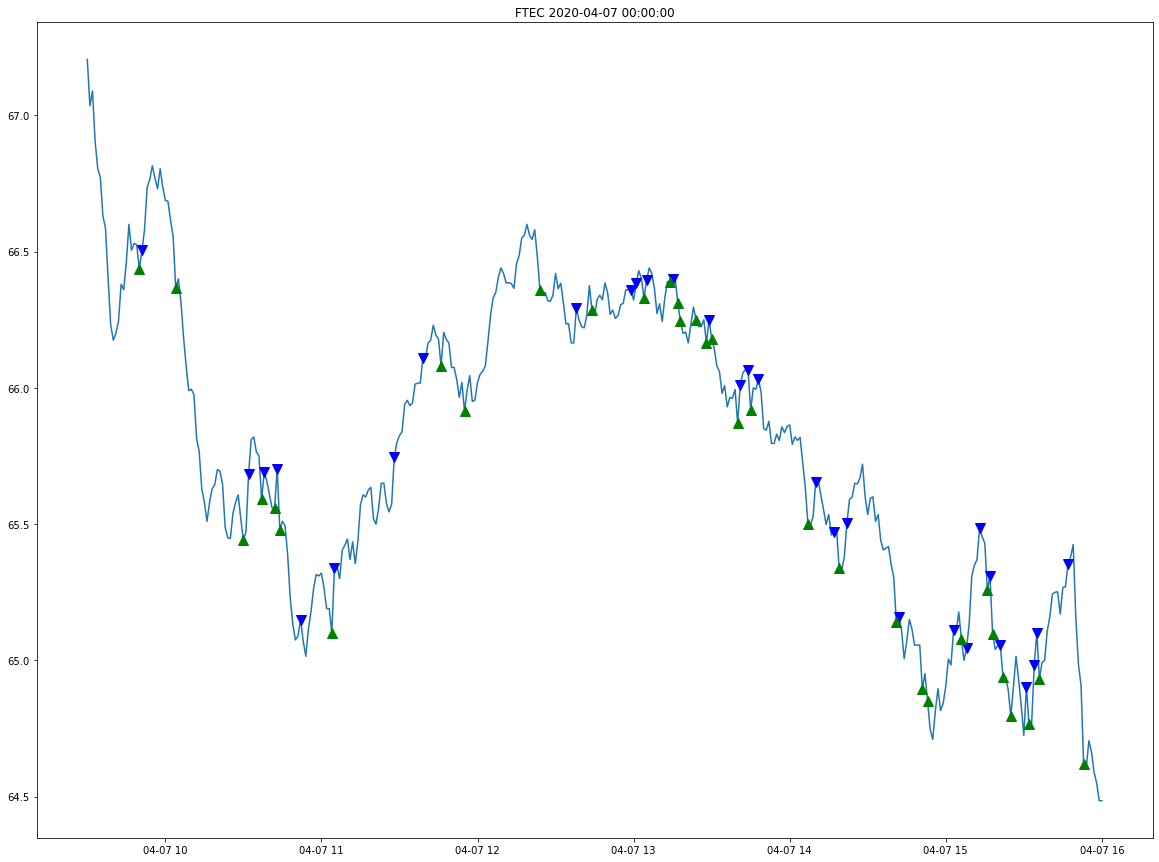

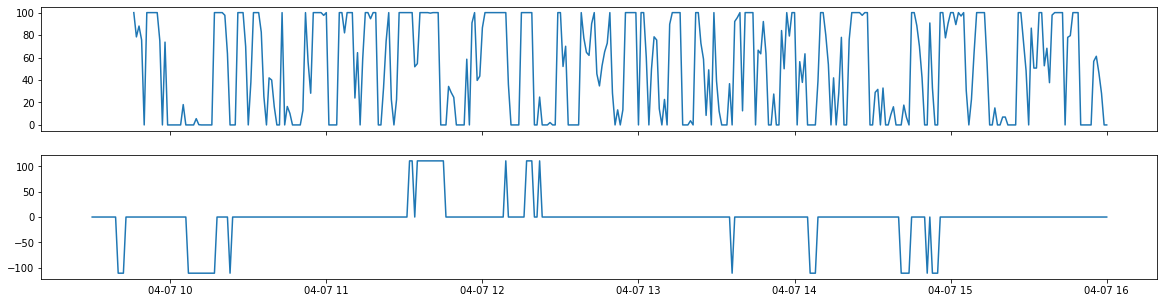

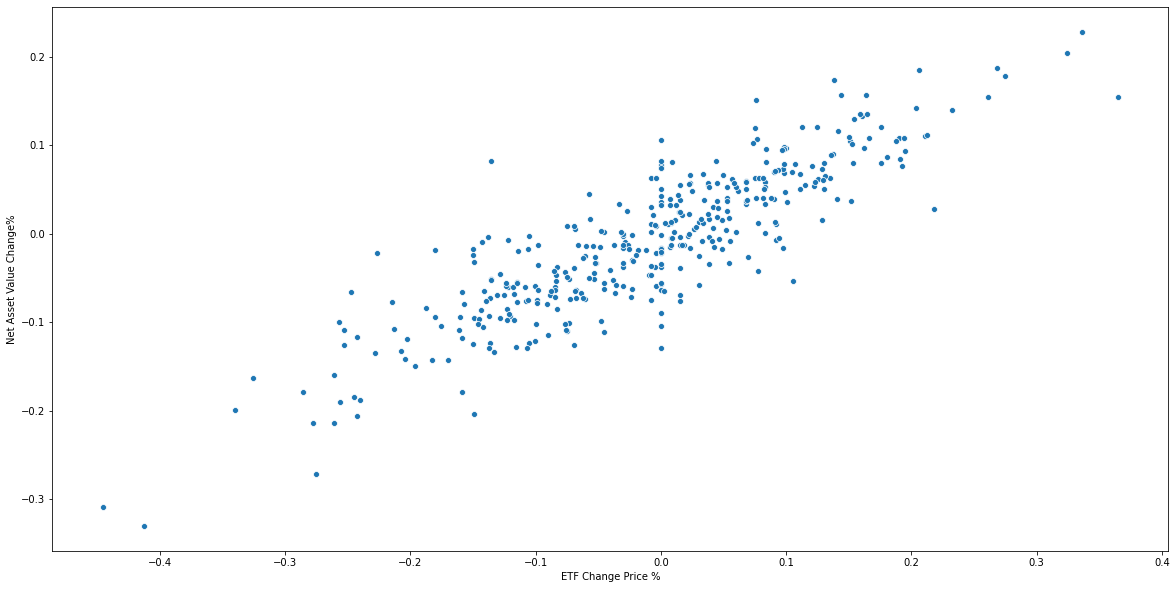

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-08     AAPL   30.120482         69.879518          
14  2020-04-08     V      23.809524         76.190476          
0   2020-04-08     MA     31.914894         68.085106          
2   2020-04-08     INTC   22.580645         77.419355          
1   2020-04-08     NVDA   16.666667         83.333333          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  52.000000         48.000000         158            83         75         
14  54.545455         45.454545         97             42         55         
0   52.272727         47.727273         91             47         44         
2   54.054054         45.945946         68             31         37         
1   46.666667         53.333333         27             12         15

ETF Name =FTEC
Date =2020-04-08 00:00:00
Sell Positions Probability
T+1    0.666667
T+2    0.500000
T+3    0.388889
T+4    0.555556
T+5    0.611111
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-08 09:49:00  0.059977                 0.094045        No Trend     
2020-04-08 10:11:00  0.054802                 0.163196        No Trend     
2020-04-08 11:09:00  0.041091                 0.066940        No Trend     
2020-04-08 11:36:00  0.037029                 0.072050        Weak Trend   
2020-04-08 12:05:00  0.032733                 0.059922        No Trend     
2020-04-08 12:38:00  0.040761                 0.061410        No Trend     
2020-04-08 13:05:00  0.038829                 0.108031        No Trend     
2020-04-08 13:22:00  0.031667                 0.054165        No Trend     
2020-04-08 13:38:00  0.032440                 0.059553        Weak Trend   
2020-04-08 13:41:00  0.034723                 0.077743        Weak Trend   
2020-04-08 13:46:00  0.033413                 0.072401        Weak Trend   
2020-04-08 14:11:00  0.036658                 0.079469        No Trend     
2020-04-08 14:26:00  0.034114                 0.107260        Weak Trend   
2020-04-08 14:32:00  0.031149                 0.059061        Weak Trend   
2020-04-08 14:38:00  0.031481                 0.096231        Weak Trend   
2020-04-08 14:41:00  0.030532                 0.053808        Weak Trend   
2020-04-08 15:30:00  0.031174                 0.052168        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-08 09:49:00  Strong Downtrend -111.0               0.0             
2020-04-08 10:11:00  Downtrend         111.0               0.0             
2020-04-08 11:09:00  Downtrend        -111.0               0.0             
2020-04-08 11:36:00  Strong Uptrend    111.0               111.0           
2020-04-08 12:05:00  NaN               111.0               0.0             
2020-04-08 12:38:00  NaN               111.0               0.0             
2020-04-08 13:05:00  NaN               111.0               0.0             
2020-04-08 13:22:00  NaN               111.0               0.0             
2020-04-08 13:38:00  Downtrend        -111.0               0.0             
2020-04-08 13:41:00  Downtrend         111.0               0.0             
2020-04-08 13:46:00  NaN               111.0               0.0             
2020-04-08 14:11:00  Uptrend           111.0               0.0             
2020-04-08 14:26:00  NaN               111.0               111.0           
2020-04-08 14:32:00  Strong Uptrend    111.0               111.0           
2020-04-08 14:38:00  NaN               111.0               0.0             
2020-04-08 14:41:00  NaN               111.0               111.0           
2020-04-08 15:30:00  Uptrend           111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-08 09:49:00  0.0            0.0             -111.0                  
2020-04-08 10:11:00  0.0            0.0              111.0                  
2020-04-08 11:09:00  0.0            0.0              0.0                    
2020-04-08 11:36:00  111.0          0.0              111.0                  
2020-04-08 12:05:00  0.0            0.0              111.0                  
2020-04-08 12:38:00  0.0            0.0              0.0                    
2020-04-08 13:05:00  0.0            0.0              111.0                  
2020-04-08 13:22:00  0.0            0.0              111.0                  
2020-04-08 13:38:00  0.0           -111.0            111.0                  
2020-04-08 13:41:00  0.0            0.0              111.0                  
2020-04-08 13:46:00  0.0            0.0              111.0                  
2020-04-08 14:11:00  0.0            0.0              111.0                  
2020-04-08 14:26:00  111.0          0.0              111.0                  
2020-04-08 14:32:00  111.0          0.0              

******************
Buy Positions Probability
T+1    0.526316
T+2    0.315789
T+3    0.263158
T+4    0.526316
T+5    0.578947
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-08 09:48:00  0.062120                -0.138278        0            
2020-04-08 09:50:00  0.056058                -0.097752        No Trend     
2020-04-08 10:06:00  0.045278                -0.074597        No Trend     
2020-04-08 10:10:00  0.055964                -0.095205        Weak Trend   
2020-04-08 11:07:00  0.040236                -0.066017        Weak Trend   
2020-04-08 12:00:00  0.036417                -0.068577        No Trend     
2020-04-08 12:06:00  0.031754                -0.077989        No Trend     
2020-04-08 12:26:00  0.033966                -0.058459        Weak Trend   
2020-04-08 12:36:00  0.037421                -0.072314        No Trend     
2020-04-08 13:01:00  0.035654                -0.077586        Weak Trend   
2020-04-08 13:28:00  0.028348                -0.048915        No Trend     
2020-04-08 13:45:00  0.038896                -0.062534        Weak Trend   
2020-04-08 14:04:00  0.048322                -0.070684        Weak Trend   
2020-04-08 14:25:00  0.035605                -0.066720        Weak Trend   
2020-04-08 14:33:00  0.032628                -0.055362        Weak Trend   
2020-04-08 15:12:00  0.025909                -0.055350        Weak Trend   
2020-04-08 15:36:00  0.032588                -0.057160        No Trend     
2020-04-08 15:55:00  0.036994                -0.075502        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-08 09:48:00  NaN              -111.0               0.0             
2020-04-08 09:50:00  Strong Downtrend -111.0               0.0             
2020-04-08 10:06:00  Strong Downtrend -111.0               0.0             
2020-04-08 10:10:00  Downtrend        -111.0               0.0             
2020-04-08 11:07:00  NaN              -111.0               0.0             
2020-04-08 12:00:00  NaN              -111.0               0.0             
2020-04-08 12:06:00  NaN              -111.0               0.0             
2020-04-08 12:26:00  Strong Uptrend   -111.0               0.0             
2020-04-08 12:36:00  NaN              -111.0               0.0             
2020-04-08 13:01:00  Strong Downtrend -111.0               0.0             
2020-04-08 13:28:00  NaN              -111.0               0.0             
2020-04-08 13:45:00  NaN              -111.0               0.0             
2020-04-08 14:04:00  NaN               111.0               0.0             
2020-04-08 14:25:00  NaN               111.0               111.0           
2020-04-08 14:33:00  Strong Uptrend    111.0               0.0             
2020-04-08 15:12:00  NaN              -111.0               0.0             
2020-04-08 15:36:00  NaN              -111.0               0.0             
2020-04-08 15:55:00  Strong Uptrend    111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-08 09:48:00  0.0            0.0             -111.0                  
2020-04-08 09:50:00  0.0            0.0             -111.0                  
2020-04-08 10:06:00  0.0            0.0             -111.0                  
2020-04-08 10:10:00  0.0           -111.0           -111.0                  
2020-04-08 11:07:00  0.0            0.0             -111.0                  
2020-04-08 12:00:00  0.0            0.0             -111.0                  
2020-04-08 12:06:00  0.0            0.0              0.0                    
2020-04-08 12:26:00  0.0            0.0             -111.0                  
2020-04-08 12:36:00  0.0            0.0             -111.0                  
2020-04-08 13:01:00  0.0            0.0             -111.0                  
2020-04-08 13:28:00  0.0            0.0             -111.0                  
2020-04-08 13:45:00  0.0            0.0             -11

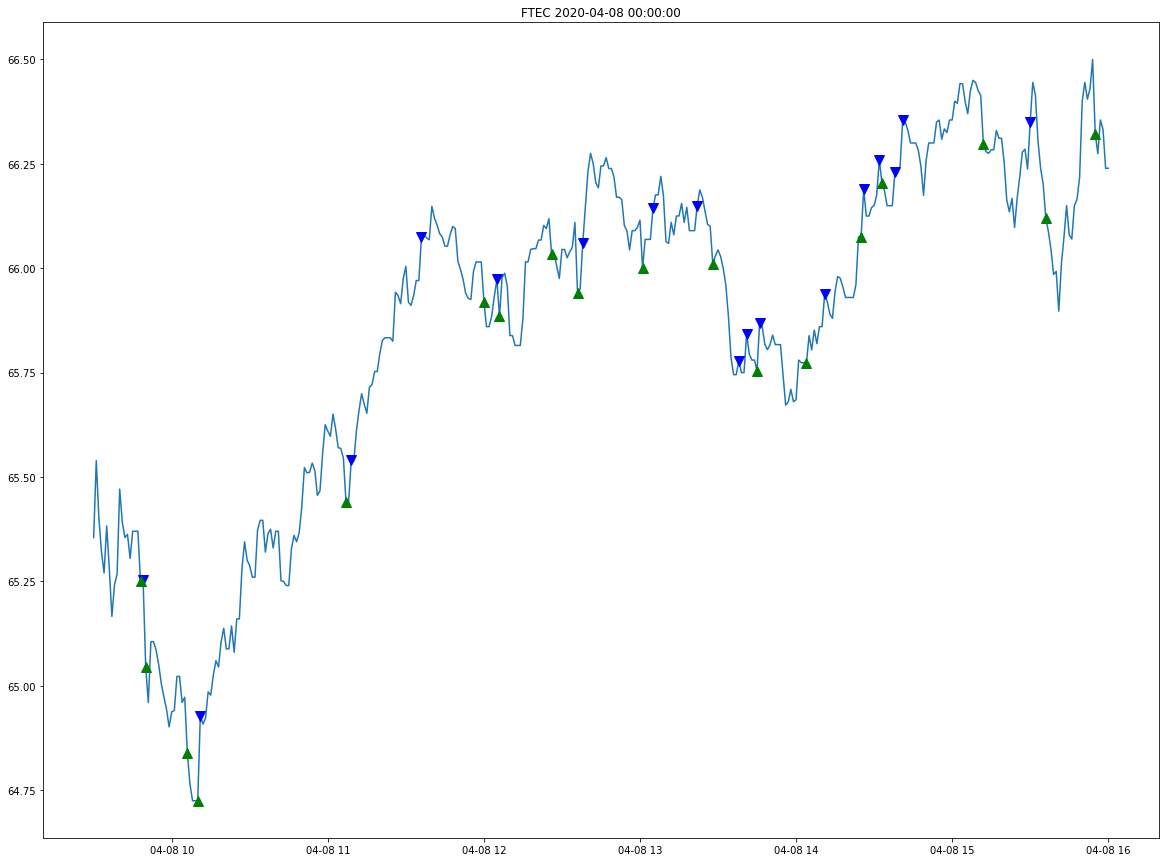

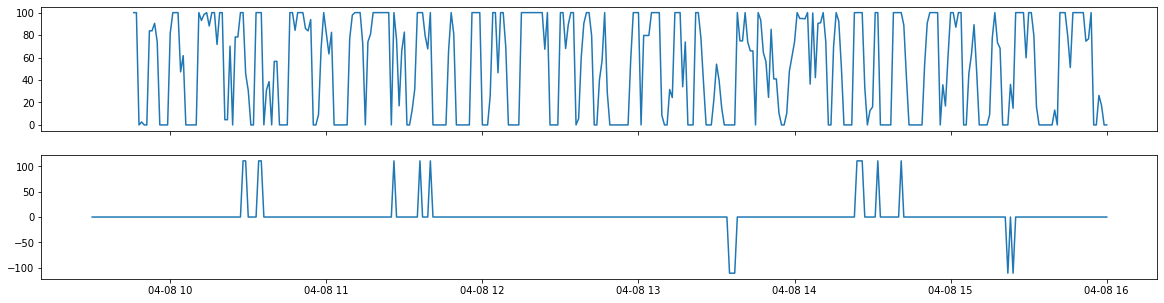

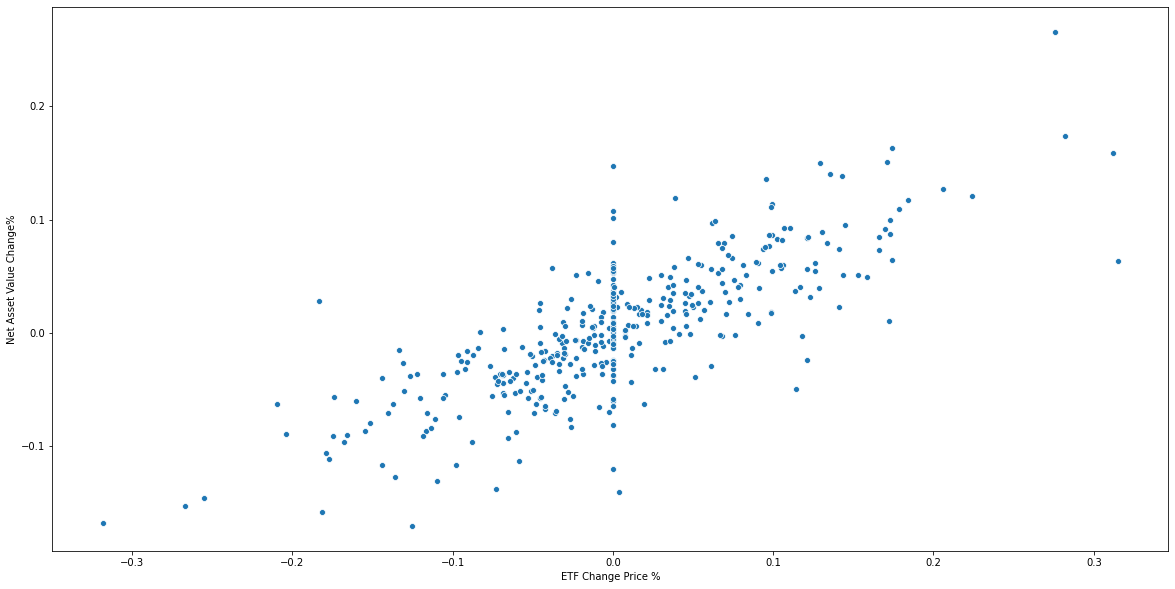

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
13  2020-04-09     AAPL   39.189189         60.810811          
10  2020-04-09     INTC   40.000000         60.000000          
8   2020-04-09     V      40.540541         59.459459          
2   2020-04-09     MA     52.941176         47.058824          
6   2020-04-09     CSCO   43.750000         56.250000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
13  56.666667         43.333333         164            74         90         
10  57.777778         42.222222         85             40         45         
8   54.545455         45.454545         81             37         44         
2   57.446809         42.553191         81             34         47         
6   35.294118         64.705882         33             16         17

ETF Name =FTEC
Date =2020-04-09 00:00:00
Sell Positions Probability
T+1    0.461538
T+2    0.423077
T+3    0.538462
T+4    0.384615
T+5    0.576923
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-09 10:05:00  0.038318                 0.074452        Weak Trend     
2020-04-09 10:13:00  0.041987                 0.079590        Weak Trend     
2020-04-09 10:26:00  0.036652                 0.156479        Strong Trend   
2020-04-09 10:34:00  0.041169                 0.109323        Weak Trend     
2020-04-09 10:38:00  0.039694                 0.079089        No Trend       
2020-04-09 10:43:00  0.036742                 0.058984        No Trend       
2020-04-09 10:45:00  0.032211                 0.098586        No Trend       
2020-04-09 10:58:00  0.035918                 0.112873        No Trend       
2020-04-09 11:07:00  0.037150                 0.068005        Weak Trend     
2020-04-09 11:12:00  0.040995                 0.116109        No Trend       
2020-04-09 11:14:00  0.038228                 0.082976        No Trend       
2020-04-09 11:38:00  0.034834                 0.080045        Weak Trend     
2020-04-09 12:14:00  0.027238                 0.062887        No Trend       
2020-04-09 12:32:00  0.026513                 0.051200        No Trend       
2020-04-09 12:33:00  0.026909                 0.057251        Weak Trend     
2020-04-09 12:35:00  0.026174                 0.046872        Weak Trend     
2020-04-09 13:20:00  0.029004                 0.086974        No Trend       
2020-04-09 13:36:00  0.030495                 0.054076        No Trend       
2020-04-09 13:40:00  0.034726                 0.056796        No Trend       
2020-04-09 13:53:00  0.027344                 0.064274        Weak Trend     
2020-04-09 14:10:00  0.034368                 0.064452        Weak Trend     
2020-04-09 14:32:00  0.032305                 0.058550        No Trend       
2020-04-09 15:06:00  0.032947                 0.070311        Weak Trend     
2020-04-09 15:13:00  0.032082                 0.072363        Weak Trend     
2020-04-09 15:29:00  0.027694                 0.053831        No Trend       
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-09 10:05:00  Downtrend        -111.0               0.0             
2020-04-09 10:13:00  Downtrend        -111.0               0.0             
2020-04-09 10:26:00  Downtrend         111.0               0.0             
2020-04-09 10:34:00  NaN               111.0               0.0             
2020-04-09 10:38:00  Uptrend           111.0               0.0             
2020-04-09 10:43:00  NaN               111.0               0.0             
2020-04-09 10:45:00  Strong Uptrend    111.0               0.0             
2020-04-09 10:58:00  Downtrend         111.0               0.0             
2020-04-09 11:07:00  Strong Downtrend -111.0               0.0             
2020-04-09 11:12:00  NaN               111.0               0.0             
2020-04-09 11:14:00  NaN              -111.0               0.0             
2020-04-09 11:38:00  Strong Uptrend    111.0               111.0           
2020-04-09 12:14:00  Downtrend         111.0               0.0             
2020-04-09 12:32:00  Downtrend        -111.0               0.0             
2020-04-09 12:33:00  Downtrend        -111.0               0.0             
2020-04-09 12:35:00  Strong Downtrend -111.0               0.0             
2020-04-09 13:20:00  Strong Uptrend    111.0               0.0             
2020-04-09 13:36:00  NaN              -111.0               0.0             
2020-04-09 13:40:00  Strong Downtrend -111.0               0.0             
2020-04-09 13:53:00  Downtrend         111.0               0.0             
2020-04-09 14:10:00  Strong Downtrend  111.0               0.0             
2020-04-09 14:32:00  NaN               111.0               0.0             
2020-04-09 15:06:00  Strong Uptrend    111.0               0.0             
2020-04-09 15:13:00  Strong Uptrend    111.0               0.0             
2020-04-09 15:

******************
Buy Positions Probability
T+1    0.578947
T+2    0.368421
T+3    0.526316
T+4    0.368421
T+5    0.473684
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-09 09:30:00  0.107657                -0.145507        0              
2020-04-09 10:04:00  0.041868                -0.074686        Weak Trend     
2020-04-09 10:15:00  0.037939                -0.065604        Weak Trend     
2020-04-09 10:25:00  0.040404                -0.132069        Strong Trend   
2020-04-09 10:33:00  0.042312                -0.070564        Weak Trend     
2020-04-09 10:44:00  0.040515                -0.067903        No Trend       
2020-04-09 11:01:00  0.035000                -0.105446        No Trend       
2020-04-09 11:11:00  0.039646                -0.121677        No Trend       
2020-04-09 11:13:00  0.037801                -0.122831        No Trend       
2020-04-09 12:29:00  0.027353                -0.058400        No Trend       
2020-04-09 12:34:00  0.027248                -0.075919        Weak Trend     
2020-04-09 13:00:00  0.034059                -0.073183        No Trend       
2020-04-09 13:18:00  0.030627                -0.051238        No Trend       
2020-04-09 13:37:00  0.031051                -0.055104        No Trend       
2020-04-09 13:52:00  0.030250                -0.055311        Weak Trend     
2020-04-09 14:11:00  0.030980                -0.070396        Weak Trend     
2020-04-09 14:42:00  0.029447                -0.127403        No Trend       
2020-04-09 15:19:00  0.027236                -0.058173        No Trend       
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-09 09:30:00  NaN               0.0                 0.0             
2020-04-09 10:04:00  NaN              -111.0               0.0             
2020-04-09 10:15:00  Strong Downtrend -111.0               0.0             
2020-04-09 10:25:00  Strong Downtrend -111.0               0.0             
2020-04-09 10:33:00  Uptrend          -111.0               0.0             
2020-04-09 10:44:00  NaN               111.0               0.0             
2020-04-09 11:01:00  NaN              -111.0               0.0             
2020-04-09 11:11:00  NaN              -111.0               0.0             
2020-04-09 11:13:00  NaN              -111.0               0.0             
2020-04-09 12:29:00  Strong Downtrend -111.0               0.0             
2020-04-09 12:34:00  Strong Downtrend -111.0               0.0             
2020-04-09 13:00:00  Uptrend           111.0               0.0             
2020-04-09 13:18:00  NaN              -111.0               0.0             
2020-04-09 13:37:00  Downtrend        -111.0               0.0             
2020-04-09 13:52:00  Downtrend        -111.0              -111.0           
2020-04-09 14:11:00  Strong Downtrend -111.0               0.0             
2020-04-09 14:42:00  Strong Downtrend -111.0               0.0             
2020-04-09 15:19:00  Strong Uptrend   -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-09 09:30:00  0.0            0.0              0.0                    
2020-04-09 10:04:00  0.0            0.0             -111.0                  
2020-04-09 10:15:00  0.0            0.0             -111.0                  
2020-04-09 10:25:00  0.0            0.0              111.0                  
2020-04-09 10:33:00  0.0            0.0             -111.0                  
2020-04-09 10:44:00  0.0            0.0             -111.0                  
2020-04-09 11:01:00  0.0            0.0             -111.0                  
2020-04-09 11:11:00  0.0            0.0             -111.0                  
2020-04-09 11:13:00  0.0            0.0             -111.0                  
2020-04-09 12:29:00  0.0           -111.0           -111.0                  
2020-04-09 12:34:00  0.0            0.0             -111.0                  
2020-04-09 13:0

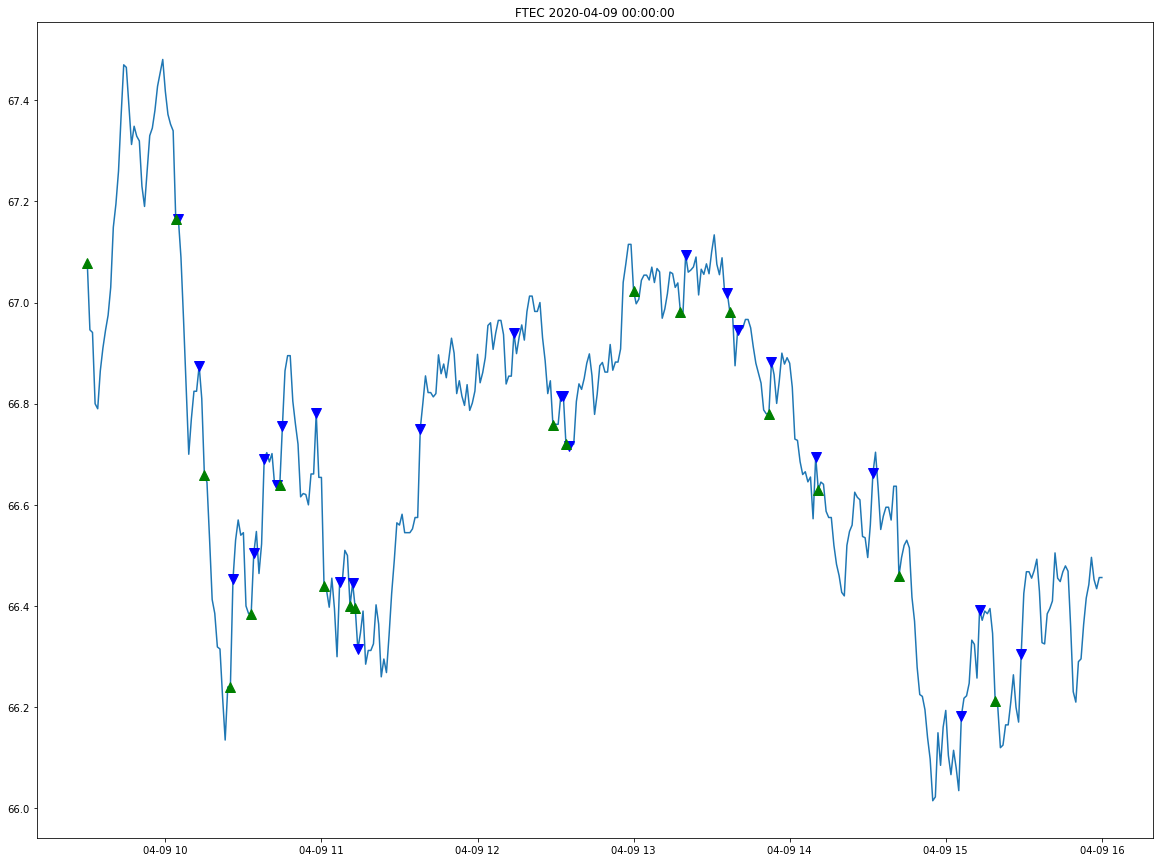

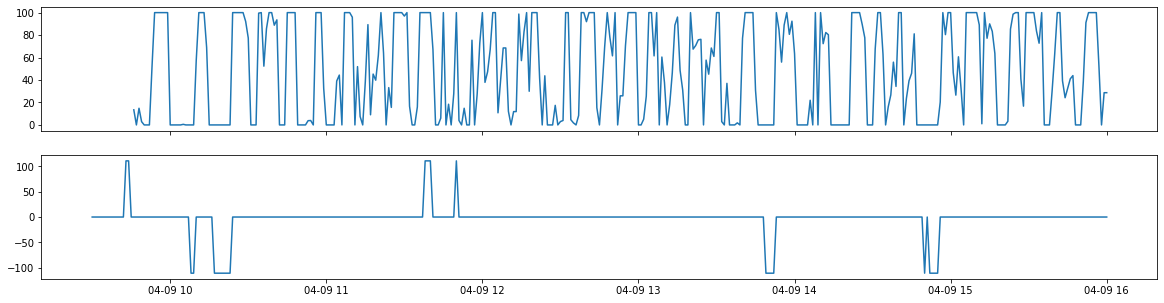

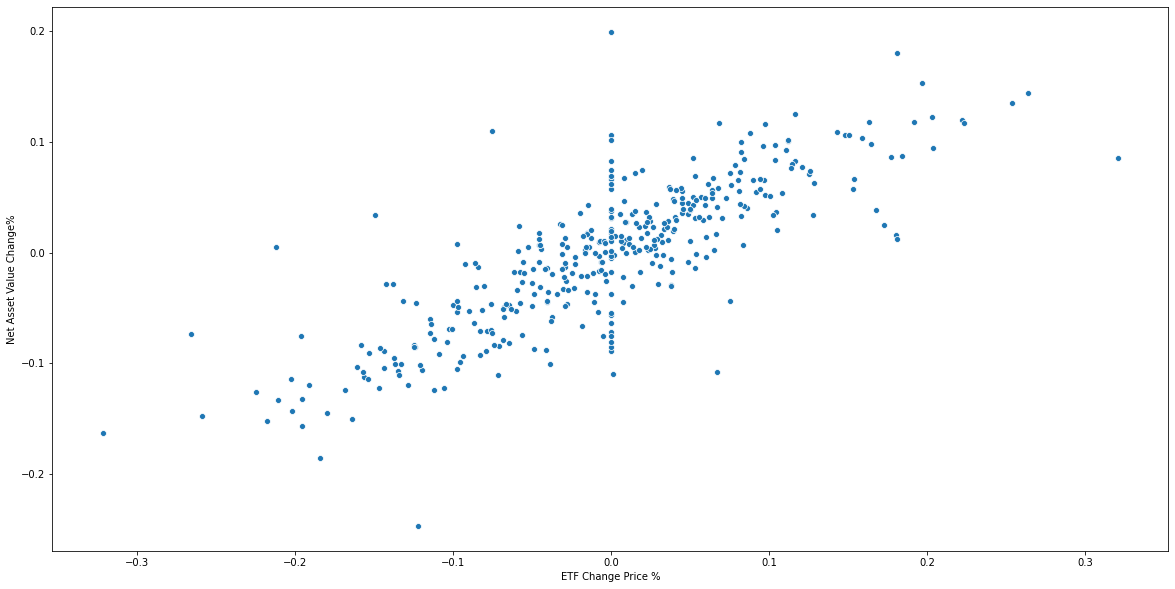

In [ ]:
etfname='FTEC'
s=arbitragecollection.find({'ETFName':etfname}).sort([('dateOfAnalysis', 1)])
for i in s:
    dateOfAnalysis=(i['dateOfAnalysis'])
    year=dateOfAnalysis.year
    # Load Prices Data
    pricedf=LoadETFPrices(etfname,dateOfAnalysis,year)
    # Load Arbitrage Data
    etfdata=loadETFArbitrageData(i['data'],dateOfAnalysis,year)
    
    ArbTP1df = Arb_Tp1(etfdata,dateOfAnalysis.strftime('%Y-%m-%d'),0.02)
    display(ArbTP1df.head())
    
    df=pd.merge(etfdata,pricedf,on='Time',how='left')
    df=df.ffill(axis=0)
    
    magnitute = 0.02
    df['Magnitude of Arbitrage']=abs(df['ETF Trading Spread in $']-abs(df['Arbitrage in $']))
    df['Flag'] = 0
    a = (abs(df['Arbitrage in $']) > df['ETF Trading Spread in $'])
    b = df['ETF Trading Spread in $'] != 0
    c = df['Magnitude of Arbitrage'] > magnitute
    df.loc[a & b & c, 'Flag'] = 111
    df['Flag'] = df['Flag'] * np.sign(df['Arbitrage in $'])
    df=df.set_index('Time')
    
    # Build Signals
    df=MomentumSignals(df,tp=10)
    df=PatternSignals(df)
    
    print("ETF Name ="+ etfname)
    
    plt.figure(figsize=(20,15))
    plt.plot(df.index,df['ETF Price'], label='ETF Price')

    
    columnsneeded=['ETF Trading Spread in $','Arbitrage in $']
    columnsneeded=columnsneeded+MomentumsignalsColumns+CandlesignalsColumns
    
    etfOverBought = df.loc[df['Flag']== 111.0]
    if etfOverBought.shape[0]!=0:
        sellPositions = analysePerformance(df=df, BuySellIndex=etfOverBought)
        print("Date ="+str(dateOfAnalysis))
        print("Sell Positions Probability")
        print(sellPositions[sellPositions<0].count()/sellPositions.shape[0])
        
        tempdf=df.loc[etfOverBought.index]
        tempdf=tempdf[columnsneeded]
        sellPositions=pd.merge(tempdf,sellPositions,how='outer',left_index=True,right_index=True)
        
        print("Sell Positions N+1 Days")
        # Remove any columns with no signal at all
        display(sellPositions.loc[:, ~sellPositions.isin([np.nan, 'NA', 0]).all(axis=0)])
        plt.plot(etfOverBought.index, df.loc[etfOverBought.index]['ETF Price'], 'v', markersize=10, color='b')
        
    etfOverSold = df.loc[df['Flag']== -111.0]
    if etfOverSold.shape[0]!=0:
        buyPositions  = analysePerformance(df=df, BuySellIndex=etfOverSold)
        print("******************")
        print("Buy Positions Probability")
        print(buyPositions[buyPositions>0].count()/buyPositions.shape[0])
        print("Buy Positions N+1 Days")
        
        tempdf=df.loc[etfOverSold.index]
        tempdf=tempdf[columnsneeded]
        buyPositions=pd.merge(tempdf,buyPositions,how='outer',left_index=True,right_index=True)
        
        # Remove any columns with no signal at all
        display(buyPositions.loc[:, ~buyPositions.isin([np.nan, 'NA', 0]).all(axis=0)])
        plt.plot(etfOverSold.index, df.loc[etfOverSold.index]['ETF Price'], '^', markersize=10, color='g')
    plt.title(etfname+' '+str(dateOfAnalysis))
    plt.show()

    fig, ax = plt.subplots(nrows=2,sharex=True,figsize=(20, 5))
    ax[0].plot(df.index,df['FastStochastic'])
    ax[1].plot(df.index,df['CMO Indicator'])
    plt.show()


    a4_dims = (20,10)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.scatterplot(x=df['ETF Change Price %'], y=df['Net Asset Value Change%'])
    plt.show()
    
    '''
    if dateOfAnalysis.strftime('%Y-%m-%d')=='2020-03-18':
        break
    '''

In [139]:
talib.MOM(df['Close'],timeperiod=10)


Time
2020-04-17 09:30:00   NaN    
2020-04-17 09:31:00   NaN    
2020-04-17 09:32:00   NaN    
2020-04-17 09:33:00   NaN    
2020-04-17 09:34:00   NaN    
2020-04-17 09:35:00   NaN    
2020-04-17 09:36:00   NaN    
2020-04-17 09:37:00   NaN    
2020-04-17 09:38:00   NaN    
2020-04-17 09:39:00   NaN    
2020-04-17 09:40:00   -0.2618
2020-04-17 09:41:00   -0.3048
2020-04-17 09:42:00   -0.0732
2020-04-17 09:43:00   -0.1230
2020-04-17 09:44:00   -0.0856
2020-04-17 09:45:00    0.0070
2020-04-17 09:46:00    0.0583
2020-04-17 09:47:00    0.0706
2020-04-17 09:48:00    0.1347
2020-04-17 09:49:00    0.1170
2020-04-17 09:50:00    0.1019
2020-04-17 09:51:00    0.1590
2020-04-17 09:52:00    0.1727
2020-04-17 09:53:00    0.1099
2020-04-17 09:54:00   -0.0530
2020-04-17 09:55:00   -0.0920
2020-04-17 09:56:00    0.0193
2020-04-17 09:57:00    0.0493
2020-04-17 09:58:00    0.0100
2020-04-17 09:59:00   -0.0170
2020-04-17 10:00:00    0.0300
2020-04-17 10:01:00    0.2028
2020-04-17 10:02:00    0.0004
2020-